In [1]:
#Jump to: Maximizing/Matching CONTROL
 #or: Maximizing/Matching SOCIAL  

import csv
import pandas as pd
import numpy as np
import glob
import matplotlib
import scipy as sp
from matplotlib import pyplot as plt
from itertools import cycle, islice
from scipy import stats
from datetime import datetime

import seaborn as sns

-g2 w/ same vs diff contingencies
    -combine SMAB3+4 
    -look at choice behavior
-g1
    -combine SMAB3+4
-plot score for 50 and 20 intervals 


-removing 1st trials?
-RT
-questionnaire


9/25
need to:

1. look into c07 (key error 399): need to code first 3 trials
2. compare 100, 200, 300 timestamps
4. write script to add probabilities to hand coded df 
5. work on reaction time analyses
    import timestamps from hand coded files 
7. hand code first 3 trials of c07 and add to analyses 

This notebook is for analyzing behavior data in the social multi-armed bandit (SMAB) paradigm.
It uses Pandas dataframes (https://pandas.pydata.org/docs/getting_started/index.html#getting-started).
The 's' datasets are single-player sessions from SMAB3 and the 'j' datasets are multi-player sessions from SMAB3.
The 'c' datasets are single-player sessions from SMAB4 and the 'm' datasets are multi-player sessions from SMAB4.

Updated by Bar Y. 8/4/20

In [374]:
'''
These functions import csv files into pandas dataframes and rename the columns.
input: filename of the csv file to import; the path needs to be included, as well
output: pandas dataframe

There are multiple iterations of this function because the data is in slightly different formats. 
'''


def organize_trial_by_trial(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #drops first 20 trials of game 1
    #remove if you want to analyze the whole session
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    #df = df.drop(['reward'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



#0 means "next" button
#need to exclude zero?

def organize_trial_by_trial_floatclick(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"P1 score", 7:"P2 score", 8:""})
    #have 402 so need to restrict
    #df = df[1:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



def organize_trial_by_trial_300(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"reward", 7:"time", 8:"P1 score", 9:"P2 score"})
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    #df = df.drop(['type', 'reward'], axis=1)
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

#used before changes were made to template
def organize_trial_by_trial_hand_code(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    #remove first row with column headings
    df = df.drop(df.index[0])
    #convert values to numbers (NEED TO FIX)
    df.reset_index(drop=True,inplace=True)
    df = df.drop(range(0, 8))
    df.reset_index(drop=True,inplace=True)
    #df = df.apply(pd.to_numeric)
    #add column headings
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward",6:"time",7:"P1 score", 8:"P2 score"})
    df.head()
    
    return df

#use this function for hand coded game data files 
def organize_trial_by_trial_hand_code2(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    #remove first row with column headings
    df = df.drop(df.index[0])
    #convert values to numbers (NEED TO FIX)
    df.reset_index(drop=True,inplace=True)
    df = df.drop(range(0, 8))
    df.reset_index(drop=True,inplace=True)
    #drop comment columns
    #df = df.drop(range(7,9), axis = 1)
    #add p1 and p2 score columns
    df.insert
    #add column headings
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward",6:"time",7:"comment 1", 8:"comment 2", 9:"P1 score", 10:"P2 score"})
    
    #remove the time and comment columns (we'll add them back in a moment)
    #we are removing them bc we are converting all the values to numbeic and this can't be done to these columns
    time = df['time']
    df = df.drop('time', axis = 1 )
    
    comment_1 = df['comment 1']
    comment_2 = df['comment 2']
    df = df.drop('comment 1', axis = 1 )
    df = df.drop('comment 2', axis = 1 )
    
    df = df.apply(pd.to_numeric)
    
    #add dropped columns back in
    df['time'] = time
    df['comment 1'] = comment_1
    df['comment 2'] = comment_2
    
    #convert time and comment 1 to date time objects
    df['time']= pd.to_datetime(df['time'], errors = 'coerce', format = '%M:%S.%f')
    df['comment 1']= pd.to_datetime(df['comment 1'], errors = 'coerce', format = '%M:%S.%f')

    df.head()
    
    return df

In [375]:
'''
This function returns the score for game 1 and game 2. call_get_score can be used to call this function.
'''
def get_score(df, player_number, game_number):
    if game_number == 1:
        row = 199
    elif game_number == 2:
        row = 399
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

'''Here we get the score at trial 50 of both games'''
def get_score_at_50(df, player_number, game_number):
    if game_number == 1:
        row = 99
    elif game_number == 2:
        row = 300
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

In [ ]:
#create a dataframes for scores
scores = pd.DataFrame(columns=['s_g1','s_g2','c_g1','c_g2', 'j_g1', 'j_g2', 'm_g1', 'm_g2'])

'''This function calls get_score.
input: dataframe with game data and version*
output: scores for each player and each game**
*version is 's' for single player SMAB3, 'c' for single player SMAB4, 'j' for multiplayer SMAB3, 
'm' for multiplayer SMAB4
**only 1 player score is outputted for each game in the single player sessions, while scores for both players are 
outputted for multiplayer sessions'''
def call_get_score(df, version):
    p1_g1 = get_score(df, 1, 1)
    p1_g2 = get_score(df, 1, 2)
    p1_score_diff = p1_g2 - p1_g1
    
    p1_g1_50 = get_score_at_50(df, 1, 1)
    p1_g2_50 = get_score_at_50(df, 1, 2)
    
    if version == 'j' or version == 'm':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        
        p1_g1_50 = get_score_at_50(df, 1, 1)
        p1_g2_50 = get_score_at_50(df, 1, 2)
        
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        
        p2_g1_50 = get_score_at_50(df, 2, 1)
        p2_g2_50 = get_score_at_50(df, 2, 2)
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff, p1_g1_50,p1_g2_50, p2_g1_50, p2_g2_50

    return p1_g1, p1_g2, p1_score_diff, p1_g1_50, p1_g2_50

In [376]:
'''This functions separates the dataframes by player and game.
input: dataframe with gamedata and version*
output: four dataframes separated by player and game
*same as call_get_score above'''
def separate_df(df, version):
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    
    #remove trials for g1
    #df_p1_g1 = df_p1_g1[20:40]
    #remove trials for g2
    #df_p1_g2 = df_p1_g2[20:40]
    
    if version == 's':
        return df_p1_g1, df_p1_g2
    if version == 'c':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    
    #remove trials for g1
   # df_p2_g1 = df_p2_g1[20:40]
    #remove trials for g2
    #df_p2_g2= df_p2_g2[20:40]
    
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2

In [378]:
#ignore for now
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [380]:
'''This function separates reaction times into post-win and post-loss arrays.
NOTE that it is intended to be called with dataframes separated by separate_df'''
def reaction_time(df, time):
    df.reset_index(drop=True, inplace=True)
    post_win_time = []
    post_loss_time = []
    for index, row in df.iterrows():
        if index > 0 and index < 101:
            prev_rew = df.loc[index - 1, 'reward']
            if prev_rew == 1:
                post_win_time.append(df.loc[index, 'time'])
            elif prev_rew == 0:
                post_loss_time.append(df.loc[index, 'time'])
    post_win_mean = np.mean(post_win_time)
    post_loss_mean = np.mean(post_loss_time)
    name = str(get_df_name(df))
    time = time.append({'session' : name , 'post win' : post_win_mean, 'post loss': post_loss_mean} , ignore_index=True)
    return(time)

In [381]:
'''This functionfixes the reward column in the files imported using the '300' function. 
This function works for dataframes that have already been split up by game and player by separate_df (ex. c12_p1_g1)
NOTE that this function had to be written for a subset of the data that had a bug that caused the reward column to be
0 for all trials.'''
def fix_reward(df):
    df.reset_index(drop=True, inplace=True)
    for index, row in df.iterrows():
        if df.loc[index, 'player'] == 1:
                score_column = 'P1 score'
        elif df.loc[index, 'player'] == 2:
                score_column = 'P2 score'
        if index == 0:
            if df.loc[index, score_column] == 1:
                df.loc[index, 'reward'] = 1
            #not necessary here because the values are all 0
            else:
                df.loc[index, 'reward'] = 0
        elif index > 0:
            prev_score = df.loc[index - 1, score_column]
            curr_score = df.loc[index, score_column]
            score_diff = curr_score - prev_score
            df.loc[index, 'reward'] = score_diff
    return(df)

In [384]:
'''This function outputs the hole-probability mappings in each game. 
input: df of session data
output: df with the hole-probability mappings
g = game
p = player
h = hole
r = reward (1 means yes and 0 means no)
'''

def hole_prob_map(df):
    h1_prob = df.loc[df['arm'] == 1, 'probability'].iloc[0]
    h2_prob = df.loc[df['arm'] == 2, 'probability'].iloc[0]
    h3_prob = df.loc[df['arm'] == 3, 'probability'].iloc[0]
    h_probs = pd.DataFrame({'h1_prob': [h1_prob], 'h2_prob': [h2_prob], 'h3_prob': [h3_prob]})
    
    return h_probs


# Hand Coding Functions
These functions can be used for game data files that were created by hand coding.

In [387]:
'''This function calculates the number of times each hole was chosen and the 
probability with which each hole rewarded each player in each game.
input: hand coded game data file in a df
output: df with the number of times each hole was chosen by each player in each game and the percentage of choices that were
rewarded
g = game
p = player
h = hole
r = reward (1 means yes and 0 means no)'''

def handcode_calc_prob(df):
    
    #get counts for g1, p1
    g1_p1_h1_r1_count = len(df[(df['game number']==1) & (df['player']==1) & (df['arm']==1) & (df['reward']==1)])
    g1_p1_h1_r0_count = len(df[(df['game number']==1) & (df['player']==1) & (df['arm']==1) & (df['reward']==0)])
    g1_p1_h2_r1_count = len(df[(df['game number']==1) & (df['player']==1) & (df['arm']==2) & (df['reward']==1)])
    g1_p1_h2_r0_count = len(df[(df['game number']==1) & (df['player']==1) & (df['arm']==2) & (df['reward']==0)])
    g1_p1_h3_r1_count = len(df[(df['game number']==1) & (df['player']==1) & (df['arm']==3) & (df['reward']==1)])
    g1_p1_h3_r0_count = len(df[(df['game number']==1) & (df['player']==1) & (df['arm']==3) & (df['reward']==0)])
 
    #get counts for g1,p2
    g1_p2_h1_r1_count = len(df[(df['game number']==1) & (df['player']==2) & (df['arm']==1) & (df['reward']==1)])
    g1_p2_h1_r0_count = len(df[(df['game number']==1) & (df['player']==2) & (df['arm']==1) & (df['reward']==0)])
    g1_p2_h2_r1_count = len(df[(df['game number']==1) & (df['player']==2) & (df['arm']==2) & (df['reward']==1)])
    g1_p2_h2_r0_count = len(df[(df['game number']==1) & (df['player']==2) & (df['arm']==2) & (df['reward']==0)])
    g1_p2_h3_r1_count = len(df[(df['game number']==1) & (df['player']==2) & (df['arm']==3) & (df['reward']==1)])
    g1_p2_h3_r0_count = len(df[(df['game number']==1) & (df['player']==2) & (df['arm']==3) & (df['reward']==0)])

    #get counts for g2,p1
    g2_p1_h1_r1_count = len(df[(df['game number']==2) & (df['player']==1) & (df['arm']==1) & (df['reward']==1)])
    g2_p1_h1_r0_count = len(df[(df['game number']==2) & (df['player']==1) & (df['arm']==1) & (df['reward']==0)])
    g2_p1_h2_r1_count = len(df[(df['game number']==2) & (df['player']==1) & (df['arm']==2) & (df['reward']==1)])
    g2_p1_h2_r0_count = len(df[(df['game number']==2) & (df['player']==1) & (df['arm']==2) & (df['reward']==0)])
    g2_p1_h3_r1_count = len(df[(df['game number']==2) & (df['player']==1) & (df['arm']==3) & (df['reward']==1)])
    g2_p1_h3_r0_count = len(df[(df['game number']==2) & (df['player']==1) & (df['arm']==3) & (df['reward']==0)])

    #get counts for g2,p2
    g2_p2_h1_r1_count = len(df[(df['game number']==2) & (df['player']==2) & (df['arm']==1) & (df['reward']==1)])
    g2_p2_h1_r0_count = len(df[(df['game number']==2) & (df['player']==2) & (df['arm']==1) & (df['reward']==0)])
    g2_p2_h2_r1_count = len(df[(df['game number']==2) & (df['player']==2) & (df['arm']==2) & (df['reward']==1)])
    g2_p2_h2_r0_count = len(df[(df['game number']==2) & (df['player']==2) & (df['arm']==2) & (df['reward']==0)])
    g2_p2_h3_r1_count = len(df[(df['game number']==2) & (df['player']==2) & (df['arm']==3) & (df['reward']==1)])
    g2_p2_h3_r0_count = len(df[(df['game number']==2) & (df['player']==2) & (df['arm']==3) & (df['reward']==0)])
    
    #calculate reward rate of each hole in each condition
    
    g1_p1_h1 = calc_prob(g1_p1_h1_r1_count,g1_p1_h1_r0_count)
    g1_p1_h2 = calc_prob(g1_p1_h2_r1_count,g1_p1_h2_r0_count)
    g1_p1_h3 = calc_prob(g1_p1_h3_r1_count,g1_p1_h3_r0_count)
    
    g1_p2_h1 = calc_prob(g1_p2_h1_r1_count,g1_p2_h1_r0_count)
    g1_p2_h2 = calc_prob(g1_p2_h2_r1_count,g1_p2_h2_r0_count)
    g1_p2_h3 = calc_prob(g1_p2_h3_r1_count,g1_p2_h3_r0_count)
    
    g2_p1_h1 = calc_prob(g2_p1_h1_r1_count,g2_p1_h1_r0_count)
    g2_p1_h2 = calc_prob(g2_p1_h2_r1_count,g2_p1_h2_r0_count)
    g2_p1_h3 = calc_prob(g2_p1_h3_r1_count,g2_p1_h3_r0_count)
    
    g2_p2_h1 = calc_prob(g2_p2_h1_r1_count,g2_p2_h1_r0_count)
    g2_p2_h2 = calc_prob(g2_p2_h2_r1_count,g2_p2_h2_r0_count)
    g2_p2_h3 = calc_prob(g2_p2_h3_r1_count,g2_p2_h3_r0_count)
    
    
    #NEED to add indices to these
    p1_counts_d = {'g1_p1_h1_count': [g1_p1_h1_r1_count, g1_p1_h1_r0_count], 'g1_p1_h2_count': [g1_p1_h2_r1_count, g1_p1_h2_r0_count],
        'g1_p1_h3_count': [g1_p1_h3_r1_count, g1_p1_h3_r0_count], 'g2_p1_h1_count': [g2_p1_h1_r1_count, g2_p1_h1_r0_count], 
         'g2_p1_h2_count': [g2_p1_h2_r1_count, g2_p1_h2_r0_count],
        'g2_p1_h3_count': [g2_p1_h3_r1_count, g2_p1_h3_r0_count] }
    p1_counts_df = pd.DataFrame(p1_counts_d)
    
    p2_counts_d = {'g1_p2_h1_count': [g1_p2_h1_r1_count, g1_p2_h1_r0_count], 'g1_p2_h2_count': [g1_p2_h2_r1_count, g1_p2_h2_r0_count],
        'g1_p2_h3_count': [g1_p2_h3_r1_count, g1_p2_h3_r0_count], 'g2_p2_h1_count': [g2_p2_h1_r1_count, g2_p2_h1_r0_count], 
         'g2_p2_h2_count': [g2_p2_h2_r1_count, g2_p2_h2_r0_count],
        'g2_p2_h3_count': [g2_p2_h3_r1_count, g2_p2_h3_r0_count] }
    p2_counts_df = pd.DataFrame(p2_counts_d)
    
    p1_counts_df.index = ['rewarded', 'non-rewarded']
    p2_counts_df.index = ['rewarded','non-rewarded']
    
    p1_probs_d = {'p1_h1':[g1_p1_h1, g2_p1_h1], 'p1_h2':[g1_p1_h2, g2_p1_h2], 'p1_h3':[g1_p1_h3, g2_p1_h3]}
    p1_probs_df = pd.DataFrame(p1_probs_d)
    
    p2_probs_d = {'p2_h1':[g1_p2_h1, g2_p2_h1], 'p1_h2':[g1_p2_h2, g2_p2_h2], 'p1_h3':[g1_p2_h3, g2_p2_h3]}
    p2_probs_df = pd.DataFrame(p2_probs_d)
    
    p1_probs_df.index = ['game 1', 'game 2'] 
    p2_probs_df.index = ['game 1','game 2']
    
    return p1_counts_df, p2_counts_df, p1_probs_df, p2_probs_df


In [388]:
'''This function is called in handcode_calc_prob and calculates the reward probability of a hole.
input: number of rewarded trials, number of un-rewarded trials
output: percentage of rewarded trials for that hole'''
def calc_prob(r1,r0):
    try:
        return (r1/(r1+r0) * 100)
    #if the hole was never chosen and the denominator is 0
    except ZeroDivisionError:
        return 0

In [389]:
'''This function fills in the dataframe with the probabilities (30, 60, or 90) to each hole for each player in each
game.
input: dataframe with gamedata, probabilities for each player/game number/hole*
output: dataframe with the probabilities filled in
*You must put the inputs in the correct order as defined in the parameters of the function.
'''
def fill_in_prob(df, p1_g1_h1, p1_g1_h2, p1_g1_h3, p1_g2_h1, p1_g2_h2, p1_g2_h3, p2_g1_h1, p2_g1_h2, p2_g1_h3, 
                 p2_g2_h1, p2_g2_h2, p2_g2_h3):
    for index, row in df.iterrows():
        if df.loc[index,'game number'] == 1:
            if df.loc[index,'player'] == 1:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p1_g1_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p1_g1_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p1_g1_h3
            elif df.loc[index,'player'] == 2:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p2_g1_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p2_g1_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p2_g1_h3
        elif df.loc[index,'game number'] == 2:
            if df.loc[index,'player'] == 1:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p1_g2_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p1_g2_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p1_g2_h3
            elif df.loc[index,'player'] == 2:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p2_g2_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p2_g2_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p2_g2_h3
    return df

# SMAB3 Single Player Analysis

In [34]:
'''
Here, we load all of the csv files into pandas dataframes using organize_trial_by_trial and get the game 1 and 2 scores using 
call_get_score.'''

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s01_gamedata.csv')
s01 = df
s01_p1_g1_score,s01_p1_g2_score,s01_score_diff,s01_p1_g1_50,s01_p1_g2_50 = call_get_score(s01, 's')
s01.head()

''''#in the s files, p2 is the confederate- NEED TO WORK ON
df = organize_trial_by_trial('data/s02_gamedata.csv')
s02 = df
s02_p1_g1_score = get_score(s02, 1, 1)
s02_p1_g1_score,s02_p1_g2_score,s02_score_diff,s02_p1_g1_50,s02_p1_g2_50 = call_get_score(s02, 's')
s02.head()'''


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s03_gamedata.csv')
s03 = df
s03_p1_g1_score,s03_p1_g2_score,s03_score_diff,s03_p1_g1_50,s03_p1_g2_50 = call_get_score(s03, 's')
s03.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s05_gamedata.csv')
s05 = df
s05_p1_g1_score,s05_p1_g2_score,s05_score_diff, s05_p1_g1_50,s05_p1_g2_50 = call_get_score(s05, 's')
s05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s06_gamedata.csv')
s06 = df
s06_p1_g1_score,s06_p1_g2_score,s06_score_diff, s06_p1_g1_50,s06_p1_g2_50 = call_get_score(s06, 's')
s06.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s07_gamedata.csv')
s07 = df
s07_p1_g1_score,s07_p1_g2_score,s07_score_diff, s07_p1_g1_50,s07_p1_g2_50 = call_get_score(s07, 's')
s07.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s08_gamedata.csv')
s08 = df
s08_p1_g1_score,s08_p1_g2_score,s08_score_diff, s08_p1_g1_50,s08_p1_g2_50 = call_get_score(s08, 's')
s08.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s09_gamedata.csv')
s09 = df
s09_p1_g1_score,s09_p1_g2_score,s09_score_diff, s09_p1_g1_50,s09_p1_g2_50 = call_get_score(s09, 's')
s09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s11_gamedata2.csv')
s11 = df
s11_p1_g1_score,s11_p1_g2_score,s11_score_diff,s11_p1_g1_50,s11_p1_g2_50 = call_get_score(s11, 's')
s11.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s12_gamedata.csv')
s12 = df
s12_p1_g1_score,s12_p1_g2_score,s12_score_diff, s12_p1_g1_50,s12_p1_g2_50 = call_get_score(s12, 's')
s12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_hand_code2('data/s14_gamedata_handcode.csv')
s14 = df
#s12_p1_g1_score,s12_p1_g2_score,s12_score_diff, s12_p1_g1_50,s12_p1_g2_50 = call_get_score(s12, 's')
s14.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s15_gamedata2.csv')
s15 = df
s15_p1_g1_score,s15_p1_g2_score,s15_score_diff,s15_p1_g1_50,s15_p1_g2_50 = call_get_score(s15, 's')
s15.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s16_gamedata2.csv')
s16 = df
s16_p1_g1_score,s16_p1_g2_score,s16_score_diff,s16_p1_g1_50,s16_p1_g2_50 = call_get_score(s16, 's')
s16.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s19_gamedata.csv')
s19 = df
s19_p1_g1_score,s19_p1_g2_score,s19_score_diff,s19_p1_g1_50,s19_p1_g2_50 = call_get_score(s19, 's')
s19.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s17_gamedata2.csv')
s17 = df
s17_p1_g1_score,s17_p1_g2_score,s17_score_diff,s17_p1_g1_50,s17_p1_g2_50 = call_get_score(s17, 's')
s17.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s20_gamedata.csv')
s20 = df
s20_p1_g1_score,s20_p1_g2_score,s20_score_diff, s20_p1_g1_50,s20_p1_g2_50= call_get_score(s20, 's')
s20.head()

game number  trial  player  arm  probability  P1 score  P2 score
0            1      1       1    1           90         0         0
1            1      1       2    0           90         1         0
2            1      2       1    2           60         1         1
3            1      2       2    0           90         2         1
4            1      3       1    3           30         2         2

In [390]:
'''The Hand Code Functions are called for s14'''
s14 = fill_in_prob(s14, 60,90,30,60,90,30,60,90,30,60,90,30)
s14_p1_g1, s14_p1_g2 = separate_df(s14, 'c')
s14_p1_g1_score = s14_p1_g1['reward'].sum()
s14_p1_g2_score = s14_p1_g2['reward'].sum()

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [391]:
'''
Here, we create a dataframe of all of the scores and score differences between game 1 and 2'''

#list out all the scores in game 1 by participant
s_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's14','s15', 's16', 's17', 's19', 's20'], 'score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s14_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score]})
#to prevent an extra column that numbers each row:
s_scores_1.set_index('participant', inplace=True, drop=True)

#game 2 data is split by same (s) and different (d) contingencies in g1 and g2
#list out all the scores in game 2 by participant
s_scores_2_d = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09',], 'score_2':
    [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2_d.set_index('participant', inplace=True, drop=True)

s_scores_2_s = pd.DataFrame({'participant':['s11', 's12', 's14','s15', 's16', 's17', 's19', 's20'], 'score_2':
    [s11_p1_g2_score, s12_p1_g2_score, s14_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2_s.set_index('participant', inplace=True, drop=True)


#list out all the scores in game 1 by participant
s_scores_1_50 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_1_50':
     [s01_p1_g1_50, s03_p1_g1_50, s05_p1_g1_50,
      s06_p1_g1_50, s07_p1_g1_50, s08_p1_g1_50, s09_p1_g1_50, s11_p1_g1_50, s12_p1_g1_50, s15_p1_g1_50, s16_p1_g1_50, s17_p1_g1_50, s19_p1_g1_50, s20_p1_g1_50]})
#to prevent an extra column that numbers each row:
s_scores_1_50.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
s_scores_2_50 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_2_50':
    [s01_p1_g2_50, s03_p1_g2_50, s05_p1_g2_50, 
s06_p1_g2_50, s07_p1_g2_50, s08_p1_g2_50, s09_p1_g2_50, s11_p1_g2_50, s12_p1_g2_50, s15_p1_g2_50, s16_p1_g2_50, s17_p1_g2_50, s19_p1_g2_50, s20_p1_g2_50]})
s_scores_2_50.set_index('participant', inplace=True, drop=True)

#frames = [s_scores_1_50,s_scores_2_50,s_scores_1,s_scores_2]'''

In [392]:
'''
#unnecessary graph
#need to make g1 and g2 bars diff colors
colors = list(islice(cycle(['red','blue','red', 'red','blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(s_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
s_combo_bar = s_combo.plot(kind='bar',color=colors)

s_combo = pd.DataFrame({'participant':['s01', 's01', 's03', 's03','s05', 's05'
                              's06', 's06','s07','s07','s08','s08','s09','s09', 's11', 's11', 's12', 's12', 's15', 's15', 's16', 's16', 's17', 's17', 's19', 's19', 's20', 's20'], 'score':
     [s01_p1_g1_score, s01_p1_g2_score, s02_p1_g1_score, s03_p1_g1_score, s03_p1_g2_score, s05_p1_g1_score,
      s05_p1_g2_score,s06_p1_g1_score,s06_p1_g2_score, s07_p1_g1_score,s07_p1_g2_score, s08_p1_g1_score,s08_p1_g2_score,
      s09_p1_g1_score, s09_p1_g2_score, s11_p1_g1_score, s11_p1_g2_score, s12_p1_g1_score, s12_p1_g2_score, s15_p1_g1_score, s15_p1_g2_score, s16_p1_g1_score, s16_p1_g2_score, s17_p1_g1_score, s17_p1_g2_score, s19_p1_g1_score, s19_p1_g2_score, s20_p1_g1_score, s20_p1_g2_score]})
s_combo.set_index('participant', inplace=True, drop=True)'''

"\n#unnecessary graph\n#need to make g1 and g2 bars diff colors\ncolors = list(islice(cycle(['red','blue','red', 'red','blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(s_combo)))\n#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))\ns_combo_bar = s_combo.plot(kind='bar',color=colors)\n\ns_combo = pd.DataFrame({'participant':['s01', 's01', 's03', 's03','s05', 's05'\n                              's06', 's06','s07','s07','s08','s08','s09','s09', 's11', 's11', 's12', 's12', 's15', 's15', 's16', 's16', 's17', 's17', 's19', 's19', 's20', 's20'], 'score':\n     [s01_p1_g1_score, s01_p1_g2_score, s02_p1_g1_score, s03_p1_g1_score, s03_p1_g2_score, s05_p1_g1_score,\n      s05_p1_g2_score,s06_p1_g1_score,s06_p1_g2_score, s07_p1_g1_score,s07_p1_g2_score, s08_p1_g1_score,s08_p1_g2_score,\n      s09_p1_g1_score, s09_p1_g2_score, s11_p1_g1_score, s11_p1_g2_score, s12_p1_g1_score, s12_p1_g2_score, s15_p1_g1_score, s15_p1_g2_score, s16_p1_g1_sco

"\n#merge both games by participant:\ns_scores = pd.merge(s_scores_1, s_scores_2,on='participant')\n\n#label columns\ns_scores.columns=['Game 1','Game 2']\n\ns_scores"

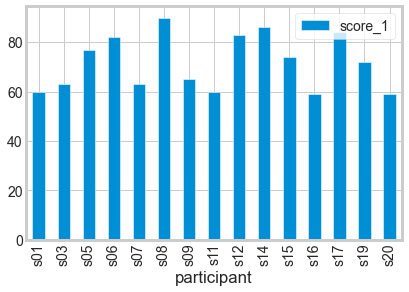

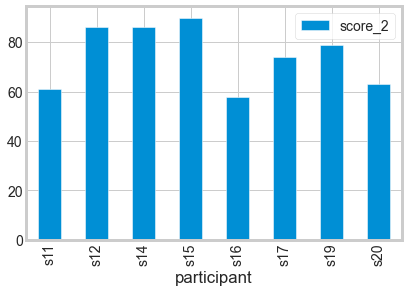

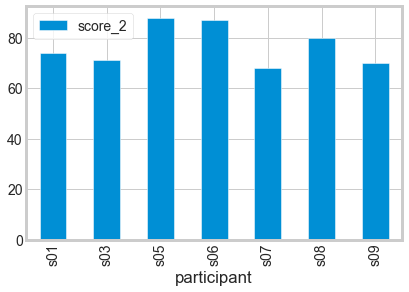

In [393]:
'''Here we plot the scores.'''

s_scores_1_bar = s_scores_1.plot.bar()

s_scores_2_s_bar = s_scores_2_s.plot.bar()

s_scores_2_d_bar = s_scores_2_d.plot.bar()

'''
#merge both games by participant:
s_scores = pd.merge(s_scores_1, s_scores_2,on='participant')

#label columns
s_scores.columns=['Game 1','Game 2']

s_scores'''

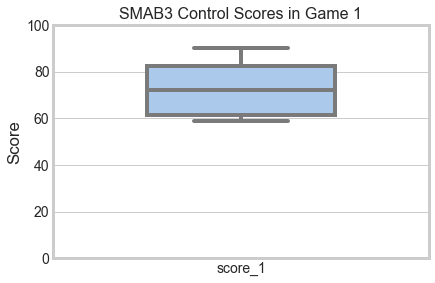

In [394]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores1_box = sns.boxplot( 
                 data=s_scores_1,
                 width=0.5,
                 palette="pastel")
s_scores1_box.axes.set_title("SMAB3 Control Scores in Game 1",
                    fontsize=16)

plot_file_name="s_score1_box.jpg"
 
plt.ylim(0, 100)
s_scores1_box.axes.set(ylabel='Score')

# save as jpeg
s_scores1_box.figure.savefig(plot_file_name,
                    format='jpeg')

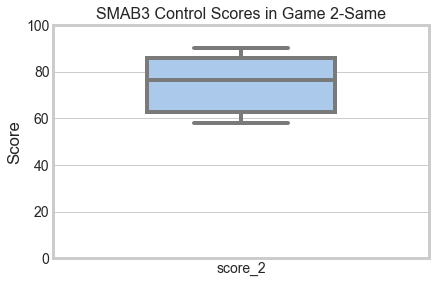

In [395]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores2s_box = sns.boxplot( 
                 data=s_scores_2_s,
                 width=0.5,
                 palette="pastel")
s_scores2s_box.axes.set_title("SMAB3 Control Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="s_score_2s_box.jpg"
 
plt.ylim(0, 100)
s_scores2s_box.axes.set(ylabel='Score')

# save as jpeg
s_scores2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

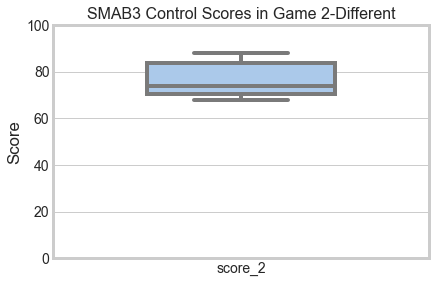

In [396]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores2d_box = sns.boxplot( 
                 data=s_scores_2_d,
                 width=0.5,
                 palette="pastel")
s_scores2d_box.axes.set_title("SMAB3 Control Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="s_score_2d_box.jpg"
 
plt.ylim(0, 100)
s_scores2d_box.axes.set(ylabel='Score')

# save as jpeg
s_scores2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [397]:
'''
#get a p value comparing scores in game 1 to scores in game 2
s_scores_p = sp.stats.ttest_rel(s_scores['Game 1'],s_scores['Game 2'])


s_scores_p


s_scores_2_bar = s_scores_2.plot.bar()



#new_index = ('s01_g1','s01_g2','s02_g1','s03_g1','s03_g2','s05_g1','s05_g2', 
                               #'s06_g1','s06_g2','s07_g1','s07_g2','s08_g1','s08_g2','s09_g1','s09_g2')
#s_combo.index = new_index'''

"\n#get a p value comparing scores in game 1 to scores in game 2\ns_scores_p = sp.stats.ttest_rel(s_scores['Game 1'],s_scores['Game 2'])\n\n\ns_scores_p\n\n\ns_scores_2_bar = s_scores_2.plot.bar()\n\n\n\n#new_index = ('s01_g1','s01_g2','s02_g1','s03_g1','s03_g2','s05_g1','s05_g2', \n                               #'s06_g1','s06_g2','s07_g1','s07_g2','s08_g1','s08_g2','s09_g1','s09_g2')\n#s_combo.index = new_index"

In [398]:
'''Here we look at the means, standard deviations, and medians of the scores in games 1 and 2.'''

s_scores_1_mean = s_scores_1.mean()

In [399]:
s_scores_1_std = s_scores_1.std()

In [45]:
s_scores_1_mean, s_scores_1_std

(score_1    71.8
 dtype: float64,
 score_1    11.181618
 dtype: float64)

In [46]:
s_scores_2s_mean = s_scores_2_s.mean()

In [47]:
s_scores_2s_std = s_scores_2_s.std()

In [48]:
s_scores_2d_mean = s_scores_2_d.mean()

In [49]:
s_scores_2d_std = s_scores_2_d.std()

In [50]:
s_scores_2s_mean, s_scores_2s_std

(score_2    74.625
 dtype: float64,
 score_2    12.603146
 dtype: float64)

In [51]:
s_scores_2d_mean, s_scores_2d_std

(score_2    76.857143
 dtype: float64,
 score_2    8.214389
 dtype: float64)

In [52]:
sp.stats.ttest_ind(s_scores_2_s, s_scores_2_d)

Ttest_indResult(statistic=array([-0.39928923]), pvalue=array([0.69616225]))

In [53]:
'''Here we separate the dataframes of game 1 and game 2 for each subject.'''


s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
s03_p1_g1, s03_p1_g2 = separate_df(s03, 's')
s05_p1_g1, s05_p1_g2 = separate_df(s05, 's')
s06_p1_g1, s06_p1_g2 = separate_df(s06, 's')
s07_p1_g1, s07_p1_g2 = separate_df(s07, 's')
s08_p1_g1, s08_p1_g2 = separate_df(s08, 's')
s09_p1_g1, s09_p1_g2 = separate_df(s09, 's')
s11_p1_g1, s11_p1_g2 = separate_df(s11, 's')
s12_p1_g1, s12_p1_g2 = separate_df(s12, 's')
s15_p1_g1, s15_p1_g2 = separate_df(s15, 's')
s16_p1_g1, s16_p1_g2 = separate_df(s16, 's')
s17_p1_g1, s17_p1_g2 = separate_df(s17, 's')
s19_p1_g1, s19_p1_g2 = separate_df(s19, 's')
s20_p1_g1, s20_p1_g2 = separate_df(s20, 's')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

In [54]:
'''Here we check the arm-probability mappings in each game'''
s01_p1_g1_map = hole_prob_map(s01_p1_g1)
s01_p1_g2_map = hole_prob_map(s01_p1_g2)

s03_p1_g1_map = hole_prob_map(s03_p1_g1)
s03_p1_g2_map = hole_prob_map(s03_p1_g2)

s05_p1_g1_map = hole_prob_map(s05_p1_g1)
#s05_p1_g2_map = hole_prob_map(s05_p1_g2)

s07_p1_g1_map = hole_prob_map(s07_p1_g1)
s07_p1_g2_map = hole_prob_map(s07_p1_g2)

s08_p1_g1_map = hole_prob_map(s08_p1_g1)
s08_p1_g2_map = hole_prob_map(s08_p1_g2)

s09_p1_g1_map = hole_prob_map(s09_p1_g1)
s09_p1_g2_map = hole_prob_map(s09_p1_g2)

s11_p1_g1_map = hole_prob_map(s11_p1_g1)
s11_p1_g2_map = hole_prob_map(s11_p1_g2)

s12_p1_g1_map = hole_prob_map(s12_p1_g1)
s12_p1_g2_map = hole_prob_map(s12_p1_g2)

s15_p1_g1_map = hole_prob_map(s15_p1_g1)
s15_p1_g2_map = hole_prob_map(s15_p1_g2)

s16_p1_g1_map = hole_prob_map(s16_p1_g1)
s16_p1_g2_map = hole_prob_map(s16_p1_g2)

s17_p1_g1_map = hole_prob_map(s17_p1_g1)
#s17_p1_g2_map = hole_prob_map(s17_p1_g2)

In [55]:
s17_p1_g1_map

h1_prob  h2_prob  h3_prob
0       30       90       60

In [56]:
s17_p1_g2

game number  trial  player  arm  probability  reward      time  P1 score  \
200            2      1       1    2           90       1  1.561254         1   
202            2      2       1    2           90       1  1.062491         2   
204            2      4       1    2           90       1  0.934553         3   
206            2      6       1    2           90       1  0.838599         4   
208            2      8       1    2           90       0  0.797618         4   
..           ...    ...     ...  ...          ...     ...       ...       ...   
390            2    190       1    2           90       1  0.870584        71   
392            2    192       1    2           90       1  0.870584        72   
394            2    194       1    2           90       0  0.781628        72   
396            2    196       1    3           60       1  0.781626        73   
398            2    198       1    2           90       1  0.805615        74   

     P2 score  
200         0  
202         1  
204         2  
206         3  
208         4  
..        ...  
390        83  
392        83  
394        84  
396        85  
398        86  

[100 rows x 9 columns]

In [57]:
s01_p1_g2

game number  trial  player  arm  probability  reward      time  P1 score  \
200            2      1       1    2           90       1  4.426063         1   
202            2      2       1    3           30       1  2.593545         2   
204            2      3       1    1           60       0  2.968871         2   
206            2      4       1    2           90       1  2.554801         3   
208            2      5       1    2           90       1  2.727741         4   
..           ...    ...     ...  ...          ...     ...       ...       ...   
390            2     96       1    2           90       1  2.481864        70   
392            2     97       1    2           90       1  2.904003        71   
394            2     98       1    3           30       1  2.751020        72   
396            2     99       1    1           60       1  2.876227        73   
398            2    100       1    1           60       1  2.678057        74   

     P2 score  
200         0  
202         0  
204         1  
206         2  
208         3  
..        ...  
390        88  
392        89  
394        90  
396        91  
398        92  

[100 rows x 9 columns]

In [58]:
'''Here we count the number of times that each hole was selected by each subject in each game by calling value_counts'''


s01_p1_g1_count = s01_p1_g1['probability'].value_counts(sort=False)
s01_p1_g2_count = s01_p1_g2['probability'].value_counts(sort=False)
s03_p1_g1_count = s03_p1_g1['probability'].value_counts(sort=False)
s03_p1_g2_count = s03_p1_g2['probability'].value_counts(sort=False)
s05_p1_g1_count = s05_p1_g1['probability'].value_counts(sort=False)
s05_p1_g2_count = s05_p1_g2['probability'].value_counts(sort=False)
s06_p1_g1_count = s06_p1_g1['probability'].value_counts(sort=False)
s06_p1_g2_count = s06_p1_g2['probability'].value_counts(sort=False)
s07_p1_g1_count = s07_p1_g1['probability'].value_counts(sort=False)
s07_p1_g2_count = s07_p1_g2['probability'].value_counts(sort=False)
s08_p1_g1_count = s08_p1_g1['probability'].value_counts(sort=False)
s08_p1_g2_count = s08_p1_g2['probability'].value_counts(sort=False)
s09_p1_g1_count = s09_p1_g1['probability'].value_counts(sort=False)
s09_p1_g2_count = s09_p1_g2['probability'].value_counts(sort=False)
s11_p1_g1_count = s11_p1_g1['probability'].value_counts(sort=False)
s11_p1_g2_count = s11_p1_g2['probability'].value_counts(sort=False)
s12_p1_g1_count = s12_p1_g1['probability'].value_counts(sort=False)
s12_p1_g2_count = s12_p1_g2['probability'].value_counts(sort=False)
s14_p1_g1_count = s14_p1_g1['probability'].value_counts(sort=False)
s14_p1_g2_count = s14_p1_g2['probability'].value_counts(sort=False)
s15_p1_g1_count = s15_p1_g1['probability'].value_counts(sort=False)
s15_p1_g2_count = s15_p1_g2['probability'].value_counts(sort=False)
s16_p1_g1_count = s16_p1_g1['probability'].value_counts(sort=False)
s16_p1_g2_count = s16_p1_g2['probability'].value_counts(sort=False)
s17_p1_g1_count = s17_p1_g1['probability'].value_counts(sort=False)
s17_p1_g2_count = s17_p1_g2['probability'].value_counts(sort=False)
s19_p1_g1_count = s19_p1_g1['probability'].value_counts(sort=False)
s19_p1_g2_count = s19_p1_g2['probability'].value_counts(sort=False)
s20_p1_g1_count = s20_p1_g1['probability'].value_counts(sort=False)
s20_p1_g2_count = s20_p1_g2['probability'].value_counts(sort=False)

In [59]:
'''Here we create dataframes with the counts for game 1.'''

s_g1_counts = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count,s14_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count','s14_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count'])



#How to prevent NaN: df = df.fillna(0). This makes the value 0 if a hole was never selected by a subject.
s_g1_counts = s_g1_counts.fillna(0)

#print
s_g1_counts

30.0  60.0  90.0
s01_p1_g1_count    38    43    19
s03_p1_g1_count    28    38    34
s05_p1_g1_count    11    35    54
s06_p1_g1_count    11    13    76
s07_p1_g1_count    25    29    46
s08_p1_g1_count     2     6    92
s09_p1_g1_count    17    38    45
s11_p1_g1_count    30    34    36
s12_p1_g1_count     7    28    65
s14_p1_g1_count     2     1    97
s15_p1_g1_count    10    12    78
s16_p1_g1_count    25    39    36
s17_p1_g1_count     2     5    93
s19_p1_g1_count    20    23    57
s20_p1_g1_count    21    49    31

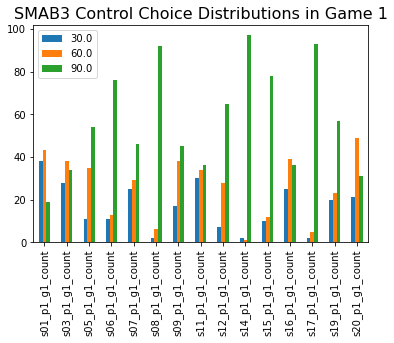

In [60]:
#Here we plot the value counts

s_g1_counts.sum(axis=1)


s_g1_counts_bar = s_g1_counts.plot.bar()

s_g1_counts_bar.axes.set_title("SMAB3 Control Choice Distributions in Game 1",
                    fontsize=16)

# save as jpeg
s_g1_counts_bar.figure.savefig("s_g1_counts_bar.jpg",
                    format='jpeg')

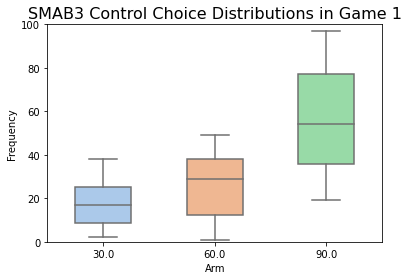

In [61]:
s_g1_counts_box = sns.boxplot( 
                 data=s_g1_counts, 
                 width=0.5,
                 palette="pastel")
s_g1_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="s_g1_counts_box.jpg"
 
plt.ylim(0, 100)
s_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [62]:
'''Here we get the mean and standard deviation of the number of selections of each hole where low is the 0th column and the 30% hole, 
med is the 1st column and the 60% hole, and high is the 2nd column and the 90% hole.'''


s_g1_low = np.mean(s_g1_counts.iloc[:,0])
s_g1_med = np.mean(s_g1_counts.iloc[:,1])
s_g1_high = np.mean(s_g1_counts.iloc[:,2])


s_g1_low_std = np.std(s_g1_counts.iloc[:,0])
s_g1_med_std = np.std(s_g1_counts.iloc[:,1])
s_g1_high_std = np.std(s_g1_counts.iloc[:,2])

In [63]:
s_g1_low, s_g1_med, s_g1_high

(16.6, 26.2, 57.266666666666666)

In [64]:
 s_g1_low_std, s_g1_med_std, s_g1_high_std

(10.886076734373438, 14.770240350109406, 24.208722027860585)

In [65]:
'''Here we create dataframes with the counts for game 2.'''


s_g2_counts = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count,
                            s11_p1_g2_count, s12_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count],
index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count', 's11_p1_g2_count', 
                                 's12_p1_g2_count', 's15_p1_g2_count', 's16_p1_g2_count','s17_p1_g2_count', 
                                 's19_p1_g2_count', 's20_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
s_g2_counts = s_g2_counts.fillna(0)

#print
s_g2_counts

s_g2_counts.sum(axis=1)

s01_p1_g2_count    100.0
s03_p1_g2_count    100.0
s05_p1_g2_count    100.0
s06_p1_g2_count    100.0
s07_p1_g2_count    100.0
s08_p1_g2_count    100.0
s09_p1_g2_count    100.0
s11_p1_g2_count    100.0
s12_p1_g2_count    100.0
s15_p1_g2_count    100.0
s16_p1_g2_count    100.0
s17_p1_g2_count    100.0
s19_p1_g2_count    100.0
s20_p1_g2_count    101.0
dtype: float64

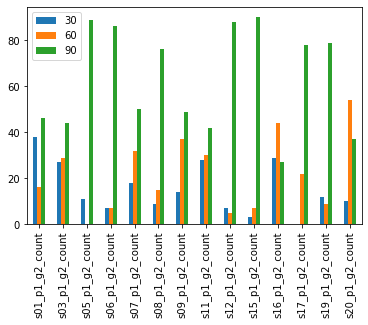

In [66]:
'''Here we plot the counts in game 2.'''

s_g2_counts_bar = s_g2_counts.plot.bar()

# save as jpeg
s_g2_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

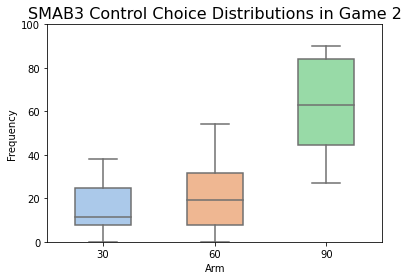

In [67]:
s_g2_counts_box = sns.boxplot( 
                 data=s_g2_counts, 
                 width=0.5,
                 palette="pastel")
s_g2_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="s_g2_counts_box.jpg"

plt.ylim(0, 100)
s_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [68]:
'''Here we get the mean and standard deviation of the number of times participants chose each hole.'''


s_g2_low = np.mean(s_g2_counts.iloc[:,0])
s_g2_med = np.mean(s_g2_counts.iloc[:,1])
s_g2_high = np.mean(s_g2_counts.iloc[:,2])


In [69]:
s_g2_low_std = np.std(s_g2_counts.iloc[:,0])
s_g2_med_std = np.std(s_g2_counts.iloc[:,1])
s_g2_high_std = np.std(s_g2_counts.iloc[:,2])



s_g2_low_std



s_g2_med_std



s_g2_high_std

21.773064243018535

In [70]:
'''Here we place the value counts for each hole for each game into separate numy arrays and compare them statistically.


import researchpy as rp


s_90_1 = np.array(s_g1_counts.iloc[:,2])
s_90_2 = np.array(s_g2_counts.iloc[:,2])

s_60_1 = np.array(s_g1_counts.iloc[:,1])
s_60_2 = np.array(s_g2_counts.iloc[:,1])


s_30_1 = np.array(s_g1_counts.iloc[:,0])
s_30_2 = np.array(s_g2_counts.iloc[:,0])

s_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)
s_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)
s_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)'''

'Here we place the value counts for each hole for each game into separate numy arrays and compare them statistically.\n\n\nimport researchpy as rp\n\n\ns_90_1 = np.array(s_g1_counts.iloc[:,2])\ns_90_2 = np.array(s_g2_counts.iloc[:,2])\n\ns_60_1 = np.array(s_g1_counts.iloc[:,1])\ns_60_2 = np.array(s_g2_counts.iloc[:,1])\n\n\ns_30_1 = np.array(s_g1_counts.iloc[:,0])\ns_30_2 = np.array(s_g2_counts.iloc[:,0])\n\ns_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)\ns_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)\ns_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)'

In [71]:
s01_p1_g1.reset_index(drop=True, inplace=True)

In [72]:
'Here we get the reaction times'
time_s_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_s_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [73]:
time_s_1 = reaction_time(s01_p1_g1, time_s_1)

In [74]:
time_s_1 = reaction_time(s03_p1_g1, time_s_1)
time_s_1 = reaction_time(s05_p1_g1, time_s_1)
time_s_1 = reaction_time(s06_p1_g1, time_s_1)
time_s_1 = reaction_time(s07_p1_g1, time_s_1)
time_s_1 = reaction_time(s08_p1_g1, time_s_1)
time_s_1 = reaction_time(s09_p1_g1, time_s_1)
time_s_1 = reaction_time(s11_p1_g1, time_s_1)
time_s_1 = reaction_time(s12_p1_g1, time_s_1)
time_s_1 = reaction_time(s15_p1_g1, time_s_1)
time_s_1 = reaction_time(s16_p1_g1, time_s_1)
time_s_1 = reaction_time(s17_p1_g1, time_s_1)
time_s_1 = reaction_time(s19_p1_g1, time_s_1)
#time_s_1 = reaction_time(s20_p1_g1, time_s_1)

In [75]:
time_s_2 = reaction_time(s03_p1_g2, time_s_2)
time_s_2 = reaction_time(s05_p1_g2, time_s_2)
time_s_2 = reaction_time(s06_p1_g2, time_s_2)
time_s_2 = reaction_time(s07_p1_g2, time_s_2)
time_s_2 = reaction_time(s08_p1_g2, time_s_2)
time_s_2 = reaction_time(s09_p1_g2, time_s_2)
time_s_2 = reaction_time(s11_p1_g2, time_s_2)
time_s_2 = reaction_time(s12_p1_g2, time_s_2)
time_s_2 = reaction_time(s15_p1_g2, time_s_2)
time_s_2 = reaction_time(s16_p1_g2, time_s_2)
time_s_2 = reaction_time(s17_p1_g2, time_s_2)
time_s_2 = reaction_time(s19_p1_g2, time_s_2)
#time_s_2 = reaction_time(s20_p1_g2, time_s_2)

In [76]:
sp.stats.ttest_rel(time_s_1['post win'], time_s_1['post loss'])

Ttest_relResult(statistic=-0.22232713395530926, pvalue=0.8277981973516864)

In [77]:
sp.stats.ttest_rel(time_s_2['post win'], time_s_2['post loss'])

Ttest_relResult(statistic=1.6133551404642006, pvalue=0.1349630881166298)

In [78]:
#sp.stats.ttest_rel(time_s_1['post loss'], time_s_2['post loss'])

In [79]:
s01_p1_g1.loc[0,'time']

11.22069836

In [80]:
post_win_time = []
post_loss_time = []
for index, row in s01_p1_g1.iterrows():
    if index > 0:
        prev_rew = s01_p1_g1.loc[index - 1, 'reward']
        if prev_rew == 1:
            post_win_time.append(s01_p1_g1.loc[index, 'time'])
        elif prev_rew == 0:
            post_loss_time.append(s01_p1_g1.loc[index, 'time'])

In [81]:
'''' if df.loc[index - 1, 'reward'] == 1.0:
            post_win.append(row['time'])
        elif df.loc[index - 1, 'reward'] == 0.0:
            post_loss.append(row['time'])'''

"' if df.loc[index - 1, 'reward'] == 1.0:\n            post_win.append(row['time'])\n        elif df.loc[index - 1, 'reward'] == 0.0:\n            post_loss.append(row['time'])"

In [82]:
'''Here we get the average reaction times for each subject in games 1 and 2'''
s01_p1_g1_t = s01_p1_g1['time'].mean()
s01_p1_g2_t = s01_p1_g2['time'].mean()

# SMAB4 Single Player Analysis

In [83]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.'''

df = organize_trial_by_trial_hand_code2('data/c01_gamedata_handcode.csv')
c01 = df
#c02_p1_g1_score,c02_p1_g2_score,c02_score_diff, c02_p1_g1_50,c02_p1_g2_50 = call_get_score(c02, 'c')
c01.head()

df = organize_trial_by_trial('data/c02_gamedata.csv')
c02 = df
c02_p1_g1_score,c02_p1_g2_score,c02_score_diff, c02_p1_g1_50,c02_p1_g2_50 = call_get_score(c02, 'c')
c02.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c03_gamedata.csv')
c03 = df
c03_p1_g1_score,c03_p1_g2_score,c03_score_diff, c03_p1_g1_50,c03_p1_g2_50 = call_get_score(c03, 'c')
c03.head()

df = organize_trial_by_trial_hand_code2('data/c04_gamedata_handcode.csv')
c04 = df
#c04_p1_g1_score,c04_p1_g2_score,c04_score_diff, c04_p1_g1_50,c04_p1_g2_50 = call_get_score(c04, 'c')
c04.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c05_gamedata.csv')
c05 = df
c05_p1_g1_score,c05_p1_g2_score,c05_score_diff, c05_p1_g1_50,c05_p1_g2_50 = call_get_score(c05, 'c')
c05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c06_gamedata.csv')
c06 = df
c06_p1_g1_score,c06_p1_g2_score,c06_score_diff, c06_p1_g1_50,c06_p1_g2_50 = call_get_score(c06, 'c')
c06.head()


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c07_gamedata.csv')
c07 = df
c07_p1_g1_score,c07_p1_g2_score,c07_score_diff, c07_p1_g1_50,c07_p1_g2_50 = 78, 86, 8, 34, 42 
#c07.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c09_gamedata.csv')
c09 = df
c09_p1_g1_score,c09_p1_g2_score,c09_score_diff, c09_p1_g1_50,c09_p1_g2_50 = call_get_score(c09, 'c')
c09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c10_gamedata.csv')
c10 = df
c10_p1_g1_score,c10_p1_g2_score,c10_score_diff, c10_p1_g1_50,c10_p1_g2_50 = call_get_score(c10, 'c')
c10.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c11_gamedata.csv')
c11 = df
c11_p1_g1_score,c11_p1_g2_score,c11_score_diff, c11_p1_g1_50,c11_p1_g2_50 = call_get_score(c11, 'c')
c11.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c12_gamedata2.csv')
c12 = df
c12_p1_g1_score,c12_p1_g2_score,c12_score_diff, c12_p1_g1_50,c12_p1_g2_50 = call_get_score(c12, 'c')
c12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c13_gamedata2.csv')
c13 = df
c13_p1_g1_score,c13_p1_g2_score,c13_score_diff, c13_p1_g1_50,c13_p1_g2_50 = call_get_score(c13, 'c')
c13.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c14_gamedata2.csv')
c14 = df
c14_p1_g1_score,c14_p1_g2_score,c14_score_diff, c14_p1_g1_50,c14_p1_g2_50 = call_get_score(c14, 'c')
c14.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c15_gamedata.csv')
c15 = df
c15_p1_g1_score,c15_p1_g2_score,c15_score_diff, c15_p1_g1_50,c15_p1_g2_50 = call_get_score(c15, 'c')


#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c16_gamedata2.csv')
c16 = df
c16_p1_g1_score,c16_p1_g2_score,c16_score_diff, c16_p1_g1_50,c16_p1_g2_50 = call_get_score(c16, 'c')
c16.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c17_gamedata2.csv')
c17 = df
c17_p1_g1_score,c17_p1_g2_score,c17_score_diff, c17_p1_g1_50,c17_p1_g2_50 = call_get_score(c17, 'c')
c17#in the s files, p2 is the confederate

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c18_gamedata.csv')
c18 = df
c18_p1_g1_score,c18_p1_g2_score,c18_score_diff, c18_p1_g1_50,c18_p1_g2_50 = call_get_score(c18, 'c')
c18#in the s files, p2 is the confederate



game number  trial  player  arm  probability  reward      time  P1 score  \
0              1      1       1    3           90       0  5.135425         0   
1              1      2       2    3           30       0  2.545789         1   
2              1      3       1    2           60       0  7.996138         1   
3              1      4       2    3           30       0  3.018310         2   
4              1      4       1    3           90       0  1.015114         2   
..           ...    ...     ...  ...          ...     ...       ...       ...   
395            2    196       2    3           30       0  3.947417        73   
396            2    197       1    1           30       0  3.995810        73   
397            2    198       2    3           30       0  2.867564        73   
398            2    199       1    3           90       0  3.397195        73   
399            2    200       2    3           30       0  2.818558        74   

     P2 score  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
395        35  
396        35  
397        35  
398        35  
399        35  

[400 rows x 9 columns]

In [84]:
c01_p1_counts, c01_p2_counts, c01_p1_probs, c01_p2_probs = handcode_calc_prob(c01)
c04_p1_counts, c04_p2_counts, c04_p1_probs, c04_p2_probs = handcode_calc_prob(c04)

In [85]:
c01_p1_probs

p1_h1      p1_h2      p1_h3
game 1  90.697674  58.823529  30.434783
game 2  85.483871  66.666667  18.181818

In [86]:
#NOT SURE
c01 = fill_in_prob(c01, 90,60,30,60,30,90,60,60,90,60,90,30)
c04 = fill_in_prob(c04, 90,60,30,60,30,90,30,60,90,60,90,30)

In [87]:
c01_p1_g1, c01_p1_g2 = separate_df(c01, 'c')
c04_p1_g1, c04_p1_g2 = separate_df(c04, 'c')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [88]:
c01_p1_g1_score = c01_p1_g1['reward'].sum()
c01_p1_g2_score = c01_p1_g2['reward'].sum()
c04_p1_g1_score = c04_p1_g1['reward'].sum()
c04_p1_g2_score = c04_p1_g2['reward'].sum()

In [89]:
'''Here we place the score differences between games 1 and 2 in pandas dataframes and get the mean.'''
'''
# In[119]:


score_diff_confederate = pd.DataFrame({'participant':['c01','c02', 'c03', 'c04'
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15','c16', 'c17','c18'], 'score_diff_confederate':
     [c02_score_diff, c03_score_diff,
      c05_score_diff, c06_score_diff, c09_score_diff, c10_score_diff, c11_score_diff, c12_score_diff, c13_score_diff, c14_score_diff, c15_score_diff, c16_score_diff, c17_score_diff, c18_score_diff ]})

score_diff_confederate

score_diff_confederate_mean = score_diff_confederate['score_diff_confederate'].mean()


score_diff_confederate_mean'''

"\n# In[119]:\n\n\nscore_diff_confederate = pd.DataFrame({'participant':['c01','c02', 'c03', 'c04'\n                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15','c16', 'c17','c18'], 'score_diff_confederate':\n     [c02_score_diff, c03_score_diff,\n      c05_score_diff, c06_score_diff, c09_score_diff, c10_score_diff, c11_score_diff, c12_score_diff, c13_score_diff, c14_score_diff, c15_score_diff, c16_score_diff, c17_score_diff, c18_score_diff ]})\n\nscore_diff_confederate\n\nscore_diff_confederate_mean = score_diff_confederate['score_diff_confederate'].mean()\n\n\nscore_diff_confederate_mean"

In [90]:
'''Here we place the scores in games 1 and 2 into dataframes.'''


#list out all the scores in game 1 by participant
c_scores_1 = pd.DataFrame({'participant':['c01','c02', 'c03', 'c04',
                               'c05', 'c06', 'c07', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18'], 'confederate_score_1':
     [c01_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score, c04_p1_g1_score, c05_p1_g1_score, c06_p1_g1_score,
      c07_p1_g1_score,
      c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, 
      c15_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score, c18_p1_g1_score]})
#to prevent an extra column that numbers each row:
c_scores_1.set_index('participant', inplace=True, drop=True)

#print
c_scores_1


#list out all the scores in game 2 by participant
c_scores_2_d = pd.DataFrame({'participant':['c01','c02', 'c03', 'c04', 
                              'c05', 'c06', 'c09', 'c10', 'c11'], 'confederate_score_2':
                           [c01_p1_g2_score, c02_p1_g2_score, c03_p1_g2_score, c04_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score]})

#to prevent an extra column that numbers each row:
c_scores_2_d.set_index('participant', inplace=True, drop=True)

c_scores_2_s = pd.DataFrame({'participant':['c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18'], 'confederate_score_2':
                           [c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c15_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score, c18_p1_g2_score]})

#to prevent an extra column that numbers each row:
c_scores_2_s.set_index('participant', inplace=True, drop=True)

'''
#list out all the scores in game 1 by participant
c_scores_1_50 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c15', 'c14', 'c16', 'c17', 'c18'], 'score_1_50':
     [c02_p1_g1_50, c03_p1_g1_50, c05_p1_g1_50,
      c06_p1_g1_50, c09_p1_g1_50, c10_p1_g1_50, c11_p1_g1_50, c12_p1_g1_50, c13_p1_g1_50, c14_p1_g1_50, c15_p1_g1_50,
      c16_p1_g1_50, c17_p1_g1_50, c18_p1_g1_50]})
#to prevent an extra column that numbers each row:
c_scores_1_50.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
c_scores_2_50 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17','c18'], 'score_1_50':
     [c02_p1_g2_50, c03_p1_g2_50, c05_p1_g2_50,
      c06_p1_g2_50, c09_p1_g2_50, c10_p1_g2_50, c11_p1_g2_50, c12_p1_g2_50, c13_p1_g2_50, c14_p1_g2_50, 
      c15_p1_g2_50,c16_p1_g2_50, c17_p1_g2_50, c18_p1_g2_50]})
c_scores_2_50.set_index('participant', inplace=True, drop=True)'''

"\n#list out all the scores in game 1 by participant\nc_scores_1_50 = pd.DataFrame({'participant':['c02', 'c03', \n                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c15', 'c14', 'c16', 'c17', 'c18'], 'score_1_50':\n     [c02_p1_g1_50, c03_p1_g1_50, c05_p1_g1_50,\n      c06_p1_g1_50, c09_p1_g1_50, c10_p1_g1_50, c11_p1_g1_50, c12_p1_g1_50, c13_p1_g1_50, c14_p1_g1_50, c15_p1_g1_50,\n      c16_p1_g1_50, c17_p1_g1_50, c18_p1_g1_50]})\n#to prevent an extra column that numbers each row:\nc_scores_1_50.set_index('participant', inplace=True, drop=True)\n\n#list out all the scores in game 2 by participant\nc_scores_2_50 = pd.DataFrame({'participant':['c02', 'c03', \n                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17','c18'], 'score_1_50':\n     [c02_p1_g2_50, c03_p1_g2_50, c05_p1_g2_50,\n      c06_p1_g2_50, c09_p1_g2_50, c10_p1_g2_50, c11_p1_g2_50, c12_p1_g2_50, c13_p1_g2_50, c14_p1_g2_50, \n      c15_p1_g2_50,c1

In [91]:
'''Here we combine the dataframes with the scores from the 2 games.
c_scores_50 = c_scores_1_50.merge(c_scores_2_50,right_index=True,left_index=True)
c_scores = c_scores_1.merge(c_scores_2,right_index=True,left_index=True)
c_combo = c_scores_50.merge(c_scores,right_index=True,left_index=True)

#rename columns
c_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]'''

'Here we combine the dataframes with the scores from the 2 games.\nc_scores_50 = c_scores_1_50.merge(c_scores_2_50,right_index=True,left_index=True)\nc_scores = c_scores_1.merge(c_scores_2,right_index=True,left_index=True)\nc_combo = c_scores_50.merge(c_scores,right_index=True,left_index=True)\n\n#rename columns\nc_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]'

In [92]:
'''Here we plot the scores in games 1 and 2.

c_scores_1_bar = c_scores_1.plot.bar()



c_scores_2_bar = c_scores_2.plot.bar()



#label columns
#c_scores.columns=['Game 1','Game 2']


c_scores'''

"Here we plot the scores in games 1 and 2.\n\nc_scores_1_bar = c_scores_1.plot.bar()\n\n\n\nc_scores_2_bar = c_scores_2.plot.bar()\n\n\n\n#label columns\n#c_scores.columns=['Game 1','Game 2']\n\n\nc_scores"

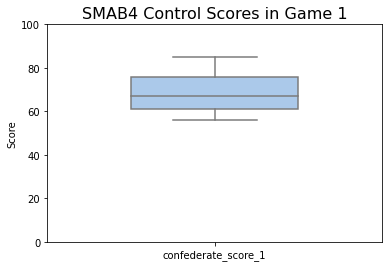

In [93]:
#c_scores1_box = c_scores_1.boxplot()
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))


c_scores1_box = sns.boxplot( 
                 data=c_scores_1, 
                 width=0.5,
                 palette="pastel")
c_scores1_box.axes.set_title("SMAB4 Control Scores in Game 1",
                    fontsize=16)

plot_file_name="c_g1_score_box.jpg"
 
plt.ylim(0, 100)
c_scores1_box.axes.set(ylabel='Score')

# save as jpeg
c_scores1_box.figure.savefig(plot_file_name,
                    format='jpeg')

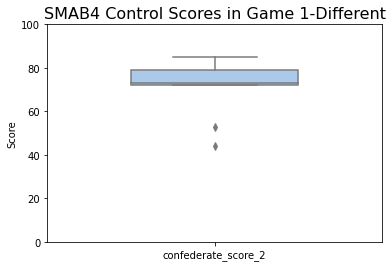

In [94]:
c_scores_2d_box = sns.boxplot( 
                 data=c_scores_2_d, 
                 width=0.5,
                 palette="pastel")
c_scores_2d_box.axes.set_title("SMAB4 Control Scores in Game 1-Different",
                    fontsize=16)

plot_file_name="c_g2d_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_2d_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

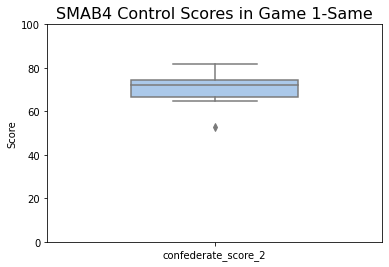

In [95]:
c_scores_2s_box = sns.boxplot( 
                 data=c_scores_2_s, 
                 width=0.5,
                 palette="pastel")
c_scores_2s_box.axes.set_title("SMAB4 Control Scores in Game 1-Same",
                    fontsize=16)

plot_file_name="c_g2s_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_2s_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [96]:
c_scores_2s_mean = c_scores_2_s.mean()

In [97]:
c_scores_2s_std = c_scores_2_s.std()

In [98]:
c_scores_2d_mean = c_scores_2_d.mean()

In [99]:
c_scores_2d_std = c_scores_2_d.std()

In [100]:
c_scores_2s_mean, c_scores_2s_std

(confederate_score_2    69.857143
 dtype: float64,
 confederate_score_2    9.191093
 dtype: float64)

In [101]:
c_scores_2d_mean, c_scores_2d_std

(confederate_score_2    70.555556
 dtype: float64,
 confederate_score_2    13.482499
 dtype: float64)

In [102]:
sp.stats.ttest_ind(c_scores_2_s, c_scores_2_d)

Ttest_indResult(statistic=array([-0.11709513]), pvalue=array([0.90844792]))

In [103]:
'''Here we make a boxplot with the scores in the first and second half of the games included
c_combo_box = sns.boxplot( 
                 data=c_combo, order = ['score_1_50','score_2_50','score_1','score_2'],
                 width=0.5,
                 palette="pastel")
c_combo_box.axes.set_title("SMAB4 Control Scores",
                    fontsize=16)

plot_file_name="c_score_box.jpg"
 
plt.ylim(0, 100)
c_combo_box.axes.set(ylabel='Score')

# save as jpeg
c_combo_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'Here we make a boxplot with the scores in the first and second half of the games included\nc_combo_box = sns.boxplot( \n                 data=c_combo, order = [\'score_1_50\',\'score_2_50\',\'score_1\',\'score_2\'],\n                 width=0.5,\n                 palette="pastel")\nc_combo_box.axes.set_title("SMAB4 Control Scores",\n                    fontsize=16)\n\nplot_file_name="c_score_box.jpg"\n \nplt.ylim(0, 100)\nc_combo_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nc_combo_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

In [104]:
'''Get the p value between the scores in games 1 and 2.

c_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])



c_scores_p


#plot bar graph of scores


c_scores_2_bar = c_scores_2.plot.bar()



#combine g1 and g2 to one dataframe
c_combo = c_scores_1.append(c_scores_2)



c_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',
                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':
     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})
c_combo.set_index('participant', inplace=True, drop=True)


#new_index = ('c02_g1','c02_g2','c03_g1','c03_g2','c04_g1','c04_g2','c05_g1','c05_g2','c06_g1','c06_g2','c09_g1','c09_g2','c10_g1','c10_g2','c11_g1','c11_g2','c12_g1','c12_g2','c13_g1','c13_g2','c14_g1','c14_g2','c16_g1','c16_g2','c17_g1','c17_g2')
#c_combo.index = new_index


c_combo = c_combo.sort_values(by=['participant'])'''

"Get the p value between the scores in games 1 and 2.\n\nc_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])\n\n\n\nc_scores_p\n\n\n#plot bar graph of scores\n\n\nc_scores_2_bar = c_scores_2.plot.bar()\n\n\n\n#combine g1 and g2 to one dataframe\nc_combo = c_scores_1.append(c_scores_2)\n\n\n\nc_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',\n                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':\n     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})\nc_combo.set_index('participant', inplace=True, drop=T

In [105]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
#colors = list(islice(cycle(['red','blue','green', 'yellow']),None,len(c_combo)))
#blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(c_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
#c_combo_bar = c_combo.plot(kind='bar',color=colors)

# Checking for outliars

In [106]:
#scatter plot
'''
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(c_combo['score_2_50'], c_combo['score_2'])
ax.set_xlabel('Score at trial 50')
ax.set_ylabel('Score at trial 100')
plt.show()'''

"\nfig, ax = plt.subplots(figsize=(16,8))\nax.scatter(c_combo['score_2_50'], c_combo['score_2'])\nax.set_xlabel('Score at trial 50')\nax.set_ylabel('Score at trial 100')\nplt.show()"

In [107]:
#calculate z score
#z = np.abs(stats.zscore(c_combo['score_2']))
#print(z)

In [108]:
#z = np.abs(stats.zscore(c_combo['score_2_50']))
#print(z)

In [109]:
'''Here we get the mean, median, and standard deviation of the scores in games 1 and 2.'''

c_scores_1_mean = c_scores_1.mean()


c_scores_1_mean

confederate_score_1    68.588235
dtype: float64

In [110]:
c_scores_1_std = c_scores_1.std()


c_scores_1_std

confederate_score_1    8.846319
dtype: float64

In [111]:
c_scores_1_mean, c_scores_1_std

(confederate_score_1    68.588235
 dtype: float64,
 confederate_score_1    8.846319
 dtype: float64)

In [112]:
'''
c_scores_2_mean = c_scores_2.mean()


# In[147]:


c_scores_2_mean'''

'\nc_scores_2_mean = c_scores_2.mean()\n\n\n# In[147]:\n\n\nc_scores_2_mean'

In [113]:
# In[148]:

'''
c_scores_2_std = c_scores_2.std()


# In[149]:


c_scores_2_std'''

'\nc_scores_2_std = c_scores_2.std()\n\n\n# In[149]:\n\n\nc_scores_2_std'

In [114]:
# In[150]:

'''
c_scores_med = c_scores.median()
c_scores_med'''

'\nc_scores_med = c_scores.median()\nc_scores_med'

In [115]:
'''Here we separate the dataframes into games 1 and 2.'''

#s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
c02_p1_g1, c02_p1_g2 = separate_df(c02, 'c')
c03_p1_g1, c03_p1_g2 = separate_df(c03, 'c')
c05_p1_g1, c05_p1_g2 = separate_df(c05, 'c')
c06_p1_g1, c06_p1_g2 = separate_df(c06, 'c')
c07_p1_g1, c07_p1_g2 = separate_df(c07, 'c')
c09_p1_g1, c09_p1_g2 = separate_df(c09, 'c')
c10_p1_g1, c10_p1_g2 = separate_df(c10, 'c')
c11_p1_g1, c11_p1_g2 = separate_df(c11, 'c')
c12_p1_g1, c12_p1_g2 = separate_df(c12, 'c')
c13_p1_g1, c13_p1_g2 = separate_df(c13, 'c')
c14_p1_g1, c14_p1_g2 = separate_df(c14, 'c')
c15_p1_g1, c15_p1_g2 = separate_df(c15, 'c')
c16_p1_g1, c16_p1_g2 = separate_df(c16, 'c')
c17_p1_g1, c17_p1_g2 = separate_df(c17, 'c')
c18_p1_g1, c18_p1_g2 = separate_df(c18, 'c')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

In [116]:
c02_p1_g1_map = hole_prob_map(c02_p1_g1)
c02_p1_g2_map = hole_prob_map(c02_p1_g2)

c03_p1_g1_map = hole_prob_map(c03_p1_g1)
c03_p1_g2_map = hole_prob_map(c03_p1_g2)

c07_p1_g1_map = hole_prob_map(c07_p1_g1)
c07_p1_g2_map = hole_prob_map(c07_p1_g2)

c05_p1_g1_map = hole_prob_map(c05_p1_g1)
c05_p1_g2_map = hole_prob_map(c05_p1_g2)

c06_p1_g1_map = hole_prob_map(c06_p1_g1)
c06_p1_g2_map = hole_prob_map(c06_p1_g2)

c09_p1_g1_map = hole_prob_map(c09_p1_g1)
c09_p1_g2_map = hole_prob_map(c09_p1_g2)

c10_p1_g1_map = hole_prob_map(c10_p1_g1)
c10_p1_g2_map = hole_prob_map(c10_p1_g2)

c11_p1_g1_map = hole_prob_map(c11_p1_g1)
c11_p1_g2_map = hole_prob_map(c11_p1_g2)

c12_p1_g1_map = hole_prob_map(c12_p1_g1)
c12_p1_g2_map = hole_prob_map(c12_p1_g2)

c13_p1_g1_map = hole_prob_map(c13_p1_g1)
c13_p1_g2_map = hole_prob_map(c13_p1_g2)

c14_p1_g1_map = hole_prob_map(c14_p1_g1)
c14_p1_g2_map = hole_prob_map(c14_p1_g2)

c15_p1_g1_map = hole_prob_map(c15_p1_g1)
c15_p1_g2_map = hole_prob_map(c15_p1_g2)

c16_p1_g1_map = hole_prob_map(c16_p1_g1)
c16_p1_g2_map = hole_prob_map(c16_p1_g2)

c17_p1_g1_map = hole_prob_map(c17_p1_g1)
c17_p1_g2_map = hole_prob_map(c17_p1_g2)

c18_p1_g1_map = hole_prob_map(c18_p1_g1)
c18_p1_g2_map = hole_prob_map(c18_p1_g2)

In [117]:
#call fix_reward on all of the files imported with '300' to fix the reward column
c12_p1_g1 = fix_reward(c12_p1_g1)
c12_p1_g2 = fix_reward(c12_p1_g2)
c13_p1_g1 = fix_reward(c13_p1_g1)
c13_p1_g2 = fix_reward(c13_p1_g2)
c14_p1_g1 = fix_reward(c14_p1_g1)
c14_p1_g2 = fix_reward(c14_p1_g2)
c15_p1_g1 = fix_reward(c15_p1_g1)
c15_p1_g2 = fix_reward(c15_p1_g2)
c16_p1_g1 = fix_reward(c16_p1_g1)
c16_p1_g2 = fix_reward(c16_p1_g2)
c17_p1_g1 = fix_reward(c17_p1_g1)
c17_p1_g2 = fix_reward(c17_p1_g2)
c18_p1_g1 = fix_reward(c18_p1_g1)
c18_p1_g2 = fix_reward(c18_p1_g2)


In [118]:
'''Here we count the number of times each hole was chosen in each game and place it in an array.'''

c01_p1_g1_count = c01_p1_g1['probability'].value_counts(sort=False)
c01_p1_g2_count = c01_p1_g2['probability'].value_counts(sort=False)
c02_p1_g1_count = c02_p1_g1['probability'].value_counts(sort=False)
c02_p1_g2_count = c02_p1_g2['probability'].value_counts(sort=False)
c03_p1_g1_count = c03_p1_g1['probability'].value_counts(sort=False)
c03_p1_g2_count = c03_p1_g2['probability'].value_counts(sort=False)
c04_p1_g1_count = c04_p1_g1['probability'].value_counts(sort=False)
c04_p1_g2_count = c04_p1_g2['probability'].value_counts(sort=False)
c05_p1_g1_count = c05_p1_g1['probability'].value_counts(sort=False)
c05_p1_g2_count = c05_p1_g2['probability'].value_counts(sort=False)
c06_p1_g1_count = c06_p1_g1['probability'].value_counts(sort=False)
c06_p1_g2_count = c06_p1_g2['probability'].value_counts(sort=False)
c07_p1_g1_count = c07_p1_g1['probability'].value_counts(sort=False)
c07_p1_g2_count = c07_p1_g2['probability'].value_counts(sort=False)
c09_p1_g1_count = c09_p1_g1['probability'].value_counts(sort=False)
c09_p1_g2_count = c09_p1_g2['probability'].value_counts(sort=False)
c10_p1_g1_count = c10_p1_g1['probability'].value_counts(sort=False)
c10_p1_g2_count = c10_p1_g2['probability'].value_counts(sort=False)
c11_p1_g1_count = c11_p1_g1['probability'].value_counts(sort=False)
c11_p1_g2_count = c11_p1_g2['probability'].value_counts(sort=False)
c12_p1_g1_count = c12_p1_g1['probability'].value_counts(sort=False)
c12_p1_g2_count = c12_p1_g2['probability'].value_counts(sort=False)
c13_p1_g1_count = c13_p1_g1['probability'].value_counts(sort=False)
c13_p1_g2_count = c13_p1_g2['probability'].value_counts(sort=False)
c14_p1_g1_count = c14_p1_g1['probability'].value_counts(sort=False)
c14_p1_g2_count = c14_p1_g2['probability'].value_counts(sort=False)
c15_p1_g1_count = c15_p1_g1['probability'].value_counts(sort=False)
c15_p1_g2_count = c15_p1_g2['probability'].value_counts(sort=False)
c16_p1_g1_count = c16_p1_g1['probability'].value_counts(sort=False)
c16_p1_g2_count = c16_p1_g2['probability'].value_counts(sort=False)
c17_p1_g1_count = c17_p1_g1['probability'].value_counts(sort=False)
c17_p1_g2_count = c17_p1_g2['probability'].value_counts(sort=False)
c18_p1_g1_count = c18_p1_g1['probability'].value_counts(sort=False)
c18_p1_g2_count = c18_p1_g2['probability'].value_counts(sort=False)

In [119]:
c09_p1_g2_count

30    45
60    37
90    18
Name: probability, dtype: int64

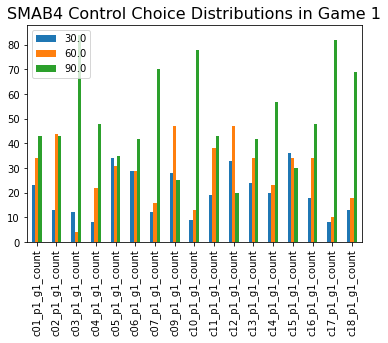

In [120]:
'''Here we place the number of times each hole was chosen by each subject in game 1 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''


c_g1_counts = pd.DataFrame([c01_p1_g1_count, c02_p1_g1_count, c03_p1_g1_count, c04_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c07_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c15_p1_g1_count,
                            c16_p1_g1_count, c17_p1_g1_count, c18_p1_g1_count],
         index=['c01_p1_g1_count', 'c02_p1_g1_count', 'c03_p1_g1_count', 'c04_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c07_p1_g1_count','c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c15_p1_g1_count', 'c16_p1_g1_count', 'c17_p1_g1_count', 'c18_p1_g1_count'])


#How to prevent NaN: df = df.fillna(0)
c_g1_counts = c_g1_counts.fillna(0)

#print
c_g1_counts


c_g1_counts.sum(axis=1)


c_g1_counts_bar = c_g1_counts.plot.bar()

c_g1_counts_bar.axes.set_title("SMAB4 Control Choice Distributions in Game 1",
                    fontsize=16)

# save as jpeg
c_g1_counts_bar.figure.savefig('c_g1_counts_bar.jpg',
                    format='jpeg',
                    dpi=100)

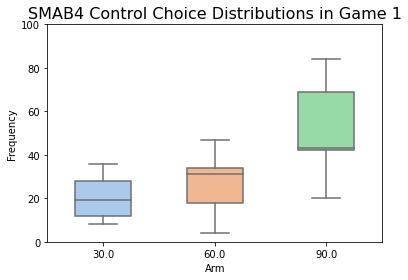

In [121]:
c_g1_counts_box = sns.boxplot( 
                 data=c_g1_counts, 
                 width=0.5,
                 palette="pastel")
c_g1_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="c_g1_counts_box.jpg"
 
plt.ylim(0, 100)
c_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [122]:
# In[158]:


#0 is low (30), 1 is med (60), 2 is high (90)
c_g1_low = np.mean(c_g1_counts.iloc[:,0])
c_g1_med = np.mean(c_g1_counts.iloc[:,1])
c_g1_high = np.mean(c_g1_counts.iloc[:,2])

In [123]:
c_g1_low_std = np.std(c_g1_counts.iloc[:,0])
c_g1_med_std = np.std(c_g1_counts.iloc[:,1])
c_g1_high_std = np.std(c_g1_counts.iloc[:,2])

In [124]:
c_g1_low, c_g1_med, c_g1_high

(19.941176470588236, 28.11764705882353, 50.529411764705884)

In [125]:
c_g1_low_std, c_g1_med_std, c_g1_high_std

(9.174585024981939, 12.512969050695677, 19.10071648504879)

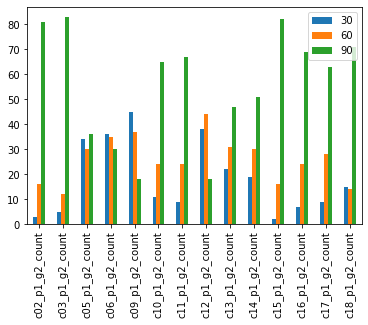

In [126]:
'''Here we place the number of times each hole was chosen by each subject in game 2 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''

c_g2_counts = pd.DataFrame([c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count, 
                            c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c15_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count, c18_p1_g2_count],
         index=['c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count', 'c12_p1_g2_count', 'c13_p1_g2_count', 
                'c14_p1_g2_count', 'c15_p1_g2_count',
                'c16_p1_g2_count', 'c17_p1_g2_count', 'c18_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
c_g2_counts = c_g2_counts.fillna(0)

#print
c_g2_counts


c_g2_counts.sum(axis=1)


c_g2_counts_bar = c_g2_counts.plot.bar()

# save as jpeg
c_g2_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

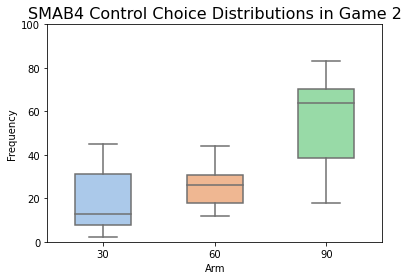

In [127]:
c_g2_counts_box = sns.boxplot( 
                 data=c_g2_counts, 
                 width=0.5,
                 palette="pastel")
c_g2_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="c_g2_counts_box.jpg"
 
plt.ylim(0, 100)
c_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [128]:
c_g2_low = np.mean(c_g2_counts.iloc[:,0])
c_g2_med = np.mean(c_g2_counts.iloc[:,1])
c_g2_high = np.mean(c_g2_counts.iloc[:,2])


c_g2_low


c_g2_med


c_g2_high

55.785714285714285

In [129]:
c_g2_low_std = np.std(c_g2_counts.iloc[:,0])
c_g2_med_std = np.std(c_g2_counts.iloc[:,1])
c_g2_high_std = np.std(c_g2_counts.iloc[:,2])


c_g2_low_std


c_g2_med_std


c_g2_high_std 

21.948571614534906

In [130]:
'''Here we convert the value counts of each hole in each game into Numpy arrays.'''

import researchpy as rp


c_90_1 = np.array(c_g1_counts.iloc[:,2])
c_90_2 = np.array(c_g2_counts.iloc[:,2])


# In[182]:


c_90_1


# In[183]:


c_90_2


# In[184]:


c_60_1 = np.array(c_g1_counts.iloc[:,1])
c_60_2 = np.array(c_g2_counts.iloc[:,1])


# In[185]:


c_60_1


# In[186]:


c_60_2


# In[187]:


c_30_1 = np.array(c_g1_counts.iloc[:,0])
c_30_2 = np.array(c_g2_counts.iloc[:,0])


# In[188]:


c_30_1


# In[189]:


c_30_2

array([ 3,  5, 34, 36, 45, 11,  9, 38, 22, 19,  2,  7,  9, 15])

In [131]:
'''Here we do a t-test comparing the hole choices in games 1 and 2.



c_90_p = sp.stats.ttest_rel(c_90_1,c_90_2)
c_60_p = sp.stats.ttest_rel(c_60_1,c_60_2)
c_30_p = sp.stats.ttest_rel(c_30_1,c_30_2)


# In[191]:


c_90_p


# In[192]:


c_60_p


# In[193]:


c_30_p


# In[194]:


#maximizing and matching?


# In[195]:


#maximizing and matching?'''

'Here we do a t-test comparing the hole choices in games 1 and 2.\n\n\n\nc_90_p = sp.stats.ttest_rel(c_90_1,c_90_2)\nc_60_p = sp.stats.ttest_rel(c_60_1,c_60_2)\nc_30_p = sp.stats.ttest_rel(c_30_1,c_30_2)\n\n\n# In[191]:\n\n\nc_90_p\n\n\n# In[192]:\n\n\nc_60_p\n\n\n# In[193]:\n\n\nc_30_p\n\n\n# In[194]:\n\n\n#maximizing and matching?\n\n\n# In[195]:\n\n\n#maximizing and matching?'

In [132]:
'Here we get the reaction times'
'NEED to fix rewards for SMAB4'
time_c_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_c_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [133]:
time_c_1 = reaction_time(c02_p1_g1, time_c_1)
time_c_1 = reaction_time(c03_p1_g1, time_c_1)
time_c_1 = reaction_time(c05_p1_g1, time_c_1)
time_c_1 = reaction_time(c06_p1_g1, time_c_1)
time_c_1 = reaction_time(c09_p1_g1, time_c_1)
time_c_1 = reaction_time(c10_p1_g1, time_c_1)
time_c_1 = reaction_time(c11_p1_g1, time_c_1)
time_c_1 = reaction_time(c12_p1_g1, time_c_1)
time_c_1 = reaction_time(c13_p1_g1, time_c_1)
time_c_1 = reaction_time(c14_p1_g1, time_c_1)
time_c_1 = reaction_time(c15_p1_g1, time_c_1)
time_c_1 = reaction_time(c16_p1_g1, time_c_1)
time_c_1 = reaction_time(c17_p1_g1, time_c_1)
time_c_1 = reaction_time(c18_p1_g1, time_c_1)

In [134]:
time_c_1

session  post win  post loss
0   c02_p1_g1  4.310843   4.483266
1   c03_p1_g1  3.233906   3.376468
2   c05_p1_g1  3.831172   3.794584
3   c06_p1_g1  3.367617   3.455480
4   c09_p1_g1  3.567952   3.557236
5   c10_p1_g1  3.213206   3.451479
6   c11_p1_g1  3.615086   4.014988
7   c12_p1_g1  3.721225   3.878290
8   c13_p1_g1  3.484952   3.786906
9   c14_p1_g1  3.311307   3.439066
10  c15_p1_g1  4.145404   4.108843
11  c16_p1_g1  3.262908   3.320465
12  c17_p1_g1  2.647495   2.769062
13  c18_p1_g1  3.518423   3.607217

In [135]:
time_c_2 = reaction_time(c02_p1_g2, time_c_2)
time_c_2 = reaction_time(c03_p1_g2, time_c_2)
time_c_2 = reaction_time(c05_p1_g2, time_c_2)
time_c_2 = reaction_time(c06_p1_g2, time_c_2)
time_c_2 = reaction_time(c09_p1_g2, time_c_2)
time_c_2 = reaction_time(c10_p1_g2, time_c_2)
time_c_2 = reaction_time(c11_p1_g2, time_c_2)
time_c_2 = reaction_time(c12_p1_g2, time_c_2)
time_c_2 = reaction_time(c13_p1_g2, time_c_2)
time_c_2 = reaction_time(c14_p1_g2, time_c_2)
time_c_2 = reaction_time(c15_p1_g2, time_c_2)
time_c_2 = reaction_time(c16_p1_g2, time_c_2)
time_c_2 = reaction_time(c17_p1_g2, time_c_2)
time_c_2 = reaction_time(c18_p1_g2, time_c_2)

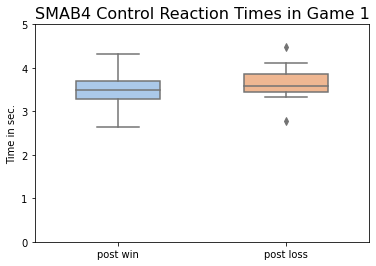

In [136]:
times_c_g1_box = sns.boxplot( 
                 data=time_c_1, 
                 width=0.5,
                 palette="pastel")
times_c_g1_box.axes.set_title("SMAB4 Control Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_c_g1_box.jpg"
 
plt.ylim(0, 5)
times_c_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_c_g1_box.figure.savefig(plot_file_name,format='jpeg')

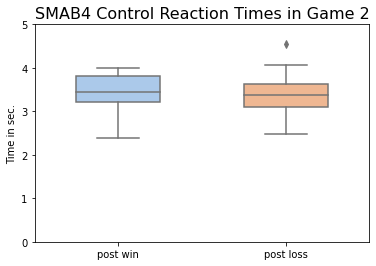

In [137]:
times_c_g2_box = sns.boxplot( 
                 data=time_c_2, 
                 width=0.5,
                 palette="pastel")
times_c_g2_box.axes.set_title("SMAB4 Control Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_c_g2_box.jpg"
 
plt.ylim(0, 5)
times_c_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_c_g2_box.figure.savefig(plot_file_name,format='jpeg')

In [138]:
np.mean(time_c_1)

post win     3.516535
post loss    3.645953
dtype: float64

In [139]:
np.mean(time_c_2)

post win     3.423937
post loss    3.395499
dtype: float64

In [140]:
np.std(time_c_1)

post win     0.399678
post loss    0.398324
dtype: float64

In [141]:
np.std(time_c_2)

post win     0.436234
post loss    0.536441
dtype: float64

In [142]:
sp.stats.ttest_rel(time_c_1['post win'],time_c_1['post loss'])

Ttest_relResult(statistic=-3.895131923798299, pvalue=0.0018430668367242645)

In [143]:
sp.stats.ttest_rel(time_c_2['post win'],time_c_2['post loss'])

Ttest_relResult(statistic=0.3910238480157525, pvalue=0.7021128497106475)

In [144]:
#not working
#sp.stats.ttest_rel(time_c_1['post win'],time_c_2['post win'])

In [145]:
#not working
#sp.stats.ttest_rel(time_c_1['post loss'],time_c_2['post loss'])

# Single Player Analysis of SMAB 3 and SMAB 4

## Testing for differences between SMAB 3 and SMAB 4

In [146]:
'''scores, games 1 vs 2, by condition, in smab 3 vs 4. So 2 x 2 x 2, 
mixed-measures anova or GLM, with game as a repeated measure. 
You could also collapse game and just do a simple 2x2 anova to get a sense of the data.'''

'scores, games 1 vs 2, by condition, in smab 3 vs 4. So 2 x 2 x 2, \nmixed-measures anova or GLM, with game as a repeated measure. \nYou could also collapse game and just do a simple 2x2 anova to get a sense of the data.'

In [147]:
import pingouin as pg

In [148]:
'''Here we place the scores in games 1 and 2 into dataframes, combining SMAB3 and SMAB4.'''

# NEED: add scores at trial 50



#list out all the scores in game 1 by participant
control_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
control_scores_1.set_index('participant', inplace=True, drop=True)

#print
control_scores_1


#list out all the scores in game 2 by participant
control_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_2':
        [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score, 
         c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
control_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
control_scores_2


#merge both games by participant:
control_scores = pd.merge(control_scores_1, control_scores_2, on = 'participant')



#label columns
control_scores.columns=['Game 1','Game 2']




control_scores



control_scores.sum(axis=1)


# In[203]:


control_scores=control_scores.sum(axis=1)


# In[204]:


control_scores.sort_values(inplace=True)


# In[205]:


control_scores


# In[206]:


control_scores_1_mean = control_scores_1.mean()


# In[207]:


control_scores_1_mean


# In[208]:


control_scores_1_std = control_scores_1.std()


# In[209]:


control_scores_1_std


# In[210]:


control_scores_2_mean = control_scores_2.mean()


# In[211]:


control_scores_2_mean


# In[212]:


control_scores_2_std = control_scores_2.std()


# In[213]:


control_scores_2_std


# In[214]:


control_scores_med = control_scores.median()
control_scores_med


# In[215]:


control_scores_p = sp.stats.ttest_rel(control_scores_1,control_scores_2)


# In[216]:


control_scores_p


# In[217]:


def degreesOfFreedom(X, Y):
    s1 = (stdev(X)**2)
    s2 = (stdev(Y)**2)
    df = (s1 / len(X) + s2 / len(Y))**2 / ((s1 / len(X))**2 / (len(X) - 1) + (s2 / len(Y))**2 / len(Y) - 1)
    return(df)


# 

# # Maximizing/Matching CONTROL

# In[218]:


s_g1_counts


# In[219]:


s_g1_counts.sum(axis=1)


# In[220]:


s_g2_counts


# In[221]:


s_g2_counts.sum(axis=1)


# In[222]:


c_g1_counts


# In[223]:


c_g1_counts.sum(axis=1)


# In[224]:


c_g2_counts


# In[225]:


c_g2_counts.sum(axis=1)

/Users/baryosef/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


c02_p1_g2_count    100
c03_p1_g2_count    100
c05_p1_g2_count    100
c06_p1_g2_count    101
c09_p1_g2_count    100
c10_p1_g2_count    100
c11_p1_g2_count    100
c12_p1_g2_count    100
c13_p1_g2_count    100
c14_p1_g2_count    100
c15_p1_g2_count    100
c16_p1_g2_count    100
c17_p1_g2_count    100
c18_p1_g2_count    100
dtype: int64

In [149]:
#combine control_score_2 and control_score_1
control_scores = control_scores_1.merge(control_scores_2,right_index=True,left_index=True)

In [150]:
control_scores

control_score_1  control_score_2
participant                                  
s01                       60               74
s03                       63               71
s05                       77               88
s06                       82               87
s07                       63               68
s08                       90               80
s09                       65               70
s11                       60               61
s12                       83               86
s15                       74               90
s16                       59               58
s17                       84               74
s19                       72               79
s20                       59               63
c02                       74               85
c03                       79               73
c05                       61               72
c06                       59               53
c09                       61               44
c10                       81               79
c11                       69               82
c12                       59               53
c13                       64               68
c14                       67               65
c16                       70               72
c17                       85               75

In [151]:
#convert from wide-format to long-format
#pd.melt(control_scores,id_vars=0, value_vars=['control_score_1','control_score_2'],ignore_index=False)

control_scores = pd.melt(control_scores,ignore_index=False)

In [152]:
subjects = control_scores.index.to_numpy()


experiment = np.array([])

for i in subjects:
    if [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
control_scores['experiment'] = experiment

In [153]:
experiment

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4.])

In [154]:
control_scores.reset_index()

participant         variable  value  experiment
0          s01  control_score_1     60         3.0
1          s03  control_score_1     63         3.0
2          s05  control_score_1     77         3.0
3          s06  control_score_1     82         3.0
4          s07  control_score_1     63         3.0
5          s08  control_score_1     90         3.0
6          s09  control_score_1     65         3.0
7          s11  control_score_1     60         3.0
8          s12  control_score_1     83         3.0
9          s15  control_score_1     74         3.0
10         s16  control_score_1     59         3.0
11         s17  control_score_1     84         3.0
12         s19  control_score_1     72         3.0
13         s20  control_score_1     59         3.0
14         c02  control_score_1     74         4.0
15         c03  control_score_1     79         4.0
16         c05  control_score_1     61         4.0
17         c06  control_score_1     59         4.0
18         c09  control_score_1     61         4.0
19         c10  control_score_1     81         4.0
20         c11  control_score_1     69         4.0
21         c12  control_score_1     59         4.0
22         c13  control_score_1     64         4.0
23         c14  control_score_1     67         4.0
24         c16  control_score_1     70         4.0
25         c17  control_score_1     85         4.0
26         s01  control_score_2     74         3.0
27         s03  control_score_2     71         3.0
28         s05  control_score_2     88         3.0
29         s06  control_score_2     87         3.0
30         s07  control_score_2     68         3.0
31         s08  control_score_2     80         3.0
32         s09  control_score_2     70         3.0
33         s11  control_score_2     61         3.0
34         s12  control_score_2     86         3.0
35         s15  control_score_2     90         3.0
36         s16  control_score_2     58         3.0
37         s17  control_score_2     74         3.0
38         s19  control_score_2     79         3.0
39         s20  control_score_2     63         3.0
40         c02  control_score_2     85         4.0
41         c03  control_score_2     73         4.0
42         c05  control_score_2     72         4.0
43         c06  control_score_2     53         4.0
44         c09  control_score_2     44         4.0
45         c10  control_score_2     79         4.0
46         c11  control_score_2     82         4.0
47         c12  control_score_2     53         4.0
48         c13  control_score_2     68         4.0
49         c14  control_score_2     65         4.0
50         c16  control_score_2     72         4.0
51         c17  control_score_2     75         4.0

In [155]:
'''Here we conduct a 2 x 2 mixed measures ANOVA to compare the scores in games 1 and 2'''
pg.mixed_anova(data=control_scores, dv='value', between='experiment', within='variable', subject='participant')

Source          SS  DF1  DF2          MS         F     p-unc  \
0   experiment  217.994505    1   24  217.994505  1.102856  0.304101   
1     variable   48.076923    1   24   48.076923  1.374951  0.252471   
2  Interaction   74.732601    1   24   74.732601  2.137277  0.156729   

        np2  eps  
0  0.043933  NaN  
1  0.054185  1.0  
2  0.081771  NaN

In [156]:
import patsy
import statsmodels.api as sm

In [157]:
'''Here we conduct a linear regression to compare the scores in games 1 and 2'''
outcome_1,predictors_1 = patsy.dmatrices("value ~ variable + experiment", control_scores)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.152
Date:                Tue, 03 Nov 2020   Prob (F-statistic):              0.324
Time:                        21:17:04   Log-Likelihood:                -195.71
No. Observations:                  52   AIC:                             397.4
Df Residuals:                      49   BIC:                             403.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [158]:
'''Here we place the hole counts from into dataframes, combining SMAB3 and SMAB4.'''


control_counts_g1 = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count,c02_p1_g1_count, c03_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c16_p1_g1_count, c17_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count','c02_p1_g1_count', 'c03_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c16_p1_g1_count', 'c17_p1_g1_count'])




control_counts_g1


# In[228]:


control_counts_g2 = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count,
                            s11_p1_g2_count, s12_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count,c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count, c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count],
index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count', 's11_p1_g2_count', 
                                 's12_p1_g2_count', 's15_p1_g2_count', 's16_p1_g2_count','s17_p1_g2_count', 
                                 's19_p1_g2_count', 's20_p1_g2_count','c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count', 'c12_p1_g2_count', 'c13_p1_g2_count', 'c14_p1_g2_count', 
                'c16_p1_g2_count', 'c17_p1_g2_count'])


# In[229]:


control_counts_g2

30    60    90
s01_p1_g2_count  38.0  16.0  46.0
s03_p1_g2_count  27.0  29.0  44.0
s05_p1_g2_count  11.0   NaN  89.0
s06_p1_g2_count   7.0   7.0  86.0
s07_p1_g2_count  18.0  32.0  50.0
s08_p1_g2_count   9.0  15.0  76.0
s09_p1_g2_count  14.0  37.0  49.0
s11_p1_g2_count  28.0  30.0  42.0
s12_p1_g2_count   7.0   5.0  88.0
s15_p1_g2_count   3.0   7.0  90.0
s16_p1_g2_count  29.0  44.0  27.0
s17_p1_g2_count   NaN  22.0  78.0
s19_p1_g2_count  12.0   9.0  79.0
s20_p1_g2_count  10.0  54.0  37.0
c02_p1_g2_count   3.0  16.0  81.0
c03_p1_g2_count   5.0  12.0  83.0
c05_p1_g2_count  34.0  30.0  36.0
c06_p1_g2_count  36.0  35.0  30.0
c09_p1_g2_count  45.0  37.0  18.0
c10_p1_g2_count  11.0  24.0  65.0
c11_p1_g2_count   9.0  24.0  67.0
c12_p1_g2_count  38.0  44.0  18.0
c13_p1_g2_count  22.0  31.0  47.0
c14_p1_g2_count  19.0  30.0  51.0
c16_p1_g2_count   7.0  24.0  69.0
c17_p1_g2_count   9.0  28.0  63.0

In [159]:
subjects_1 = control_counts_g1.index.to_numpy()

In [160]:
#combine control_counts_2 and control_counts_1

#modify the index to be only participant
subjects_1 = control_counts_g1.index.to_numpy()
subjects_2 = control_counts_g2.index.to_numpy()

subjects_new1 = np.array([])
subjects_new2 = np.array([])

ii = 0
for i in subjects_1:
    subjects_new1 = np.append(subjects_new1,subjects_1[ii][0:3])
    ii = ii +1
    
iii = 0
for i in subjects_2:
    subjects_new2 = np.append(subjects_new2,subjects_2[iii][0:3])
    iii = iii +1

control_counts_g1.index = subjects_new1
control_counts_g2.index = subjects_new2

control_counts = control_counts_g1.merge(control_counts_g2,right_index=True,left_index=True)

In [161]:
control_counts = pd.melt(control_counts,ignore_index=False)

In [162]:
control_counts

variable  value
s01     30_x   38.0
s03     30_x   28.0
s05     30_x   11.0
s06     30_x   11.0
s07     30_x   25.0
..       ...    ...
c12     90_y   18.0
c13     90_y   47.0
c14     90_y   51.0
c16     90_y   69.0
c17     90_y   63.0

[156 rows x 2 columns]

In [163]:
length = len(control_counts['variable'][0])
control_counts['variable'][0][length-1]

'x'

In [164]:
#clean up control_counts
#modify 'variable' to be only '30','60', or '90' and add a column 'game' specifying the game #
variable = control_counts['variable'].to_numpy()

choice = np.array([])
game = np.array([])

ii = 0
for i in variable:
    length = len(variable[ii])
    if variable[ii][length - 1] == 'x':
        game = np.append(game,'1')
    elif variable[ii][len(variable[ii]) - 1] == 'y':
        game = np.append(game,'2')
    choice = np.append(choice,variable[ii][0:2])
    ii = ii +1
    
control_counts['variable'] = choice
control_counts['game'] = game

In [165]:
control_counts

variable  value game
s01       30   38.0    1
s03       30   28.0    1
s05       30   11.0    1
s06       30   11.0    1
s07       30   25.0    1
..       ...    ...  ...
c12       90   18.0    2
c13       90   47.0    2
c14       90   51.0    2
c16       90   69.0    2
c17       90   63.0    2

[156 rows x 3 columns]

In [166]:
# In[230]:


#Here we compare the choice distributions to idealized models of two decision-making strategies: 
#matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
#and maximizing would be always choosing the high reward hole.


# In[231]:


#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://urldefense.com/v3/__https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX94Xg7JRI$ . *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://urldefense.com/v3/__https://en.wikipedia.org/wiki/Jensen**BShannon_divergence__;4oCT!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9SSBIvMc$ 
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.


# In[232]:


#Are ppl using a strategy similar to their partner's? This functions calls jsd for p1 and for p2. *UNFINISHED* 
#DO NOT USE.
#calls jsd for p1 and p2 and for p1 and p2 with the mean
#def compare_strat(p1,p2):
    #strat = jsd(p1,p2)
   # comp_1 = jsd(p1,[j_g1_low,j_g1_med,j_g1_high])
    #comp_2 = jsd(p2,[j_g1_low,j_g1_med,j_g1_high])
    #return strat, comp_1, comp_2


# In[233]:


#Idealized probability distributions to use for comparison. You can change these or add more models.

maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,90/180 * 100]
random = [30/90 * 100,30/90 * 100,30/90 * 100]
social = [1/3 * 100,1/3 * 100, 1/3 * 100]


# In[234]:


#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize) #(p, q)
    matchi = jsd(counts,match)
    rando = jsd(counts,random)
    soci = jsd(counts, social)
    return maxi,matchi,rando,soci


# In[235]:


from scipy import stats


# In[236]:


#if same, 0
#test = jsd(counts,maximize)


# In[237]:


#test


# In[238]:


def check_type(df,*social):
    types = pd.DataFrame(index=['type'])

In [167]:
# In[239]:

#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match,s01_g1_rand,s01_g1_soc = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match,s01_g2_rand,s01_g2_soc = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match,s03_g1_rand,s03_g1_soc = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match,s03_g2_rand,s03_g2_soc = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match,s05_g1_rand,s05_g1_soc= call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match,s05_g2_rand,s05_g2_soc = call_jsd([11, 0, 89])
s06_g1_max,s06_g1_match,s06_g1_rand,s06_g1_soc = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match,s06_g2_rand,s06_g2_soc = call_jsd(s06_p1_g2_count)
s07_g1_max,s07_g1_match,s07_g1_rand,s07_g1_soc = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match,s07_g2_rand,s07_g2_soc = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match,s08_g1_rand,s08_g1_soc = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match,s08_g2_rand,s08_g2_soc = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match,s09_g1_rand,s09_g1_soc = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match,s09_g2_rand,s09_g2_soc = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match,s11_g1_rand,s11_g1_soc = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match,s11_g2_rand,s11_g2_soc = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match,s12_g1_rand,s12_g1_soc = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match,s12_g2_rand,s12_g2_soc = call_jsd(s12_p1_g2_count)
s15_g1_max,s15_g1_match,s15_g1_rand,s15_g1_soc = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match,s15_g2_rand,s15_g2_soc = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match,s16_g1_rand,s16_g1_soc = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match,s16_g2_rand,s16_g2_soc = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match,s17_g1_rand,s17_g1_soc = call_jsd(s17_p1_g1_count)
s17_g2_max,s17_g2_match,s17_g2_rand,s17_g2_soc = call_jsd([0,22,78])
s19_g1_max,s19_g1_match,s19_g1_rand,s19_g1_soc = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match,s19_g2_rand,s19_g2_soc = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match,s20_g1_rand,s20_g1_soc = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match,s20_g2_rand,s20_g2_soc = call_jsd(s20_p1_g2_count)
c02_g1_max,c02_g1_match,c02_g1_rand,c02_g1_soc = call_jsd(c02_p1_g1_count)
c02_g2_max,c02_g2_match,c02_g2_rand,c02_g2_soc = call_jsd(c02_p1_g2_count)
c03_g1_max,c03_g1_match,c03_g1_rand,c03_g1_soc = call_jsd(c03_p1_g1_count)
c03_g2_max,c03_g2_match,c03_g2_rand,c03_g2_soc = call_jsd(c03_p1_g2_count)
c05_g1_max,c05_g1_match,c05_g1_rand,c05_g1_soc = call_jsd(c05_p1_g1_count)
c05_g2_max,c05_g2_match,c05_g2_rand,c05_g2_soc = call_jsd(c05_p1_g2_count)
c06_g1_max,c06_g1_match,c06_g1_rand,c06_g1_soc = call_jsd(c06_p1_g1_count)
c06_g2_max,c06_g2_match,c06_g2_rand,c06_g2_soc = call_jsd(c06_p1_g1_count)
c09_g1_max,c09_g1_match,c09_g1_rand,c09_g1_soc = call_jsd(c09_p1_g1_count)
c09_g2_max,c09_g2_match,c09_g2_rand,c09_g2_soc = call_jsd(c09_p1_g2_count)
c10_g1_max,c10_g1_match,c10_g1_rand,c10_g1_soc = call_jsd(c10_p1_g1_count)
c10_g2_max,c10_g2_match,c10_g2_rand,c10_g2_soc = call_jsd(c10_p1_g2_count)
c11_g1_max,c11_g1_match,c11_g1_rand,c11_g1_soc = call_jsd(c11_p1_g1_count)
c11_g2_max,c11_g2_match,c11_g2_rand,c11_g2_soc= call_jsd(c11_p1_g2_count)
c12_g1_max,c12_g1_match,c12_g1_rand,c12_g1_soc = call_jsd(c12_p1_g1_count)
c12_g2_max,c12_g2_match,c12_g2_rand,c12_g2_soc = call_jsd(c12_p1_g2_count)
c13_g1_max,c13_g1_match,c13_g1_rand,c13_g1_soc  = call_jsd(c13_p1_g1_count)
c13_g2_max,c13_g2_match,c13_g2_rand,c13_g2_soc = call_jsd(c13_p1_g2_count)
c14_g1_max,c14_g1_match,c14_g1_rand,c14_g1_soc = call_jsd(c14_p1_g1_count)
c14_g2_max,c14_g2_match,c14_g2_rand,c14_g2_soc = call_jsd(c14_p1_g2_count)
c16_g1_max,c16_g1_match,c16_g1_rand,c16_g1_soc = call_jsd(c16_p1_g1_count)
c16_g2_max,c16_g2_match,c16_g2_rand,c16_g2_soc = call_jsd(c16_p1_g2_count)
c17_g1_max,c17_g1_match,c17_g1_rand,c17_g1_soc = call_jsd(c17_p1_g1_count)
c17_g2_max,c17_g2_match,c17_g2_rand,c17_g2_soc = call_jsd(c17_p1_g2_count)

In [168]:
# In[ ]:


#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, 
                                      s19_g1_max, s20_g1_max, c02_g1_max, c03_g1_max, c05_g1_max, c06_g1_max, 
                                      c09_g1_max, c10_g1_max, c11_g1_max, c12_g1_max, c13_g1_max, c14_g1_max, 
                                      c16_g1_max, c17_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, 
                               s12_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, 
                               s20_g1_match, c02_g1_match, c03_g1_match, c05_g1_match, c06_g1_match, 
                                      c09_g1_match, c10_g1_match, c11_g1_match, c12_g1_match, c13_g1_match, c14_g1_match, 
                                      c16_g1_match, c17_g1_match],
                    'rand':[s01_g1_rand,s03_g1_rand,s05_g1_rand,s06_g1_rand,s07_g1_rand,s08_g1_rand,
                                s09_g1_rand, s11_g1_rand, s12_g1_rand, s15_g1_rand, s16_g1_rand, s17_g1_rand, 
                                      s19_g1_rand, s20_g1_rand, c02_g1_rand, c03_g1_rand, c05_g1_rand, c06_g1_rand, 
                                      c09_g1_rand, c10_g1_rand, c11_g1_rand, c12_g1_rand, c13_g1_rand, c14_g1_rand, 
                                      c16_g1_rand, c17_g1_rand],
                        'soc':[s01_g1_soc,s03_g1_soc,s05_g1_soc,s06_g1_soc,s07_g1_soc,s08_g1_soc,
                                s09_g1_soc, s11_g1_soc, s12_g1_soc, s15_g1_soc, s16_g1_soc, s17_g1_soc, 
                                      s19_g1_soc, s20_g1_soc, c02_g1_soc, c03_g1_soc, c05_g1_soc, c06_g1_soc, 
                                      c09_g1_soc, c10_g1_soc, c11_g1_soc, c12_g1_soc, c13_g1_soc, c14_g1_soc, 
                                      c16_g1_soc, c17_g1_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20', 'c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'])

In [169]:
# In[ ]:


#closer to 0 = closer to that pure strategy
control_jsd_g1


# In[ ]:


# get the column name of min values in every row
strategy_control_jsd_g1 = control_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g1)


# In[ ]:


strategy_control_jsd_g1.value_counts()


# In[ ]:


#control_types_g1 = check_type(control_jsd_g1)


# In[ ]:


#control_types_g1.drop([0])


# In[ ]:


#(control_types_g1 == 'maxi').sum()


# In[ ]:


#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g2 = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, s11_g2_max, s12_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, 
                                      s19_g2_max, s20_g2_max, c02_g2_max, c03_g2_max, c05_g2_max, c06_g2_max, 
                                      c09_g2_max, c10_g2_max, c11_g2_max, c12_g2_max, c13_g2_max, c14_g2_max, 
                                      c16_g2_max, c17_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match
                               ,s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, s11_g2_match, 
                               s12_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, 
                               s20_g2_match, c02_g2_match, c03_g2_match, c05_g2_match, c06_g2_match, 
                                      c09_g2_match, c10_g2_match, c11_g2_match, c12_g2_match, c13_g2_match, c14_g2_match, 
                                      c16_g2_match, c17_g2_match],
                    'rand':[s01_g2_rand,s03_g2_rand,s05_g2_rand,s06_g2_rand,s07_g2_rand,s08_g2_rand,
                                s09_g2_rand, s11_g2_rand, s12_g2_rand, s15_g2_rand, s16_g2_rand, s17_g2_rand, 
                                      s19_g2_rand, s20_g2_rand, c02_g2_rand, c03_g2_rand, c05_g2_rand, c06_g2_rand, 
                                      c09_g2_rand, c10_g2_rand, c11_g2_rand, c12_g2_rand, c13_g2_rand, c14_g2_rand, 
                                      c16_g2_rand, c17_g2_rand],
                        'soc':[s01_g2_soc,s03_g2_soc,s05_g2_soc,s06_g2_soc,s07_g2_soc,s08_g2_soc,
                                s09_g2_soc, s11_g2_soc, s12_g2_soc, s15_g2_soc, s16_g2_soc, s17_g2_soc, 
                                      s19_g2_soc, s20_g2_soc, c02_g2_soc, c03_g2_soc, c05_g2_soc, c06_g2_soc, 
                                      c09_g2_soc, c10_g2_soc, c11_g2_soc, c12_g2_soc, c13_g2_soc, c14_g2_soc, 
                                      c16_g2_soc, c17_g2_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20', 'c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'])

min values of row are at following columns :
s01     rand
s03     rand
s05    match
s06    match
s07    match
s08      max
s09    match
s11     rand
s12    match
s15    match
s16     rand
s17      max
s19    match
s20     rand
c02    match
c03      max
c05     rand
c06     rand
c09     rand
c10    match
c11    match
c12     rand
c13    match
c14    match
c16    match
c17    match
dtype: object


In [170]:
# In[ ]:


control_jsd_g2


# In[ ]:


# get the column name of min values in every row
strategy_control_jsd_g2 = control_jsd_g2.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g2)


# In[ ]:


minValues_control_jsd_g2 = control_jsd_g2.min()
 
print('minimum value in each column : ')
print(minValues_control_jsd_g2)


# In[ ]:


maxValues_control_jsd_g2 = control_jsd_g2.max()
 
print('maximum value in each column : ')
print(maxValues_control_jsd_g2)


# In[ ]:


strategy_control_jsd_g2.value_counts()


# In[ ]:


#control_types_g2 = check_type(control_jsd_g2)


# In[ ]:


#control_types_g2.drop([0])


# In[ ]:


#(control_types_g2 == 'maxi').sum()


# In[ ]:


#how different max and match dists are from eachother
#neither max or match(?)
#threshold = jsd(maximize,match)

min values of row are at following columns :
s01     rand
s03     rand
s05      max
s06      max
s07    match
s08    match
s09    match
s11     rand
s12      max
s15      max
s16     rand
s17    match
s19    match
s20    match
c02    match
c03      max
c05     rand
c06     rand
c09     rand
c10    match
c11    match
c12     rand
c13    match
c14    match
c16    match
c17    match
dtype: object
minimum value in each column : 
max      0.035974
match    0.000196
rand     0.000712
soc      0.000712
dtype: float64
maximum value in each column : 
max      0.441162
match    0.146174
rand     0.210697
soc      0.210697
dtype: float64


match    13
rand      8
max       5
dtype: int64

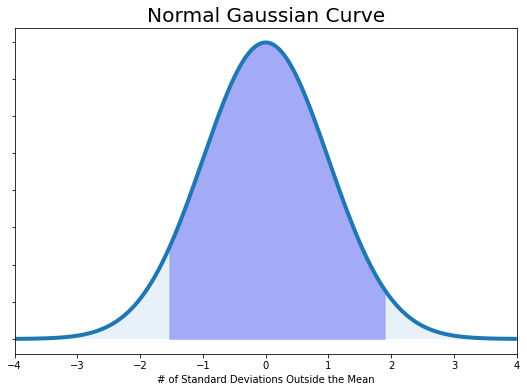

In [171]:
# In[ ]:


import matplotlib.lines as mlines


# In[ ]:


#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              


# In[ ]:


import itertools


# In[ ]:


#Here I print the means of the JSD values in each condition, just to see what they are.'''


# In[ ]:


#run t test to see sig between max and match per game
#put in box plot
control_jsd_g1.mean()


# In[ ]:


control_jsd_g1.std()


# In[ ]:


control_jsd_g2.mean()


# In[ ]:


control_jsd_g2.std()


# # Control z-scores

# In[ ]:


sp.stats.zscore(control_jsd_g1['max'])


# In[ ]:


sp.stats.zscore(control_jsd_g2['max'])


# In[ ]:


sp.stats.zscore(control_jsd_g1['match'])


# In[ ]:


sp.stats.zscore(control_jsd_g2['match'])


# In[ ]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# if using a Jupyter notebook, inlcude:
get_ipython().run_line_magic('matplotlib', 'inline')


# In[ ]:


mu = 0.217806 
sigma = 0.118674
x1 = 0.035604
x2 = 0.442841


# In[ ]:


# calculate the z-transform
z1 = ( x1 - mu ) / sigma
z2 = ( x2 - mu ) / sigma


# In[ ]:


x = np.arange(z1, z2, 0.001) # range of x in spec
x_all = np.arange(-10, 10, 0.001) # entire range of x, both in and out of spec
# mean = 0, stddev = 1, since Z-transform was calculated
y = norm.pdf(x,0,1)
y2 = norm.pdf(x_all,0,1)


# In[ ]:


# build the plot
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use('fivethirtyeight')
ax.plot(x_all,y2)

ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.fill_between(x_all,y2,0, alpha=0.1)
ax.set_xlim([-4,4])
ax.set_xlabel('# of Standard Deviations Outside the Mean')
ax.set_yticklabels([])
ax.set_title('Normal Gaussian Curve')

plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
plt.show()

In [172]:
# # Control strategy stats 

# In[ ]:


control_jsd_g1.dropna(inplace = True) 


# # Max strategy

# In[ ]:


control_max_g1 = control_jsd_g1.loc[ : , 'max' ]


# In[ ]:


control_max_g1


# In[ ]:


control_max_g2 = control_jsd_g2.loc[ : , 'max' ]


# In[ ]:


control_max_g2


# In[ ]:


control_max_g1_mean = control_max_g1.mean()


# In[ ]:


control_max_g1_mean


# In[ ]:


control_max_g1_std = control_max_g1.std()


# In[ ]:


control_max_g1_std


# In[ ]:


control_max_g2_mean = control_max_g2.mean()


# In[ ]:


control_max_g2_mean


# In[ ]:


control_max_g2_std = control_max_g2.std()
control_max_g2_std


# Max T-Test 

# In[ ]:


control_max_p = sp.stats.ttest_rel(control_max_g1,control_max_g2)


# In[ ]:


control_max_p


# # Match strategy

# In[ ]:


control_match_g1 = control_jsd_g1.loc[ : , 'match' ]


# In[ ]:


control_match_g1


# In[ ]:


control_match_g2 = control_jsd_g2.loc[ : , 'match' ]


# In[ ]:


control_match_g2


# In[ ]:


control_match_g1_mean = control_match_g1.mean()


# In[ ]:


control_match_g1_mean


# In[ ]:


control_match_g1_std = control_match_g1.std()


# In[ ]:


control_match_g1_std


# In[ ]:


control_match_g2_mean = control_match_g2.mean()


# In[ ]:


control_match_g2_mean


# In[ ]:


control_match_g2_std = control_match_g2.std()


# In[ ]:


control_match_g2_std


# In[ ]:


control_match_p = sp.stats.ttest_rel(control_match_g1,control_match_g2)


# In[ ]:


control_match_p


# # Random strategy

# In[ ]:


control_rand_g1 = control_jsd_g1.loc[ : , 'rand' ]


# In[ ]:


control_rand_g1


# In[ ]:


control_rand_g2 = control_jsd_g2.loc[ : , 'rand' ]


# In[ ]:


control_rand_g2


# In[ ]:


control_rand_g1_mean = control_rand_g1.mean()


# In[ ]:


control_rand_g1_mean


# In[ ]:


control_rand_g1_std = control_rand_g1.std()


# In[ ]:


control_rand_g1_std


# In[ ]:


control_rand_g2_mean = control_rand_g2.mean()


# In[ ]:


control_rand_g2_mean


# In[ ]:


control_rand_g2_std = control_rand_g2.std()
control_rand_g2_std


# In[ ]:


control_rand_p = sp.stats.ttest_rel(control_rand_g1,control_rand_g2)


# In[ ]:


control_rand_p


# # Social strategy

# In[ ]:


control_soc_g1 = control_jsd_g1.loc[ : , 'soc' ]


# In[ ]:


control_soc_g1


# In[ ]:


control_soc_g2 = control_jsd_g2.loc[ : , 'soc' ]


# In[ ]:


control_soc_g2


# In[ ]:


control_soc_g1_mean = control_soc_g1.mean()


# In[ ]:


control_soc_g1_mean


# In[ ]:


control_soc_g1_std = control_soc_g1.std()


# In[ ]:


control_soc_g1_std


# In[ ]:


control_soc_g2_mean = control_soc_g2.mean()


# In[ ]:


control_soc_g2_mean


# In[ ]:


control_soc_g2_std = control_soc_g2.std()


# In[ ]:


control_soc_g2_std


# In[ ]:


control_soc_p = sp.stats.ttest_rel(control_soc_g1,control_soc_g2)


# In[ ]:


control_soc_p


# In[ ]:


#control_scores_p = sp.stats.ttest_rel(control_scores['Game 1'],control_scores['Game 2'])


# In[ ]:


#control_scores_p


# In[ ]:





# In[ ]:

Ttest_relResult(statistic=-1.7048426096367608, pvalue=0.1006219906937588)

In [173]:
import matplotlib.patches as mpatches


# In[ ]:


#,'orange','green','blue','pink','purple','peru','cyan','red','lightcoral','orange','darkorange','green','palegreen','blue', 'peru','cyan', 'red','lightcoral', 'orange','darkorange','green','palegreen','blue','palegreen','blue']


# In[ ]:


#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
#colors_jsd_j = ['red','lightcoral','red','darkred','green','red',
             # 'blue','darkblue','hotblue','blue','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_control_g1_ego = ['red','red','red','red','red','blue','red','red','red','red',
                         'red','blue','red','red',
              'red', 'blue','red', 'red','red', 'red','red','red','red','red','red','red']


colors_jsd_control_g2_ego = ['red','red','blue','blue','red','red','red','red','blue','blue',
                         'red','red','red','red',
              'red', 'blue','red', 'red','red', 'red','red','red','red','red','red','red']


colors_jsd_control_g1_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green']

colors_jsd_control_g2_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green']

#markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
       #   'o','v','o','v','o','v','o','v']

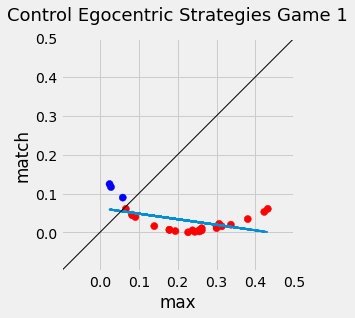

In [174]:
# # Graphs

# In[ ]:


#Here I try to plot the JSD Values. Continued below under 'JSD with gender.


# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

control_ego_jsd_g1_plot = control_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_control_g1_ego)
plt.title('Control Egocentric Strategies Game 1', fontsize=18, y=1.05)
control_ego_jsd_g1_plot.plot(control_jsd_g1['max'], m*control_jsd_g1['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
control_ego_jsd_g1_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_1.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()

In [175]:
# In[ ]:


'''ontrol_ego_jsd_g1_plot = control_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_control_g1_ego)

hist, xbins,ybins = control_ego_jsd_g1_plot.figure.histogram(y,x, bins=range(6))
x,y = np.meshgrid(xbins[:-1], ybins[:-1])
x = x[hist != 0]; y = y[hist != 0]
z   = hist[hist != 0]


fig, ax = plt.subplots()
ax.scatter(x,y, s=49, alpha=0.4)

for i in range(len(z)):
    ax.annotate(str(int(z[i])), xy=(x[i],y[i]), xytext=(4,0), 
                textcoords="offset points" )

plt.show()'''


# In[ ]:



'''#under line = matching (closer to 0)
#plots of atual jsd values

m, b = np.polyfit(control_jsd_g1['rand'], control_jsd_g1['soc'], 1)

control_joint_jsd_g1_plot = control_jsd_g1.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_control_g1_joint)
plt.title('Control Social Strategies Game 1', fontsize=18, y=1.05)
control_joint_jsd_g2_plot.plot(control_jsd_g1['rand'], m*control_jsd_g1['soc'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
control_joint_jsd_g1_plot.add_line(line1)


F.set_figsize_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
Size = F.get_size_inches()
plt.savefig('control_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()



'''

'#under line = matching (closer to 0)\n#plots of atual jsd values\n\nm, b = np.polyfit(control_jsd_g1[\'rand\'], control_jsd_g1[\'soc\'], 1)\n\ncontrol_joint_jsd_g1_plot = control_jsd_g1.plot.scatter(x=\'rand\',y=\'soc\',s=50,color=colors_jsd_control_g1_joint)\nplt.title(\'Control Social Strategies Game 1\', fontsize=18, y=1.05)\ncontrol_joint_jsd_g2_plot.plot(control_jsd_g1[\'rand\'], m*control_jsd_g1[\'soc\'] + b, linewidth=2)\nplt.xticks(np.arange(0, 1, step=0.1))\nplt.yticks(np.arange(0, 1, step=0.1))\n#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color=\'red\')\n#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])\n\n#plt.xlabel(\'Match\')\n#plt.ylabel(\'Maximize\')\n\nplt.ylim(-.1, .5)\nplt.xlim(-.1, .5)\n\n#make axes equal length\nplt.gca().set_aspect(\'equal\', adjustable=\'box\')\nplt.draw()\n\n\n#add legend FIX\n#from numpy.random import randn\n#z = randn(100)\n#blue_dot, = plt.plot(z, "bo", markersize=10)\n#red_dot, = plt.plot(z, "ro", markersize=10)\n#plt.legend([blue_do

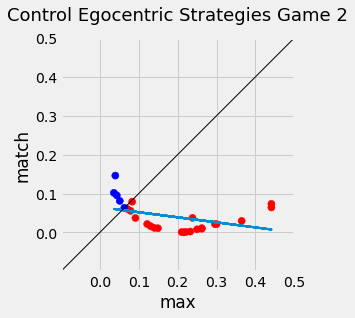

In [176]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g2['max'], control_jsd_g2['match'], 1)

control_ego_jsd_g2_plot = control_jsd_g2.plot.scatter(x='max',y='match',s=50,color=colors_jsd_control_g2_ego)
plt.title('Control Egocentric Strategies Game 2', fontsize=18, y=1.05)
control_ego_jsd_g2_plot.plot(control_jsd_g2['max'], m*control_jsd_g2['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
control_ego_jsd_g2_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_2.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()

# SMAB4 Joint Analysis

In [177]:
# In[ ]:


'''#under line = matching (closer to 0)
#plots of atual jsd values
control_joint_jsd_g2_plot = control_jsd_g2.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_control_g2_joint,title='Control Social Strategies Game 2')
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
control_joint_jsd_g2_plot.add_line(line1)



plt.savefig('control_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
control_joint_jsd_g2_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)'''

'#under line = matching (closer to 0)\n#plots of atual jsd values\ncontrol_joint_jsd_g2_plot = control_jsd_g2.plot.scatter(x=\'rand\',y=\'soc\',s=50,color=colors_jsd_control_g2_joint,title=\'Control Social Strategies Game 2\')\nplt.xticks(np.arange(0, 1, step=0.1))\nplt.yticks(np.arange(0, 1, step=0.1))\n#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color=\'red\')\n#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])\n\n#plt.xlabel(\'Match\')\n#plt.ylabel(\'Maximize\')\n\nplt.ylim(-.1, .5)\nplt.xlim(-.1, .5)\n\n#make axes equal length\nplt.gca().set_aspect(\'equal\', adjustable=\'box\')\nplt.draw()\n\n\n#add legend FIX\n#from numpy.random import randn\n#z = randn(100)\n#blue_dot, = plt.plot(z, "bo", markersize=10)\n#red_dot, = plt.plot(z, "ro", markersize=10)\n#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])\n\n\n\n#add line\nline1 = mlines.Line2D([-1, .5],[-1, .5], color=\'black\')\ncontrol_joint_jsd_g2_plot.add_line(line1)\n\n\n\nplt.savefig(\'control_joint_jsd_1.eps\',form

In [178]:
'''Here we load the csv files into Pandas dataframes by calling organize_trial_by_trial and get the score of each subject 
in each game by calling call_get_score.'''


df = organize_trial_by_trial('data/j01_gamedata.csv')
j01 = df
j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j01_p1_diff,j01_p2_diff,j01_p1_g1_50,j01_p1_g2_50,j01_p2_g1_50,j01_p2_g2_50= call_get_score(j01, 'j')
j01.head()

df = organize_trial_by_trial('data/j02_gamedata.csv')
j02 = df
j02_p1_g1_score,j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j02_p1_diff,j02_p2_diff,j02_p1_g1_50,j02_p1_g2_50,j02_p2_g1_50,j02_p2_g2_50 = call_get_score(j02, 'j')
j02.head()


df = organize_trial_by_trial('data/j03_gamedata.csv')
j03 = df
j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j03_p1_diff,j03_p2_diff,j03_p1_g1_50,j03_p1_g2_50,j03_p2_g1_50,j03_p2_g2_50 = call_get_score(j03, 'j')
j03.head()


df = organize_trial_by_trial('data/j04_gamedata.csv')
j04 = df
j04_p1_g1_score,j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j04_p1_diff,j04_p2_diff,j04_p1_g1_50,j04_p1_g2_50,j04_p2_g1_50,j04_p2_g2_50 = call_get_score(j04, 'j')
j04.head()


df = organize_trial_by_trial('data/j05_gamedata.csv')
j05 = df
j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j05_p1_diff,j05_p2_diff,j05_p1_g1_50,j05_p1_g2_50,j05_p2_g1_50,j05_p2_g2_50 = call_get_score(j05, 'j')
j05.head()


df = organize_trial_by_trial('data/j06_gamedata.csv')
j06 = df
j06_p1_g1_score,j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score,j06_p1_diff,j06_p2_diff,j06_p1_g1_50,j06_p1_g2_50,j06_p2_g1_50,j06_p2_g2_50 = call_get_score(j06, 'j')
j06.head()


df = organize_trial_by_trial('data/j07_gamedata.csv')
j07 = df
j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,j07_p2_g2_score,j07_p1_diff,j07_p2_diff,j07_p1_g1_50,j07_p1_g2_50,j07_p2_g1_50,j07_p2_g2_50 = call_get_score(j07, 'j')
j07.head()


df = organize_trial_by_trial('data/j08_gamedata.csv')
j08 = df
j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score,j08_p1_diff,j08_p2_diff,j08_p1_g1_50,j08_p1_g2_50,j08_p2_g1_50,j08_p2_g2_50 = call_get_score(j08, 'j')
j08.head()


df = organize_trial_by_trial_300('data/j10_gamedata2.csv')
j10 = df
j10_p1_g1_score,j10_p1_g2_score,j10_p2_g1_score,j10_p2_g2_score,j10_p1_diff,j10_p2_diff,j10_p1_g1_50,j10_p1_g2_50,j10_p2_g1_50,j10_p2_g2_50 = call_get_score(j10, 'j')
j10.head()


df = organize_trial_by_trial_300('data/j11_gamedata2.csv')
j11 = df
j11_p1_g1_score,j11_p1_g2_score,j11_p2_g1_score,j11_p2_g2_score,j11_p1_diff,j11_p2_diff,j11_p1_g1_50,j11_p1_g2_50,j11_p2_g1_50,j11_p2_g2_50 = call_get_score(j11, 'j')
j11.head()

#NEED to add j12 to other analyses
''''df = organize_trial_by_trial_300('data/j12_gamedata_old.csv')
j12 = df
j12_p1_g1_score,j12_p1_g2_score,j12_p2_g1_score,j12_p2_g2_score,j12_p1_diff,j12_p2_diff,j12_p1_g1_50,j12_p1_g2_50,j12_p2_g1_50,j12_p2_g2_50 = call_get_score(j12, 'j')
j12.head()'''

"'df = organize_trial_by_trial_300('data/j12_gamedata_old.csv')\nj12 = df\nj12_p1_g1_score,j12_p1_g2_score,j12_p2_g1_score,j12_p2_g2_score,j12_p1_diff,j12_p2_diff,j12_p1_g1_50,j12_p1_g2_50,j12_p2_g1_50,j12_p2_g2_50 = call_get_score(j12, 'j')\nj12.head()"

In [179]:
'''Here we separate the dataframes by suject and game by calling separate_df. We also create arrays with the number of
times that each subject chose each hole by calling value_counts.'''

j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')
j10_p1_g1, j10_p1_g2, j10_p2_g1, j10_p2_g2 = separate_df(j10, 'j')
j11_p1_g1, j11_p1_g2, j11_p2_g1, j11_p2_g2 = separate_df(j11, 'j')



j01_p1_g1_count = j01_p1_g1['probability'].value_counts(sort=False)
j01_p1_g2_count = j01_p1_g2['probability'].value_counts(sort=False)
j01_p2_g1_count = j01_p2_g1['probability'].value_counts(sort=False)
j01_p2_g2_count = j01_p2_g2['probability'].value_counts(sort=False)
j02_p1_g1_count = j02_p1_g1['probability'].value_counts(sort=False)
j02_p1_g2_count = j02_p1_g2['probability'].value_counts(sort=False)
j02_p2_g1_count = j02_p2_g1['probability'].value_counts(sort=False)
j02_p2_g2_count = j02_p2_g2['probability'].value_counts(sort=False)
j03_p1_g1_count = j03_p1_g1['probability'].value_counts(sort=False)
j03_p1_g2_count = j03_p1_g2['probability'].value_counts(sort=False)
j03_p2_g1_count = j03_p2_g1['probability'].value_counts(sort=False)
j03_p2_g2_count = j03_p2_g2['probability'].value_counts(sort=False)
j04_p1_g1_count = j04_p1_g1['probability'].value_counts(sort=False)
j04_p1_g2_count = j04_p1_g2['probability'].value_counts(sort=False)
j04_p2_g1_count = j04_p2_g1['probability'].value_counts(sort=False)
j04_p2_g2_count = j04_p2_g2['probability'].value_counts(sort=False)
j05_p1_g1_count = j05_p1_g1['probability'].value_counts(sort=False)
j05_p1_g2_count = j05_p1_g2['probability'].value_counts(sort=False)
j05_p2_g1_count = j05_p2_g1['probability'].value_counts(sort=False)
j05_p2_g2_count = j05_p2_g2['probability'].value_counts(sort=False)
j06_p1_g1_count = j06_p1_g1['probability'].value_counts(sort=False)
j06_p1_g2_count = j06_p1_g2['probability'].value_counts(sort=False)
j06_p2_g1_count = j06_p2_g1['probability'].value_counts(sort=False)
j06_p2_g2_count = j06_p2_g2['probability'].value_counts(sort=False)
j07_p1_g1_count = j07_p1_g1['probability'].value_counts(sort=False)
j07_p1_g2_count = j07_p1_g2['probability'].value_counts(sort=False)
j07_p2_g1_count = j07_p2_g1['probability'].value_counts(sort=False)
j07_p2_g2_count = j07_p2_g2['probability'].value_counts(sort=False)
j08_p1_g1_count = j08_p1_g1['probability'].value_counts(sort=False)
j08_p1_g2_count = j08_p1_g2['probability'].value_counts(sort=False)
j08_p2_g1_count = j08_p2_g1['probability'].value_counts(sort=False)
j08_p2_g2_count = j08_p2_g2['probability'].value_counts(sort=False)
j10_p1_g1_count = j10_p1_g1['probability'].value_counts(sort=False)
j10_p1_g2_count = j10_p1_g2['probability'].value_counts(sort=False)
j10_p2_g1_count = j10_p2_g1['probability'].value_counts(sort=False)
j10_p2_g2_count = j10_p2_g2['probability'].value_counts(sort=False)
j11_p1_g1_count = j11_p1_g1['probability'].value_counts(sort=False)
j11_p1_g2_count = j11_p1_g2['probability'].value_counts(sort=False)
j11_p2_g1_count = j11_p2_g1['probability'].value_counts(sort=False)
j11_p2_g2_count = j11_p2_g2['probability'].value_counts(sort=False)

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

In [180]:
'''Here we mech the hole-probability mappings in each game for each player'''
j01_p1_g1_map = hole_prob_map(j01_p1_g1)
j01_p1_g2_map = hole_prob_map(j01_p1_g2)
j01_p2_g1_map = hole_prob_map(j01_p2_g1)
j01_p2_g2_map = hole_prob_map(j01_p2_g2)

j02_p1_g1_map = hole_prob_map(j02_p1_g1)
j02_p1_g2_map = hole_prob_map(j02_p1_g2)
j02_p2_g1_map = hole_prob_map(j02_p2_g1)
j02_p2_g2_map = hole_prob_map(j02_p2_g2)

j03_p1_g1_map = hole_prob_map(j03_p1_g1)
j03_p1_g2_map = hole_prob_map(j03_p1_g2)
j03_p2_g1_map = hole_prob_map(j03_p2_g1)
j03_p2_g2_map = hole_prob_map(j03_p2_g2)

j04_p1_g1_map = hole_prob_map(j04_p1_g1)
j04_p1_g2_map = hole_prob_map(j04_p1_g2)
j04_p2_g1_map = hole_prob_map(j04_p2_g1)
j04_p2_g2_map = hole_prob_map(j04_p2_g2)

j05_p1_g1_map = hole_prob_map(j05_p1_g1)
j05_p1_g2_map = hole_prob_map(j05_p1_g2)
j05_p2_g1_map = hole_prob_map(j05_p2_g1)
j05_p2_g2_map = hole_prob_map(j05_p2_g2)

j06_p1_g1_map = hole_prob_map(j06_p1_g1)
j06_p1_g2_map = hole_prob_map(j06_p1_g2)
j06_p2_g1_map = hole_prob_map(j06_p2_g1)
j06_p2_g2_map = hole_prob_map(j06_p2_g2)

j07_p1_g1_map = hole_prob_map(j07_p1_g1)
j07_p1_g2_map = hole_prob_map(j07_p1_g2)
j07_p2_g1_map = hole_prob_map(j07_p2_g1)
j07_p2_g2_map = hole_prob_map(j07_p2_g2)

j08_p1_g1_map = hole_prob_map(j08_p1_g1)
j08_p1_g2_map = hole_prob_map(j08_p1_g2)
j08_p2_g1_map = hole_prob_map(j08_p2_g1)
j08_p2_g2_map = hole_prob_map(j08_p2_g2)

j10_p1_g1_map = hole_prob_map(j10_p1_g1)
j10_p1_g2_map = hole_prob_map(j10_p1_g2)
j10_p2_g1_map = hole_prob_map(j10_p2_g1)
j10_p2_g2_map = hole_prob_map(j10_p2_g2)

#j11_p1_g1_map = hole_prob_map(j11_p1_g1)
#j11_p1_g2_map = hole_prob_map(j11_p1_g2)
#j11_p2_g1_map = hole_prob_map(j11_p2_g1)
#j11_p2_g2_map = hole_prob_map(j11_p2_g2)

In [181]:
'''Here we create dataframes with all of the scores of each subject in games 1 and 2. 50 refers to the score half-way
through the games'''


# # Combined Joint scores G1

j_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score]})
j_scores_1.set_index('participant', inplace=True, drop=True)
j_scores_1


# # Combined Joint scores G2

# In[ ]:


j_scores_2_d = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2'], 'score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score]})
j_scores_2_d.set_index('participant', inplace=True, drop=True)

j_scores_2_s = pd.DataFrame({'participant':['j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2':
     [j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score]})
j_scores_2_s.set_index('participant', inplace=True, drop=True)

j_scores_1_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1_50':
     [j01_p1_g1_50, j01_p2_g1_50, j02_p1_g1_50, j02_p2_g1_50, j03_p1_g1_50, j03_p2_g1_50,
      j04_p1_g1_50, j04_p2_g1_50, j05_p1_g1_50, j05_p2_g1_50, j06_p1_g1_50, j06_p2_g1_50,
      j07_p1_g1_50, j07_p2_g1_50, j08_p1_g1_50, j08_p2_g1_50, j10_p1_g1_50, j10_p2_g1_50, j11_p1_g1_50, j11_p2_g1_50]})
j_scores_1_50.set_index('participant', inplace=True, drop=True)




j_scores_2_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2_50':
     [j01_p1_g2_50, j01_p2_g2_50, j02_p1_g2_50, j02_p2_g2_50, j03_p1_g2_50, j03_p2_g2_50,
      j04_p1_g2_50, j04_p2_g2_50, j05_p1_g2_50, j05_p2_g2_50, j06_p1_g2_50, j06_p2_g2_50,
      j07_p1_g2_50, j07_p2_g2_50, j08_p1_g2_50, j08_p2_g2_50, j10_p1_g2_50, j10_p2_g2_50, j11_p1_g2_50, j11_p2_g2_50]})
j_scores_2_50.set_index('participant', inplace=True, drop=True)



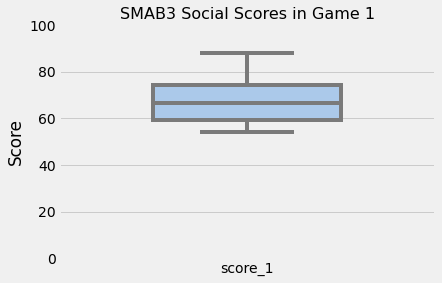

In [182]:
j_scores_1_box = sns.boxplot( 
                 data=j_scores_1, 
                 width=0.5,
                 palette="pastel")
j_scores_1_box.axes.set_title("SMAB3 Social Scores in Game 1",
                    fontsize=16)

plot_file_name="j_score_1_box.jpg"
 
plt.ylim(0, 100)
j_scores_1_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_1_box.figure.savefig(plot_file_name,
                    format='jpeg')

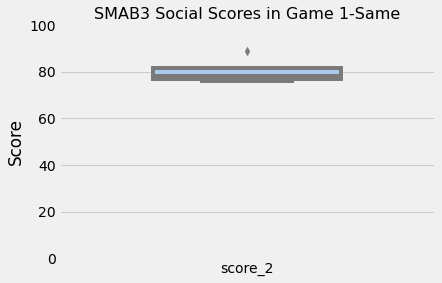

In [183]:
j_scores_2s_box = sns.boxplot( 
                 data=j_scores_2_s, 
                 width=0.5,
                 palette="pastel")
j_scores_2s_box.axes.set_title("SMAB3 Social Scores in Game 1-Same",
                    fontsize=16)

plot_file_name="j_score_2s_box.jpg"
 
plt.ylim(0, 100)
j_scores_2s_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

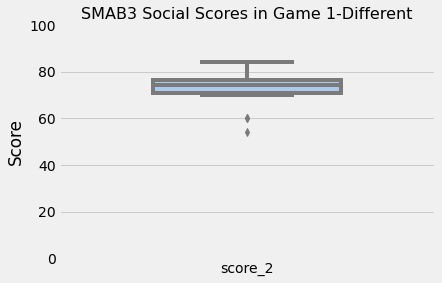

In [184]:
j_scores_2d_box = sns.boxplot( 
                 data=j_scores_2_d, 
                 width=0.5,
                 palette="pastel")
j_scores_2d_box.axes.set_title("SMAB3 Social Scores in Game 1-Different",
                    fontsize=16)

plot_file_name="j_score_2d_box.jpg"
 
plt.ylim(0, 100)
j_scores_2d_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [185]:
j_scores_2s_mean = j_scores_2_s.mean()

In [186]:
j_scores_2d_mean = j_scores_2_d.mean()

In [187]:
j_scores_2s_std = j_scores_2_s.std()

In [188]:
j_scores_2d_std = j_scores_2_d.std()

In [189]:
j_scores_2s_mean, j_scores_2s_std

(score_2    80.25
 dtype: float64,
 score_2    5.965177
 dtype: float64)

In [190]:
j_scores_2d_mean, j_scores_2d_std

(score_2    72.6875
 dtype: float64,
 score_2    8.42788
 dtype: float64)

In [191]:
sp.stats.ttest_ind(j_scores_2_s, j_scores_2_d)

Ttest_indResult(statistic=array([1.67640168]), pvalue=array([0.11094111]))

In [192]:
s_scores_2_s.size

8

In [193]:
c_scores_2_s

confederate_score_2
participant                     
c12                           53
c13                           68
c14                           65
c15                           82
c16                           72
c17                           75
c18                           74

In [194]:
1

1

In [195]:
'''Here we combine the dataframes with the scores from the 2 games.
j_scores_50 = j_scores_1_50.merge(j_scores_2_50,right_index=True,left_index=True)
j_scores = j_scores_1.merge(j_scores_2,right_index=True,left_index=True)
j_combo = j_scores_50.merge(j_scores,right_index=True,left_index=True)

#rename columns
#c_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]https://divisible.info/Modulo/What-is-5-mod-12.html#:~:text=To%20find%205%20mod%2012,by%20the%20Divisor%20(12).&text=Thus%2C%20the%20answer%20to%20%22What,mod%2012%3F%22%20is%205.'''

'Here we combine the dataframes with the scores from the 2 games.\nj_scores_50 = j_scores_1_50.merge(j_scores_2_50,right_index=True,left_index=True)\nj_scores = j_scores_1.merge(j_scores_2,right_index=True,left_index=True)\nj_combo = j_scores_50.merge(j_scores,right_index=True,left_index=True)\n\n#rename columns\n#c_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]https://divisible.info/Modulo/What-is-5-mod-12.html#:~:text=To%20find%205%20mod%2012,by%20the%20Divisor%20(12).&text=Thus%2C%20the%20answer%20to%20%22What,mod%2012%3F%22%20is%205.'

In [196]:
''''#Combined Joint scores G1 and G2

j_scores = pd.merge(j_scores_1, j_scores_2, on = 'participant')
j_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
j_scores'''

"'#Combined Joint scores G1 and G2\n\nj_scores = pd.merge(j_scores_1, j_scores_2, on = 'participant')\nj_scores.columns=['Game 1','Game 2']\n#jp1_scores.set_index('participant', inplace=True, drop=True)\nj_scores"

In [197]:
'''Here we get the mean, median, and standard deviation of the scores. We also run a t-test comparing the scores in games 1 and 2
and plot the data.'''

j_scores_1_mean = j_scores_1.mean()


# In[ ]:


j_scores_1_mean


# In[ ]:


j_scores_1_std = j_scores_1.std()


# In[ ]:


j_scores_1_std

score_1    9.653333
dtype: float64

In [198]:
#j_scores_p = sp.stats.ttest_rel(j_scores['Game 1'],j_scores['Game 2'])

In [199]:
len(j_scores_1)

20

In [200]:
'''
j_scores_box = sns.boxplot( 
                 data=j_scores, 
                 width=0.5,
                 palette="pastel")
j_scores_box.axes.set_title("SMAB3 Social Scores",
                    fontsize=16)

plot_file_name="j_score_box.jpg"
 
plt.ylim(0, 100)
j_scores_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'\nj_scores_box = sns.boxplot( \n                 data=j_scores, \n                 width=0.5,\n                 palette="pastel")\nj_scores_box.axes.set_title("SMAB3 Social Scores",\n                    fontsize=16)\n\nplot_file_name="j_score_box.jpg"\n \nplt.ylim(0, 100)\nj_scores_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nj_scores_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

In [201]:
'''
j_combo_box = sns.boxplot( 
                 data=j_combo, order = ['score_1_50','score_2_50','score_1','score_2'],
                 width=0.5,
                 palette="pastel")
j_combo_box.axes.set_title("SMAB3 Social Scores",
                    fontsize=16)

plot_file_name="j_score_box.jpg"
 
plt.ylim(0, 100)
j_combo_box.axes.set(ylabel='Score')

# save as jpeg
j_combo_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'\nj_combo_box = sns.boxplot( \n                 data=j_combo, order = [\'score_1_50\',\'score_2_50\',\'score_1\',\'score_2\'],\n                 width=0.5,\n                 palette="pastel")\nj_combo_box.axes.set_title("SMAB3 Social Scores",\n                    fontsize=16)\n\nplot_file_name="j_score_box.jpg"\n \nplt.ylim(0, 100)\nj_combo_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nj_combo_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

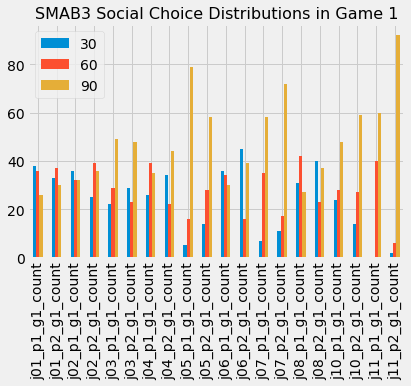

In [202]:
'''Here we place all of the data into the number of times each subject chose each hole into dataframes for games 1 
and 2. We plot this data and run statistics on it.'''

# # Joint combined choices in G1



j_g1_counts = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count'])


# In[ ]:


j_g1_counts = j_g1_counts.fillna(0)


# In[ ]:


j_g1_counts 


# In[ ]:


j_g1_counts.sum(axis=1)


# In[ ]:


j_g1_counts_bar = j_g1_counts.plot.bar()

j_g1_counts_bar.axes.set_title("SMAB3 Social Choice Distributions in Game 1",
                    fontsize=16)

j_g1_counts_bar.figure.savefig("j_g1_counts_bar.jpg",
                    format='jpeg')

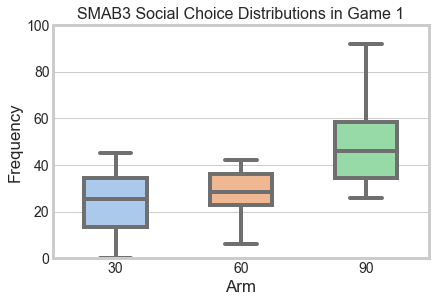

In [203]:
# In[ ]:
sns.set_style("whitegrid")

j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"
 
plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')


# In[ ]:

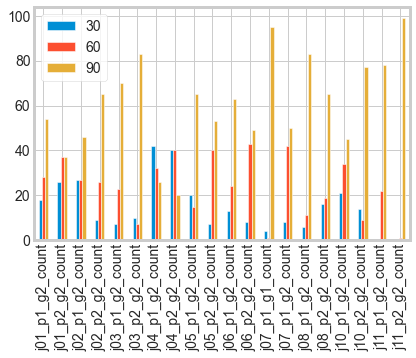

In [204]:
j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low


# In[ ]:


j_g1_med


# In[ ]:


j_g1_high


# In[ ]:


j_g1_low_std = np.std(j_g1_counts.iloc[:,0])
j_g1_med_std = np.std(j_g1_counts.iloc[:,1])
j_g1_high_std = np.std(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low_std


# In[ ]:


j_g1_med_std


# In[ ]:


j_g1_high_std


# # Joint combined choices in G2

# In[ ]:


j_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count, 
              j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g1_count', 'j07_p1_g2_count', 
                 'j08_p1_g2_count', 'j08_p2_g2_count', 'j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count'])


# In[ ]:


j_g2_counts = j_g2_counts.fillna(0)
j_g2_counts 


# In[ ]:


j_g2_counts.sum(axis=1)


# In[ ]:


j_g2_counts_bar = j_g2_counts.plot.bar()

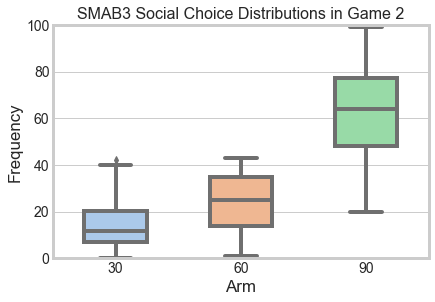

In [205]:
# In[ ]:


j_g2_counts_box = sns.boxplot( 
                 data=j_g2_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="j_g2_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [206]:
j_scores_1

score_1
participant         
j01_p1            57
j01_p2            61
j02_p1            54
j02_p2            68
j03_p1            69
j03_p2            67
j04_p1            64
j04_p2            56
j05_p1            77
j05_p2            70
j06_p1            54
j06_p2            61
j07_p1            74
j07_p2            80
j08_p1            60
j08_p2            57
j10_p1            66
j10_p2            75
j11_p1            79
j11_p2            88

In [207]:
j_scores_1_mean

score_1    66.85
dtype: float64

In [208]:
j_scores_1_std

score_1    9.653333
dtype: float64

In [209]:
# In[ ]:

j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])

j_g2_low = np.mean(j_g2_counts.iloc[:,0])
j_g2_med = np.mean(j_g2_counts.iloc[:,1])
j_g2_high = np.mean(j_g2_counts.iloc[:,2])


# In[ ]:


j_g2_low


# In[ ]:


j_g2_med


# In[ ]:


j_g2_high


# In[ ]:


j_g2_low_std = np.std(j_g2_counts.iloc[:,0])
j_g2_med_std = np.std(j_g2_counts.iloc[:,1])
j_g2_high_std = np.std(j_g2_counts.iloc[:,2])


# In[ ]:


j_g2_low_std


# In[ ]:


j_g2_med_std


# In[ ]:


j_g2_high_std

20.720219593430954

In [210]:
j_g1_low, j_g1_med, j_g1_high

(23.6, 28.45, 47.95)

In [211]:
j_g1_low_std, j_g1_med_std, j_g1_high_std

(13.268006632497586, 9.499868420141407, 17.746760267722106)

In [212]:
j_g1_counts

30    60    90
j01_p1_g1_count  38.0  36.0  26.0
j01_p2_g1_count  33.0  37.0  30.0
j02_p1_g1_count  36.0  32.0  32.0
j02_p2_g1_count  25.0  39.0  36.0
j03_p1_g1_count  22.0  29.0  49.0
j03_p2_g1_count  29.0  23.0  48.0
j04_p1_g1_count  26.0  39.0  35.0
j04_p2_g1_count  34.0  22.0  44.0
j05_p1_g1_count   5.0  16.0  79.0
j05_p2_g1_count  14.0  28.0  58.0
j06_p1_g1_count  36.0  34.0  30.0
j06_p2_g1_count  45.0  16.0  39.0
j07_p1_g1_count   7.0  35.0  58.0
j07_p2_g1_count  11.0  17.0  72.0
j08_p1_g1_count  31.0  42.0  27.0
j08_p2_g1_count  40.0  23.0  37.0
j10_p1_g1_count  24.0  28.0  48.0
j10_p2_g1_count  14.0  27.0  59.0
j11_p1_g1_count   0.0  40.0  60.0
j11_p2_g1_count   2.0   6.0  92.0

In [213]:
#combine joint hole count dataframes 
#make index just the participant code
#combine control_counts_2 and control_counts_1

#modify the index to be only participant
subjects_1 = j_g1_counts.index.to_numpy()
subjects_2 = j_g2_counts.index.to_numpy()

subjects_new1 = np.array([])
subjects_new2 = np.array([])

ii = 0
for i in subjects_1:
    subjects_new1 = np.append(subjects_new1,subjects_1[ii][0:6])
    ii = ii +1
    
iii = 0
for i in subjects_2:
    subjects_new2 = np.append(subjects_new2,subjects_2[iii][0:6])
    iii = iii +1

j_g1_counts.index = subjects_new1
j_g2_counts.index = subjects_new2

j_counts = j_g1_counts.merge(j_g2_counts,right_index=True,left_index=True)

In [214]:
j_counts

30_x  60_x  90_x  30_y  60_y  90_y
j01_p1  38.0  36.0  26.0  18.0  28.0  54.0
j01_p2  33.0  37.0  30.0  26.0  37.0  37.0
j02_p1  36.0  32.0  32.0  27.0  27.0  46.0
j02_p2  25.0  39.0  36.0   9.0  26.0  65.0
j03_p1  22.0  29.0  49.0   7.0  23.0  70.0
j03_p2  29.0  23.0  48.0  10.0   7.0  83.0
j04_p1  26.0  39.0  35.0  42.0  32.0  26.0
j04_p2  34.0  22.0  44.0  40.0  40.0  20.0
j05_p1   5.0  16.0  79.0  20.0  15.0  65.0
j05_p2  14.0  28.0  58.0   7.0  40.0  53.0
j06_p1  36.0  34.0  30.0  13.0  24.0  63.0
j06_p2  45.0  16.0  39.0   8.0  43.0  49.0
j07_p1   7.0  35.0  58.0   4.0   1.0  95.0
j07_p1   7.0  35.0  58.0   8.0  42.0  50.0
j08_p1  31.0  42.0  27.0   6.0  11.0  83.0
j08_p2  40.0  23.0  37.0  16.0  19.0  65.0
j10_p1  24.0  28.0  48.0  21.0  34.0  45.0
j10_p2  14.0  27.0  59.0  14.0   9.0  77.0
j11_p1   0.0  40.0  60.0   0.0  22.0  78.0
j11_p2   2.0   6.0  92.0   0.0   1.0  99.0

In [215]:
'''Here we combine the separate the counts of each hole into separate arrays. We run t-tests to compare the counts
of each hole in each game.'''


# # Joint combined arrays

# In[ ]:


#pip install researchpy


# In[ ]:


import researchpy as rp


# In[ ]:


j_90_1 = np.array(j_g1_counts.iloc[:,2])
j_90_2 = np.array(j_g2_counts.iloc[:,2])


# In[ ]:


j_90_1


# In[ ]:


j_90_2


# In[ ]:


j_60_1 = np.array(j_g1_counts.iloc[:,1])
j_60_2 = np.array(j_g2_counts.iloc[:,1])


# In[ ]:


j_60_1


# In[ ]:


j_60_2


# In[ ]:


j_30_1 = np.array(j_g1_counts.iloc[:,0])
j_30_2 = np.array(j_g2_counts.iloc[:,0])


# In[ ]:


j_30_1


# In[ ]:


j_30_2


# # Joint combined choice statistics

# In[ ]:


j_90_p = sp.stats.ttest_rel(j_90_1,j_90_2)
j_60_p = sp.stats.ttest_rel(j_60_1,j_60_2)
j_30_p = sp.stats.ttest_rel(j_30_1,j_30_2)


# In[ ]:


j_90_p


# In[ ]:


j_60_p


# In[ ]:


j_30_p

Ttest_relResult(statistic=2.8916950793464284, pvalue=0.009347666583121904)

In [216]:
'Here we get the reaction times'
time_j_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_j_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [217]:
time_j_1 = reaction_time(j01_p1_g1, time_j_1)
time_j_1 = reaction_time(j02_p1_g1, time_j_1)
time_j_1 = reaction_time(j03_p1_g1, time_j_1)
time_j_1 = reaction_time(j04_p1_g1, time_j_1)
time_j_1 = reaction_time(j05_p1_g1, time_j_1)
time_j_1 = reaction_time(j06_p1_g1, time_j_1)
time_j_1 = reaction_time(j07_p1_g1, time_j_1)
time_j_1 = reaction_time(j08_p1_g1, time_j_1)
time_j_1 = reaction_time(j10_p1_g1, time_j_1)
time_j_1 = reaction_time(j11_p1_g1, time_j_1)

In [218]:
time_j_2 = reaction_time(j01_p1_g2, time_j_2)
time_j_2 = reaction_time(j02_p1_g2, time_j_2)
time_j_2 = reaction_time(j03_p1_g2, time_j_2)
time_j_2 = reaction_time(j04_p1_g2, time_j_2)
time_j_2 = reaction_time(j05_p1_g2, time_j_2)
time_j_2 = reaction_time(j06_p1_g2, time_j_2)
time_j_2 = reaction_time(j07_p1_g2, time_j_2)
time_j_2 = reaction_time(j08_p1_g2, time_j_2)
time_j_2 = reaction_time(j10_p1_g2, time_j_2)
time_j_2 = reaction_time(j11_p1_g2, time_j_2)

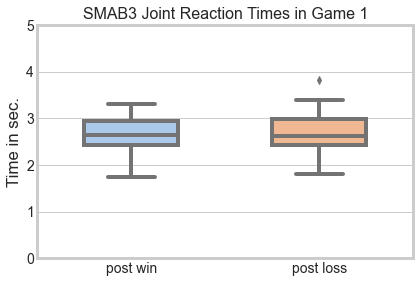

In [219]:
times_j_g1_box = sns.boxplot( 
                 data=time_j_1, 
                 width=0.5,
                 palette="pastel")
times_j_g1_box.axes.set_title("SMAB3 Joint Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_j_g1_box.jpg"
 
plt.ylim(0, 5)
times_j_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_j_g1_box.figure.savefig(plot_file_name,format='jpeg')

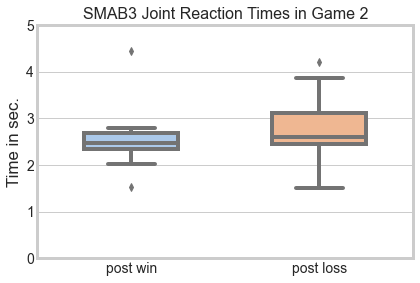

In [220]:
times_j_g2_box = sns.boxplot( 
                 data=time_j_2, 
                 width=0.5,
                 palette="pastel")
times_j_g2_box.axes.set_title("SMAB3 Joint Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_j_g2_box.jpg"
 
plt.ylim(0, 5)
times_j_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_j_g2_box.figure.savefig(plot_file_name,format='jpeg')

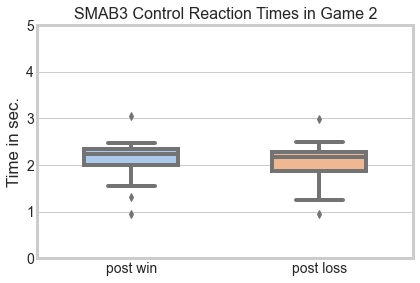

In [221]:
times_s_g2_box = sns.boxplot( 
                 data=time_s_2, 
                 width=0.5,
                 palette="pastel")
times_s_g2_box.axes.set_title("SMAB3 Control Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_s_g2_box.jpg"
 
plt.ylim(0, 5)
times_s_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_s_g2_box.figure.savefig(plot_file_name,format='jpeg')

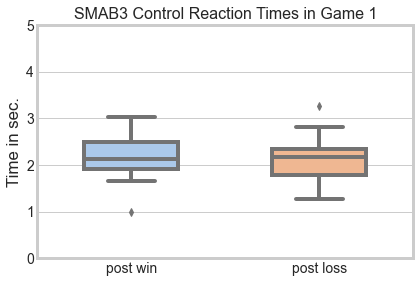

In [222]:
times_s_g1_box = sns.boxplot( 
                 data=time_s_1, 
                 width=0.5,
                 palette="pastel")
times_s_g1_box.axes.set_title("SMAB3 Control Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_s_g1_box.jpg"
 
plt.ylim(0, 5)
times_s_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_s_g1_box.figure.savefig(plot_file_name,format='jpeg')

In [223]:
np.mean(time_s_1)

post win     2.143281
post loss    2.156833
dtype: float64

In [224]:
np.mean(time_s_2)

post win     2.095491
post loss    2.040904
dtype: float64

In [225]:
np.std(time_s_1)

post win     0.501875
post loss    0.504602
dtype: float64

In [226]:
np.std(time_s_2)

post win     0.539784
post loss    0.528833
dtype: float64

In [227]:
np.mean(time_j_1)

post win     3.003842
post loss    2.743744
dtype: float64

In [228]:
np.mean(time_j_2)

post win     2.571192
post loss    2.772587
dtype: float64

In [229]:
np.std(time_j_1)

post win     1.287668
post loss    0.547701
dtype: float64

In [230]:
np.std(time_j_2)

post win     0.715499
post loss    0.768199
dtype: float64

In [231]:
sp.stats.ttest_rel(time_s_1['post win'],time_s_1['post loss'])

Ttest_relResult(statistic=-0.22232713395530926, pvalue=0.8277981973516864)

In [232]:
sp.stats.ttest_rel(time_s_2['post win'],time_s_2['post loss'])

Ttest_relResult(statistic=1.6133551404642006, pvalue=0.1349630881166298)

In [233]:
sp.stats.ttest_rel(time_j_1['post win'],time_j_1['post loss'])

Ttest_relResult(statistic=0.8796229730498023, pvalue=0.40193938606783575)

In [234]:
sp.stats.ttest_rel(time_j_2['post win'],time_j_2['post loss'])

Ttest_relResult(statistic=-1.240209628973232, pvalue=0.24625663257219957)

# SMAB4 Joint Data 

In [235]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.
Note: for the files that were hand coded, the scores will be obtained later, as the score column needs to be filled out still.'''

# # Multi Analysis

df = organize_trial_by_trial_hand_code2('data/m01_gamedata_handcode.csv')
m01 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m01.head()

df = organize_trial_by_trial_hand_code2('data/m03_gamedata_handcode.csv')
m03 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m03.head()

df = organize_trial_by_trial('data/m05_gamedata.csv')
m05 = df
m05_p1_g1_score,m05_p1_g2_score,m05_p2_g1_score,m05_p2_g2_score,m05_p1_diff,m05_p2_diff,m05_p1_g1_50,m05_p1_g2_50,m05_p2_g1_50,m05_p2_g2_50 = call_get_score(m05, 'm')
m05.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m06_gamedata2.csv')
m06 = df
m06_p1_g1_score,m06_p1_g2_score,m06_p2_g1_score,m06_p2_g2_score,m06_p1_diff,m06_p2_diff,m06_p1_g1_50,m06_p1_g2_50,m06_p2_g1_50,m06_p2_g2_50 = call_get_score(m06, 'm')
m06.head()


df = organize_trial_by_trial_hand_code2('data/m07_gamedata_handcode.csv')
m07 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m07.head()

#m09 from LSL needs to be combined with hand coded
df = organize_trial_by_trial_hand_code('data/m09_gamedata_handcode.csv')
m09 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m09.head()

df = organize_trial_by_trial('data/m09_gamedata.csv')
m09_lsl = df
#m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_diff,m08_p2_diff,m08_p1_g1_50,m08_p1_g2_50,m08_p2_g1_50,m08_p2_g2_50 = call_get_score(m08, 'm')
m09.head()

df = organize_trial_by_trial_300('data/m08_gamedata2.csv')
m08 = df
m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_diff,m08_p2_diff,m08_p1_g1_50,m08_p1_g2_50,m08_p2_g1_50,m08_p2_g2_50 = call_get_score(m08, 'm')
m08.head()


# In[ ]:


# In[ ]:


df = organize_trial_by_trial_300('data/m10_gamedata2.csv')
m10 = df
m10_p1_g1_score,m10_p1_g2_score,m10_p2_g1_score,m10_p2_g2_score,m10_p1_diff,m10_p2_diff,m10_p1_g1_50,m10_p1_g2_50,m10_p2_g1_50,m10_p2_g2_50 = call_get_score(m10, 'm')
m10.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m11_gamedata2.csv')
m11 = df
m11_p1_g1_score,m11_p1_g2_score,m11_p2_g1_score,m11_p2_g2_score,m11_p1_diff,m11_p2_diff,m11_p1_g1_50,m11_p1_g2_50,m11_p2_g1_50,m11_p2_g2_50 = call_get_score(m11, 'm')
m11.head()


# In[ ]:

#session ends early
#df = organize_trial_by_trial_floatclick('data/m12_gamedata.csv')
#m12 = df
#m12_p1_g1_score,m12_p1_g2_score,m12_p2_g1_score,m12_p2_g2_score,m12_p1_score_diff,m12_p2_score_diff = call_get_score(m12, 'm')
#m12.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m13_gamedata2.csv')
m13 = df
m13_p1_g1_score,m13_p1_g2_score,m13_p2_g1_score,m13_p2_g2_score,m13_p1_diff,m13_p2_diff,m13_p1_g1_50,m13_p1_g2_50,m13_p2_g1_50,m13_p2_g2_50 = call_get_score(m13, 'm')
m13.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m14_gamedata2.csv')
m14 = df
m14_p1_g1_score,m14_p1_g2_score,m14_p2_g1_score,m14_p2_g2_score,m14_p1_diff,m14_p2_diff,m14_p1_g1_50,m14_p1_g2_50,m14_p2_g1_50,m14_p2_g2_50 = call_get_score(m14, 'm')
m14.head()


# In[ ]:


m05_p1_g1, m05_p1_g2, m05_p2_g1, m05_p2_g2 = separate_df(m05, 'm')
m06_p1_g1, m06_p1_g2, m06_p2_g1, m06_p2_g2 = separate_df(m06, 'm')
m07_p1_g1, m07_p1_g2, m07_p2_g1, m07_p2_g2 = separate_df(m07, 'm')
m08_p1_g1, m08_p1_g2, m08_p2_g1, m08_p2_g2 = separate_df(m08, 'm')
m10_p1_g1, m10_p1_g2, m10_p2_g1, m10_p2_g2 = separate_df(m10, 'm')
m11_p1_g1, m11_p1_g2, m11_p2_g1, m11_p2_g2 = separate_df(m11, 'm')
m13_p1_g1, m13_p1_g2, m13_p2_g1, m13_p2_g2 = separate_df(m13, 'm')

m14_p1_g1, m14_p1_g2, m14_p2_g1, m14_p2_g2 = separate_df(m14, 'm')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

In [236]:
m01_p1_counts, m01_p2_counts, m01_p1_probs, m01_p2_probs = handcode_calc_prob(m01)
m03_p1_counts, m03_p2_counts, m03_p1_probs, m03_p2_probs = handcode_calc_prob(m03)
m07_p1_counts, m07_p2_counts, m07_p1_probs, m07_p2_probs = handcode_calc_prob(m07)

In [237]:
m01 = fill_in_prob(m01, 90,60,30,60,30,90,30,60,90,60,90,30)
m03 = fill_in_prob(m01, 30,90,60,90,30,60,90,30,60,30,90,60)
m07 = fill_in_prob(m07, 30,90,60,90,30,60,90,30,60,30,90,60)

In [238]:
m01_p1_g1, m01_p1_g2, m01_p2_g1, m01_p2_g2 = separate_df(m01, 'm')
m03_p1_g1, m03_p1_g2, m03_p2_g1, m03_p2_g2 = separate_df(m03, 'm')
m07_p1_g1, m07_p1_g2, m07_p2_g1, m07_p2_g2 = separate_df(m07, 'm')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

In [239]:
'''Here we check the probability-hole mappings for each player in each game'''
m01_p1_g1_map = hole_prob_map(m01_p1_g1)
m01_p1_g2_map = hole_prob_map(m01_p1_g2)
m01_p2_g1_map = hole_prob_map(m01_p2_g1)

m03_p2_g2_map = hole_prob_map(m03_p2_g2)
m03_p1_g1_map = hole_prob_map(m03_p1_g1)
m03_p1_g2_map = hole_prob_map(m03_p1_g2)
m03_p2_g1_map = hole_prob_map(m03_p2_g1)
m03_p2_g2_map = hole_prob_map(m03_p2_g2)

m05_p1_g1_map = hole_prob_map(m05_p1_g1)
m05_p1_g2_map = hole_prob_map(m05_p1_g2)
m05_p2_g1_map = hole_prob_map(m05_p2_g1)
m05_p2_g2_map = hole_prob_map(m05_p2_g2)

m06_p1_g1_map = hole_prob_map(m06_p1_g1)
m06_p1_g2_map = hole_prob_map(m06_p1_g2)
m06_p2_g1_map = hole_prob_map(m06_p2_g1)
m06_p2_g2_map = hole_prob_map(m06_p2_g2)

m07_p1_g1_map = hole_prob_map(m07_p1_g1)
#m07_p1_g2_map = hole_prob_map(m07_p1_g2)
m07_p2_g1_map = hole_prob_map(m07_p2_g1)
#m07_p2_g2_map = hole_prob_map(m07_p2_g2)

m08_p1_g1_map = hole_prob_map(m08_p1_g1)
m08_p1_g2_map = hole_prob_map(m08_p1_g2)
m08_p2_g1_map = hole_prob_map(m08_p2_g1)
m08_p2_g2_map = hole_prob_map(m08_p2_g2)

m10_p1_g1_map = hole_prob_map(m10_p1_g1)
m10_p1_g2_map = hole_prob_map(m10_p1_g2)
m10_p2_g1_map = hole_prob_map(m10_p2_g1)
m10_p2_g2_map = hole_prob_map(m10_p2_g2)

m11_p1_g1_map = hole_prob_map(m11_p1_g1)
#m11_p1_g2_map = hole_prob_map(m11_p1_g2)
m11_p2_g1_map = hole_prob_map(m11_p2_g1)
#m11_p2_g2_map = hole_prob_map(m11_p2_g2)

m13_p1_g1_map = hole_prob_map(m13_p1_g1)
m13_p1_g2_map = hole_prob_map(m13_p1_g2)
m13_p2_g1_map = hole_prob_map(m13_p2_g1)
m13_p2_g2_map = hole_prob_map(m13_p2_g2)

In [240]:
m01_p1_g1_score = m01_p1_g1['reward'].sum()
m01_p1_g2_score = m01_p1_g2['reward'].sum()
m01_p2_g1_score = m01_p2_g1['reward'].sum()
m01_p2_g2_score = m01_p2_g2['reward'].sum()

m03_p1_g1_score = m03_p1_g1['reward'].sum()
m03_p1_g2_score = m03_p1_g2['reward'].sum()
m03_p2_g1_score = m03_p2_g1['reward'].sum()
m03_p2_g2_score = m03_p2_g2['reward'].sum()

m07_p1_g1_score = m07_p1_g1['reward'].sum()
m07_p1_g2_score = m07_p1_g2['reward'].sum()
m07_p2_g1_score = m07_p2_g1['reward'].sum()
m07_p2_g2_score = m07_p2_g2['reward'].sum()

In [241]:
m01_p1_g2

game number  trial  player  arm  probability  reward  \
200            2      1       1    3         60.0       0   
202            2      3       1    1         90.0       1   
204            2      5       1    3         60.0       1   
206            2      7       1    2         30.0       1   
208            2      9       1    1         90.0       0   
..           ...    ...     ...  ...          ...     ...   
390            2    191       1    3         60.0       0   
392            2    193       1    2         30.0       0   
394            2    195       1    3         60.0       1   
396            2    197       1    3         60.0       1   
398            2    199       1    3         60.0       1   

                       time comment 1 comment 2  
200 1900-01-01 00:13:02.702       NaT            
202 1900-01-01 00:13:09.572       NaT            
204 1900-01-01 00:13:15.470       NaT            
206 1900-01-01 00:13:21.267       NaT            
208 1900-01-01 00:13:27.969       NaT            
..                      ...       ...       ...  
390 1900-01-01 00:23:20.902       NaT            
392 1900-01-01 00:23:28.040       NaT            
394 1900-01-01 00:23:33.536       NaT            
396 1900-01-01 00:23:39.434       NaT            
398 1900-01-01 00:23:45.935       NaT            

[100 rows x 9 columns]

In [242]:
# In[ ]:
#Not working for m01 and m07 (hand coded)- need to fill in the probability column
m01_p1_g1_count = m01_p1_g1['probability'].value_counts(sort=False)
m01_p1_g2_count = m01_p1_g2['probability'].value_counts(sort=False)
m01_p2_g1_count = m01_p2_g1['probability'].value_counts(sort=False)
m01_p2_g2_count = m01_p2_g2['probability'].value_counts(sort=False)
m03_p1_g1_count = m03_p1_g1['probability'].value_counts(sort=False)
m03_p1_g2_count = m03_p1_g2['probability'].value_counts(sort=False)
m03_p2_g1_count = m03_p2_g1['probability'].value_counts(sort=False)
m03_p2_g2_count = m03_p2_g2['probability'].value_counts(sort=False)

m05_p1_g1_count = m05_p1_g1['probability'].value_counts(sort=False)
m05_p1_g2_count = m05_p1_g2['probability'].value_counts(sort=False)
m05_p2_g1_count = m05_p2_g1['probability'].value_counts(sort=False)
m05_p2_g2_count = m05_p2_g2['probability'].value_counts(sort=False)

m07_p1_g1_count = m07_p1_g1['probability'].value_counts(sort=False)
m07_p1_g2_count = m07_p1_g2['probability'].value_counts(sort=False)
m07_p2_g1_count = m07_p2_g1['probability'].value_counts(sort=False)
m07_p2_g2_count = m07_p2_g2['probability'].value_counts(sort=False)

In [243]:
#same_probs_g1_2
m06_p1_g1_count = m06_p1_g1['probability'].value_counts(sort=False)
m06_p1_g2_count = m06_p1_g2['probability'].value_counts(sort=False)
m06_p2_g1_count = m06_p2_g1['probability'].value_counts(sort=False)
m06_p2_g2_count = m06_p2_g2['probability'].value_counts(sort=False)
m07_p1_g1_count = m07_p1_g1['probability'].value_counts(sort=False)
m07_p1_g2_count = m07_p1_g2['probability'].value_counts(sort=False)
m07_p2_g1_count = m07_p2_g1['probability'].value_counts(sort=False)
m07_p2_g2_count = m07_p2_g2['probability'].value_counts(sort=False)
m08_p1_g1_count = m08_p1_g1['probability'].value_counts(sort=False)
m08_p1_g2_count = m08_p1_g2['probability'].value_counts(sort=False)
m08_p2_g1_count = m08_p2_g1['probability'].value_counts(sort=False)
m08_p2_g2_count = m08_p2_g2['probability'].value_counts(sort=False)
m10_p1_g1_count = m10_p1_g1['probability'].value_counts(sort=False)
m10_p1_g2_count = m10_p1_g2['probability'].value_counts(sort=False)
m10_p2_g1_count = m10_p2_g1['probability'].value_counts(sort=False)
m10_p2_g2_count = m10_p2_g2['probability'].value_counts(sort=False)
m11_p1_g1_count = m11_p1_g1['probability'].value_counts(sort=False)
m11_p1_g2_count = m11_p1_g2['probability'].value_counts(sort=False)
m11_p2_g1_count = m11_p2_g1['probability'].value_counts(sort=False)
m11_p2_g2_count = m11_p2_g2['probability'].value_counts(sort=False)
m13_p1_g1_count = m13_p1_g1['probability'].value_counts(sort=False)
m13_p1_g2_count = m13_p1_g2['probability'].value_counts(sort=False)
m13_p2_g1_count = m13_p2_g1['probability'].value_counts(sort=False)
m13_p2_g2_count = m13_p2_g2['probability'].value_counts(sort=False)
m14_p1_g1_count = m14_p1_g1['probability'].value_counts(sort=False)
m14_p1_g2_count = m14_p1_g2['probability'].value_counts(sort=False)
m14_p2_g1_count = m14_p2_g1['probability'].value_counts(sort=False)
m14_p2_g2_count = m14_p2_g2['probability'].value_counts(sort=False)

In [244]:
#call fix_reward on all of the files imported with '300' to fix the reward column
m06_p1_g1 = fix_reward(m06_p1_g1)
m06_p1_g2 = fix_reward(m06_p1_g2)
m06_p2_g1 = fix_reward(m06_p2_g1)
m06_p2_g2 = fix_reward(m06_p2_g2)
m08_p1_g1 = fix_reward(m08_p1_g1)
m08_p1_g2 = fix_reward(m08_p1_g2)
m08_p2_g1 = fix_reward(m08_p2_g1)
m08_p2_g2 = fix_reward(m08_p2_g2)
m10_p1_g1 = fix_reward(m10_p1_g1)
m10_p1_g2 = fix_reward(m10_p1_g2)
m10_p2_g1 = fix_reward(m10_p2_g1)
m10_p2_g2 = fix_reward(m10_p2_g2)
m11_p1_g1 = fix_reward(m11_p1_g1)
m11_p1_g2 = fix_reward(m11_p1_g2)
m11_p2_g1 = fix_reward(m11_p2_g1)
m11_p2_g2 = fix_reward(m11_p2_g2)
m13_p1_g1 = fix_reward(m13_p1_g1)
m13_p1_g2 = fix_reward(m13_p1_g2)
m13_p2_g1 = fix_reward(m13_p2_g1)
m13_p2_g2 = fix_reward(m13_p2_g2)
m14_p1_g1 = fix_reward(m14_p1_g1)
m14_p1_g2 = fix_reward(m14_p1_g2)
m14_p2_g1 = fix_reward(m14_p2_g1)
m14_p2_g2 = fix_reward(m14_p2_g2)

In [245]:
# # Combined multi scores G1

# In[ ]:


m_scores_1 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1':
     [m01_p1_g1_score, m01_p2_g1_score, m03_p1_g1_score, m03_p2_g1_score, m05_p1_g1_score, m05_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
m_scores_1.set_index('participant', inplace=True, drop=True)
m_scores_1


# # Combined multi scores G2

# In[ ]:

#NEEDS TO BE SEPARATED
m_scores_2_d = pd.DataFrame({'participant':['m01_p1', 'm01_p2','m03_p1','m03_p2','m05_p1','m05_p2'], 'score_2':
     [m01_p1_g2_score, m01_p2_g2_score, m03_p1_g2_score, m03_p2_g2_score, m05_p1_g2_score, m05_p2_g2_score]})
m_scores_2_d.set_index('participant', inplace=True, drop=True)

m_scores_2_s = pd.DataFrame({'participant':['m06_p1', 'm06_p2', 'm07_p1', 'm07_p2','m08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_2':
     [m06_p1_g2_score, m06_p2_g2_score, m07_p1_g2_score, m07_p2_g2_score,
      m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score,
      m14_p1_g2_score, m14_p2_g2_score]})
m_scores_2_s.set_index('participant', inplace=True, drop=True)


#NEEDS TO BE REVISITED, add 50 to hand coded sessions
'''m_scores_1_50 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m01_p1_g1_50, m01_p2_g1_50, m03_p1_g1_50, m03_p2_g1_50, m05_p1_g1_50, m05_p2_g1_50, m06_p1_g1_50, m06_p2_g1_50, m07_p1_g1_50, m07_p2_g1_50, m08_p1_g1_50, m08_p2_g1_50, m10_p1_g1_50, m10_p2_g1_50, m11_p1_g1_50, m11_p2_g1_50, m13_p1_g1_50, m13_p2_g1_50,
     m14_p1_g1_50, m14_p2_g1_50,]})
m_scores_1_50.set_index('participant', inplace=True, drop=True)

#NEEDS TO BE SEPARATED
m_scores_2_50 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m01_p1_g2_50, m01_p2_g2_50, m03_p1_g2_50, m03_p2_g2_50, m05_p1_g2_50, m05_p2_g2_50, m06_p1_g2_50, m06_p2_g2_50, m07_p1_g2_50, m07_p2_g2_50, m08_p1_g2_50, m08_p2_g2_50, m10_p1_g2_50, m10_p2_g2_50, m11_p1_g2_50, m11_p2_g2_50, m13_p1_g2_50, m13_p2_g2_50,
     m14_p1_g2_50, m14_p2_g2_50,]})
m_scores_2_50.set_index('participant', inplace=True, drop=True)'''

"m_scores_1_50 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':\n     [m01_p1_g1_50, m01_p2_g1_50, m03_p1_g1_50, m03_p2_g1_50, m05_p1_g1_50, m05_p2_g1_50, m06_p1_g1_50, m06_p2_g1_50, m07_p1_g1_50, m07_p2_g1_50, m08_p1_g1_50, m08_p2_g1_50, m10_p1_g1_50, m10_p2_g1_50, m11_p1_g1_50, m11_p2_g1_50, m13_p1_g1_50, m13_p2_g1_50,\n     m14_p1_g1_50, m14_p2_g1_50,]})\nm_scores_1_50.set_index('participant', inplace=True, drop=True)\n\n#NEEDS TO BE SEPARATED\nm_scores_2_50 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':\n     [m01_p1_g2_50, m01_p2_g2_50, m03_p1_g2_50, m03_p2_g2_50, m05_p1_g2_50, m05_p2_g2_50, m06_p1_g2_50, m06_p2_g2_50, m07_p1_g2_50, m0

In [246]:
m_scores_1

score_1
participant         
m01_p1            67
m01_p2            59
m03_p1            67
m03_p2            59
m05_p1            86
m05_p2            75
m08_p1            69
m08_p2            83
m10_p1            69
m10_p2            57
m11_p1            80
m11_p2            87
m13_p1            53
m13_p2            60
m14_p1            75
m14_p2            63

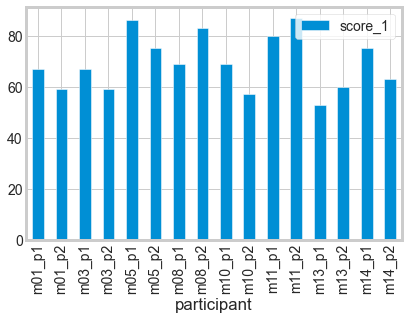

In [247]:
m_scores_1_bar = m_scores_1.plot.bar()

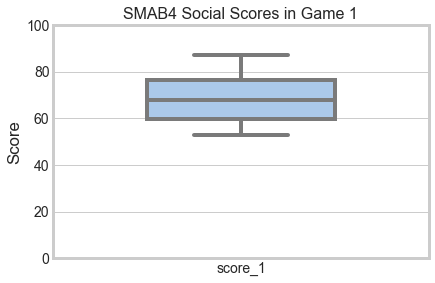

In [248]:
m_g1_scores_box = sns.boxplot( 
                 data=m_scores_1, 
                 width=0.5,
                 palette="pastel")
m_g1_scores_box.axes.set_title("SMAB4 Social Scores in Game 1",
                    fontsize=16)

plot_file_name="m_g1_score_box.jpg"
 
plt.ylim(0, 100)
m_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')


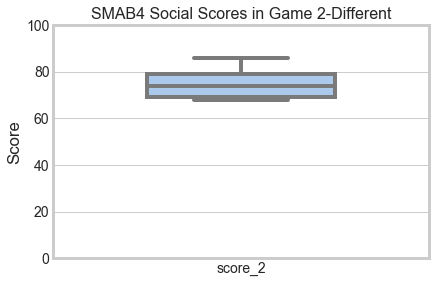

In [249]:
m_g2d_scores_box = sns.boxplot( 
                 data=m_scores_2_d, 
                 width=0.5,
                 palette="pastel")
m_g2d_scores_box.axes.set_title("SMAB4 Social Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="m_g2d_score_box.jpg"
 
plt.ylim(0, 100)
m_g2d_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g2d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

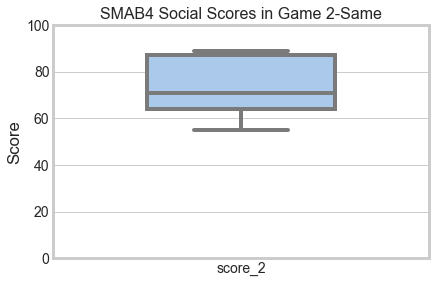

In [250]:
m_g2s_scores_box = sns.boxplot( 
                 data=m_scores_2_s, 
                 width=0.5,
                 palette="pastel")
m_g2s_scores_box.axes.set_title("SMAB4 Social Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="m_g2s_score_box.jpg"
 
plt.ylim(0, 100)
m_g2s_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g2s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [251]:
m_scores_2s_mean = m_scores_2_s.mean()

In [252]:
m_scores_2s_std = m_scores_2_s.std()

In [253]:
m_scores_2d_mean = m_scores_2_d.mean()

In [254]:
m_scores_2d_std = m_scores_2_d.std()

In [255]:
m_scores_2s_mean, m_scores_2s_std

(score_2    73.785714
 dtype: float64,
 score_2    12.292453
 dtype: float64)

In [256]:
m_scores_2d_mean, m_scores_2d_std

(score_2    75.0
 dtype: float64,
 score_2    7.402702
 dtype: float64)

In [257]:
sp.stats.ttest_ind(m_scores_2_s, m_scores_2_d)

Ttest_indResult(statistic=array([-0.22316038]), pvalue=array([0.82592361]))

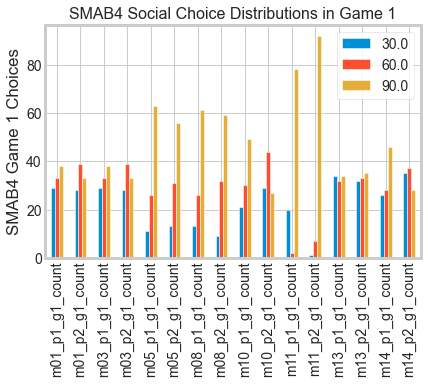

In [258]:
'''Here we place the counts of how many times each hole was chosen into dataframes for games 1 and 2. We also 
get statistics on this data and plot it.'''

# # Multi combined choices in G1

# In[ ]:


m_g1_counts = pd.DataFrame([m01_p1_g1_count, m01_p2_g1_count, m03_p1_g1_count, m03_p2_g1_count, m05_p1_g1_count, m05_p2_g1_count ,m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['m01_p1_g1_count', 'm01_p2_g1_count', 'm03_p1_g1_count', 'm03_p2_g1_count', 'm05_p1_g1_count', 'm05_p2_g1_count', 
                 'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count']) 

# In[ ]:


m_g1_counts = m_g1_counts.fillna(0) 



# In[ ]:


m_g1_counts


# In[ ]:


m_g1_counts.sum(axis=1)


# In[ ]:

# save as jpeg


m_g1_counts_bar = m_g1_counts.plot.bar()

m_g1_counts_bar.axes.set(ylabel='SMAB4 Game 1 Choices')

m_g1_counts_bar.axes.set_title("SMAB4 Social Choice Distributions in Game 1",fontsize=16)

m_g1_counts_bar.figure.savefig("m1_g1_counts_bar.jpg",
                    format='jpeg')

In [259]:
m01_p1_g1_count

60.0    33
30.0    29
90.0    38
Name: probability, dtype: int64

In [260]:
m_g1_counts

30.0  60.0  90.0
m01_p1_g1_count    29    33    38
m01_p2_g1_count    28    39    33
m03_p1_g1_count    29    33    38
m03_p2_g1_count    28    39    33
m05_p1_g1_count    11    26    63
m05_p2_g1_count    13    31    56
m08_p1_g1_count    13    26    61
m08_p2_g1_count     9    32    59
m10_p1_g1_count    21    30    49
m10_p2_g1_count    29    44    27
m11_p1_g1_count    20     2    78
m11_p2_g1_count     1     7    92
m13_p1_g1_count    34    32    34
m13_p2_g1_count    32    33    35
m14_p1_g1_count    26    28    46
m14_p2_g1_count    35    37    28

In [261]:
len(m_g1_counts)

16

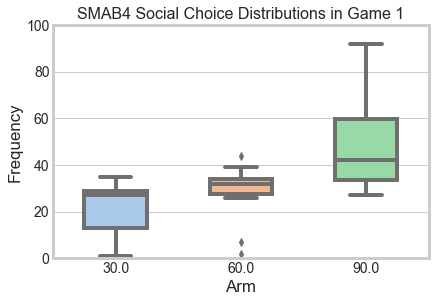

In [262]:
# In[ ]:


m_g1_counts_box = sns.boxplot( 
                 data = m_g1_counts, 
                 width=0.5,
                 palette="pastel")
m_g1_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="m_g1_counts_box.jpg"
 
plt.ylim(0, 100)
m_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [263]:
# In[ ]:


m_g1_low = np.mean(m_g1_counts.iloc[:,0])
m_g1_med = np.mean(m_g1_counts.iloc[:,1])
m_g1_high = np.mean(m_g1_counts.iloc[:,2])


# In[ ]:


m_g1_low


# In[ ]:


m_g1_med


# In[ ]:


m_g1_high


# In[ ]:


m_g1_low_std = np.std(m_g1_counts.iloc[:,0])
m_g1_med_std = np.std(m_g1_counts.iloc[:,1])
m_g1_high_std = np.std(m_g1_counts.iloc[:,2])


# In[ ]:


m_g1_low_std


# In[ ]:


m_g1_med_std


# In[ ]:


m_g1_high_std


# # Multi combined choices in G2

# In[ ]:


m_g2_counts = pd.DataFrame([m05_p1_g2_count, m05_p2_g2_count, m06_p1_g2_count, m06_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['m05_p1_g2_count', 'm05_p2_g2_count', 'm06_p1_g2_count', 'm06_p2_g2_count',
                 'm08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])


# In[ ]:


m_g2_counts = m_g2_counts.fillna(0) 


# In[ ]:


m_g2_counts


# In[ ]:


m_g2_counts.sum(axis=1)


# In[ ]:

m05_p1_g2_count    100.0
m05_p2_g2_count    100.0
m06_p1_g2_count    100.0
m06_p2_g2_count    100.0
m08_p1_g2_count    100.0
m08_p2_g2_count    100.0
m10_p1_g2_count    100.0
m10_p2_g2_count    100.0
m11_p1_g2_count    100.0
m11_p2_g2_count    100.0
m13_p1_g2_count    100.0
m13_p2_g2_count    100.0
m14_p1_g2_count    100.0
m14_p2_g2_count    100.0
dtype: float64

In [264]:
m_scores_1

score_1
participant         
m01_p1            67
m01_p2            59
m03_p1            67
m03_p2            59
m05_p1            86
m05_p2            75
m08_p1            69
m08_p2            83
m10_p1            69
m10_p2            57
m11_p1            80
m11_p2            87
m13_p1            53
m13_p2            60
m14_p1            75
m14_p2            63

In [265]:
m_scores_mean_1 = np.mean(m_scores_1)
m_scores_std_1 = np.std(m_scores_1)

In [266]:
m_scores_mean_1

score_1    69.3125
dtype: float64

In [267]:
m_scores_std_1

score_1    10.384596
dtype: float64

In [268]:
m_g1_low, m_g1_med, m_g1_high

(22.375, 29.5, 48.125)

In [269]:
m_g1_low_std, m_g1_med_std, m_g1_high_std

(9.82264602843857, 10.571187255932987, 18.158589565271857)

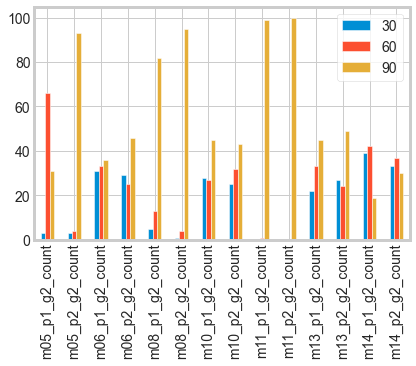

In [270]:
m_g2_counts_bar = m_g2_counts.plot.bar()

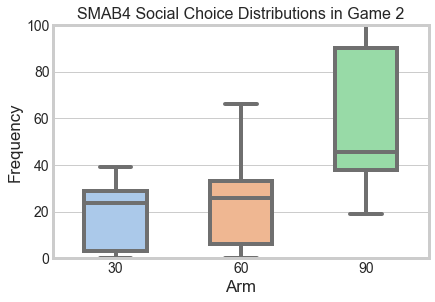

In [271]:
m_g2_counts_box = sns.boxplot( 
                 data = m_g2_counts, 
                 width=0.5,
                 palette="pastel")
m_g2_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="m_g2_counts_box.jpg"
 
plt.ylim(0, 100)
m_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [272]:
# In[ ]:


m_g2_low = np.mean(m_g2_counts.iloc[:,0])
m_g2_med = np.mean(m_g2_counts.iloc[:,1])
m_g2_high = np.mean(m_g2_counts.iloc[:,2])


# In[ ]:


m_g2_low


# In[ ]:


m_g2_med


# In[ ]:


m_g2_high


# In[ ]:


m_g2_low_std = np.std(m_g2_counts.iloc[:,0])
m_g2_med_std = np.std(m_g2_counts.iloc[:,1])
m_g2_high_std = np.std(m_g2_counts.iloc[:,2])


# In[ ]:


m_g2_low_std


# In[ ]:


m_g2_med_std


# In[ ]:


m_g2_high_std


# # Multi combined arrays

# In[ ]:


#pip install researchpy


# In[ ]:


import researchpy as rp


# In[ ]:


m_90_1 = np.array(m_g1_counts.iloc[:,2])
m_90_2 = np.array(m_g2_counts.iloc[:,2])


# In[ ]:


m_90_1


# In[ ]:


m_90_2


# In[ ]:


m_60_1 = np.array(m_g1_counts.iloc[:,1])
m_60_2 = np.array(m_g2_counts.iloc[:,1])


# In[ ]:


m_60_1


# In[ ]:


m_60_2


# In[ ]:


m_30_1 = np.array(m_g1_counts.iloc[:,0])
m_30_2 = np.array(m_g2_counts.iloc[:,0])


# In[ ]:


m_30_1


# In[ ]:


m_30_2


# # Multi combined choice statistics

# In[ ]:

'''
m_90_p = sp.stats.ttest_rel(m_90_1,m_90_2)
m_60_p = sp.stats.ttest_rel(m_60_1,m_60_2)
m_30_p = sp.stats.ttest_rel(m_30_1,m_30_2)


# In[ ]:


m_90_p


# In[ ]:


m_60_p


# In[ ]:


m_30_p


# In[ ]:


#maximizing and matching?'''

'\nm_90_p = sp.stats.ttest_rel(m_90_1,m_90_2)\nm_60_p = sp.stats.ttest_rel(m_60_1,m_60_2)\nm_30_p = sp.stats.ttest_rel(m_30_1,m_30_2)\n\n\n# In[ ]:\n\n\nm_90_p\n\n\n# In[ ]:\n\n\nm_60_p\n\n\n# In[ ]:\n\n\nm_30_p\n\n\n# In[ ]:\n\n\n#maximizing and matching?'

In [273]:
'''Here we combine scores from SMAB3 and SMAB4 in one dataframe'''

# # SOCIAL (total) scores G1


social_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 
                                               'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 
                                               'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2','m01_p1','m01_p2', 'm03_p1','m03_p2', 'm05_p1', 'm05_p2','m06_p1', 'm07_p1', 
                                                'm07_p2',
                                               'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 
                                               'm14_p1', 'm14_p2'], 'social_score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score,
      m01_p1_g1_score, m01_p2_g1_score, m03_p1_g1_score, m03_p2_g1_score, m05_p1_g1_score, m05_p2_g1_score, m06_p1_g1_score, m06_p2_g1_score,m07_p1_g1_score, m07_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
social_scores_1.set_index('participant', inplace=True, drop=True)
social_scores_1


# # SOCIAL (total) scores G2

# In[ ]:

'''
social_scores_2 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1',
                        'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2', 
                           'm05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'social_score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score, j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score, m05_p1_g2_score, m05_p2_g2_score, m06_p1_g2_score, m06_p2_g2_score, m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score, m14_p1_g2_score, m14_p2_g2_score]})
social_scores_2.set_index('participant', inplace=True, drop=True)
social_scores_2'''


# In[ ]:
'''

social_scores = pd.merge(social_scores_1, social_scores_2, on = 'participant')
social_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
social_scores


# In[ ]:


#export to excel
social_scores.to_excel("output14.xlsx")  


# In[ ]:


social_scores=social_scores.sum(axis=1)


# In[ ]:


social_scores.sort_values(inplace=True)


# In[ ]:


social_scores


# In[ ]:


social_scores_1_mean = social_scores_1.mean()


# In[ ]:


social_scores_1_mean


# In[ ]:


social_scores_1_std = social_scores_1.std()


# In[ ]:


social_scores_1_std


# In[ ]:


#social_scores_2_mean = social_scores_2.mean()


# In[ ]:


#social_scores_2_mean


# In[ ]:


#social_scores_2_std = social_scores_2.std()


# In[ ]:


#social_scores_2_std


# In[ ]:


#social_scores_med = social_scores.median()
#social_scores_med


# In[ ]:


#social_scores_p = sp.stats.ttest_rel(social_scores_1,social_scores_2)


# In[ ]:


#social_scores_p


# # Arm1

# In[ ]:'''

'\n\nsocial_scores = pd.merge(social_scores_1, social_scores_2, on = \'participant\')\nsocial_scores.columns=[\'Game 1\',\'Game 2\']\n#jp1_scores.set_index(\'participant\', inplace=True, drop=True)\nsocial_scores\n\n\n# In[ ]:\n\n\n#export to excel\nsocial_scores.to_excel("output14.xlsx")  \n\n\n# In[ ]:\n\n\nsocial_scores=social_scores.sum(axis=1)\n\n\n# In[ ]:\n\n\nsocial_scores.sort_values(inplace=True)\n\n\n# In[ ]:\n\n\nsocial_scores\n\n\n# In[ ]:\n\n\nsocial_scores_1_mean = social_scores_1.mean()\n\n\n# In[ ]:\n\n\nsocial_scores_1_mean\n\n\n# In[ ]:\n\n\nsocial_scores_1_std = social_scores_1.std()\n\n\n# In[ ]:\n\n\nsocial_scores_1_std\n\n\n# In[ ]:\n\n\n#social_scores_2_mean = social_scores_2.mean()\n\n\n# In[ ]:\n\n\n#social_scores_2_mean\n\n\n# In[ ]:\n\n\n#social_scores_2_std = social_scores_2.std()\n\n\n# In[ ]:\n\n\n#social_scores_2_std\n\n\n# In[ ]:\n\n\n#social_scores_med = social_scores.median()\n#social_scores_med\n\n\n# In[ ]:\n\n\n#social_scores_p = sp.stats.ttest_rel

In [274]:
#combine joint hole count dataframes 
#make index just the participant code
#combine control_counts_2 and control_counts_1

#modify the index to be only participant
subjects_1 = m_g1_counts.index.to_numpy()
#subjects_2 = m_g2_counts.index.to_numpy()

subjects_new1 = np.array([])
#subjects_new2 = np.array([])

ii = 0
for i in subjects_1:
    subjects_new1 = np.append(subjects_new1,subjects_1[ii][0:6])
    ii = ii +1
    
iii = 0
for i in subjects_2:
    subjects_new2 = np.append(subjects_new2,subjects_2[iii][0:6])
    iii = iii +1

m_g1_counts.index = subjects_new1
#m_g2_counts.index = subjects_new2

m_counts = m_g1_counts.merge(m_g2_counts,right_index=True,left_index=True)

In [275]:
m_counts

Empty DataFrame
Columns: [30.0_x, 60.0_x, 90.0_x, 30_y, 60_y, 90_y]
Index: []

In [276]:
'Here we get the reaction times'
time_m_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_m_2 = pd.DataFrame(columns = ['session','post win','post loss'])

time_m_1 = reaction_time(m05_p1_g1, time_m_1)
time_m_1 = reaction_time(m06_p1_g1, time_m_1)
time_m_1 = reaction_time(m08_p1_g1, time_m_1)
time_m_1 = reaction_time(m10_p1_g1, time_m_1)
time_m_1 = reaction_time(m11_p1_g1, time_m_1)
time_m_1 = reaction_time(m13_p1_g1, time_m_1)
time_m_1 = reaction_time(m14_p1_g1, time_m_1)
time_m_1 = reaction_time(m05_p2_g1, time_m_1)
time_m_1 = reaction_time(m06_p2_g1, time_m_1)
time_m_1 = reaction_time(m08_p2_g1, time_m_1)
time_m_1 = reaction_time(m10_p2_g1, time_m_1)
time_m_1 = reaction_time(m11_p2_g1, time_m_1)
time_m_1 = reaction_time(m13_p2_g1, time_m_1)
time_m_1 = reaction_time(m14_p2_g1, time_m_1)

time_m_2 = reaction_time(m05_p1_g2, time_m_2)
time_m_2 = reaction_time(m06_p1_g2, time_m_2)
time_m_2 = reaction_time(m08_p1_g2, time_m_2)
time_m_2 = reaction_time(m10_p1_g2, time_m_2)
time_m_2 = reaction_time(m11_p1_g2, time_m_2)
time_m_2 = reaction_time(m13_p1_g2, time_m_2)
time_m_2 = reaction_time(m14_p1_g2, time_m_2)
time_m_2 = reaction_time(m05_p2_g2, time_m_2)
time_m_2 = reaction_time(m06_p2_g2, time_m_2)
time_m_2 = reaction_time(m08_p2_g2, time_m_2)
time_m_2 = reaction_time(m10_p2_g2, time_m_2)
time_m_2 = reaction_time(m11_p2_g2, time_m_2)
time_m_2 = reaction_time(m13_p2_g2, time_m_2)
time_m_2 = reaction_time(m14_p2_g2, time_m_2)

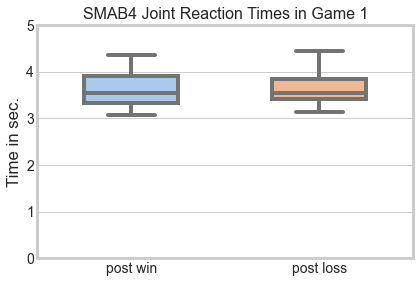

In [277]:
times_m_g1_box = sns.boxplot( 
                 data=time_m_1, 
                 width=0.5,
                 palette="pastel")
times_m_g1_box.axes.set_title("SMAB4 Joint Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_m_g1_box.jpg"
 
plt.ylim(0, 5)
times_m_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_m_g1_box.figure.savefig(plot_file_name,format='jpeg')

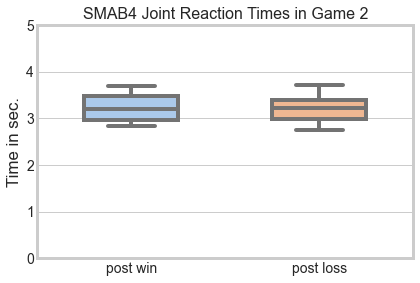

In [278]:
times_m_g2_box = sns.boxplot( 
                 data=time_m_2, 
                 width=0.5,
                 palette="pastel")
times_m_g2_box.axes.set_title("SMAB4 Joint Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_m_g2_box.jpg"
 
plt.ylim(0, 5)
times_m_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_m_g2_box.figure.savefig(plot_file_name,format='jpeg')

In [279]:
np.mean(time_m_1)

post win     3.626935
post loss    3.656920
dtype: float64

In [280]:
np.mean(time_m_2)

post win     3.426058
post loss    3.214477
dtype: float64

In [281]:
np.std(time_m_1)

post win     0.388043
post loss    0.357404
dtype: float64

In [282]:
np.std(time_m_2)

post win     0.823263
post loss    0.280154
dtype: float64

In [283]:
sp.stats.ttest_rel(time_m_1['post win'], time_m_1['post loss'])

Ttest_relResult(statistic=-0.7438584283556953, pvalue=0.4701941413958608)

In [284]:
sp.stats.ttest_rel(time_m_2['post win'], time_m_2['post loss'])

Ttest_relResult(statistic=0.9748098200412652, pvalue=0.3474456609541037)

In [285]:
sp.stats.ttest_rel(time_m_1['post win'], time_m_2['post win'])

Ttest_relResult(statistic=0.8653075259742253, pvalue=0.4025564225265744)

In [286]:
sp.stats.ttest_rel(time_m_1['post loss'], time_m_2['post loss'])

Ttest_relResult(statistic=5.168850202010096, pvalue=0.00018063098116127718)

# Test for differences between SMAB3 and SMAB4 in multi-player data

In [287]:
#simple t-test for score 
sp.stats.ttest_ind(m_scores_1, j_scores_1)

Ttest_indResult(statistic=array([0.72402656]), pvalue=array([0.47400215]))

In [288]:
social_scores_1

social_score_1
participant                
j01_p1                   57
j01_p2                   61
j02_p1                   54
j02_p2                   68
j03_p1                   69
j03_p2                   67
j04_p1                   64
j04_p2                   56
j05_p1                   77
j05_p2                   70
j06_p1                   54
j06_p2                   61
j07_p1                   74
j07_p2                   80
j08_p1                   60
j08_p2                   57
j10_p1                   66
j10_p2                   75
j11_p1                   79
j11_p2                   88
m01_p1                   67
m01_p2                   59
m03_p1                   67
m03_p2                   59
m05_p1                   86
m05_p2                   75
m06_p1                   57
m07_p1                   72
m07_p2                   80
m06_p2                   77
m08_p1                   69
m08_p2                   83
m10_p1                   69
m10_p2                   57
m11_p1                   80
m11_p2                   87
m13_p1                   53
m13_p2                   60
m14_p1                   75
m14_p2                   63

In [289]:
#combine control_score_2 and control_score_1
#social_scores = social_scores_1.merge(social_scores_2,right_index=True,left_index=True)


#convert from wide-format to long-format
#social_scores = pd.melt(social_scores,ignore_index=False)

In [290]:
subjects = social_scores_1.index.to_numpy()

In [291]:
subjects

array(['j01_p1', 'j01_p2', 'j02_p1', 'j02_p2', 'j03_p1', 'j03_p2',
       'j04_p1', 'j04_p2', 'j05_p1', 'j05_p2', 'j06_p1', 'j06_p2',
       'j07_p1', 'j07_p2', 'j08_p1', 'j08_p2', 'j10_p1', 'j10_p2',
       'j11_p1', 'j11_p2', 'm01_p1', 'm01_p2', 'm03_p1', 'm03_p2',
       'm05_p1', 'm05_p2', 'm06_p1', 'm07_p1', 'm07_p2', 'm06_p2',
       'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2',
       'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], dtype=object)

In [292]:
experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm':
        experiment = np.append(experiment,4)
        
social_scores_1['experiment'] = experiment

In [293]:
social_scores_1

social_score_1  experiment
participant                            
j01_p1                   57         3.0
j01_p2                   61         3.0
j02_p1                   54         3.0
j02_p2                   68         3.0
j03_p1                   69         3.0
j03_p2                   67         3.0
j04_p1                   64         3.0
j04_p2                   56         3.0
j05_p1                   77         3.0
j05_p2                   70         3.0
j06_p1                   54         3.0
j06_p2                   61         3.0
j07_p1                   74         3.0
j07_p2                   80         3.0
j08_p1                   60         3.0
j08_p2                   57         3.0
j10_p1                   66         3.0
j10_p2                   75         3.0
j11_p1                   79         3.0
j11_p2                   88         3.0
m01_p1                   67         4.0
m01_p2                   59         4.0
m03_p1                   67         4.0
m03_p2                   59         4.0
m05_p1                   86         4.0
m05_p2                   75         4.0
m06_p1                   57         4.0
m07_p1                   72         4.0
m07_p2                   80         4.0
m06_p2                   77         4.0
m08_p1                   69         4.0
m08_p2                   83         4.0
m10_p1                   69         4.0
m10_p2                   57         4.0
m11_p1                   80         4.0
m11_p2                   87         4.0
m13_p1                   53         4.0
m13_p2                   60         4.0
m14_p1                   75         4.0
m14_p2                   63         4.0

In [294]:
'''Here we conduct a 2 x 2 mixed measures ANOVA to compare the scores in games 1 and 2'''
#pg.mixed_anova(data=social_scores, dv='value', between='experiment', within='variable', subject='participant')

'Here we conduct a 2 x 2 mixed measures ANOVA to compare the scores in games 1 and 2'

In [295]:
import patsy

In [296]:
'''Here we conduct a linear regression to compare the scores in games 1 and 2
outcome_1,predictors_1 = patsy.dmatrices("value ~ variable + experiment", social_scores)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())'''

'Here we conduct a linear regression to compare the scores in games 1 and 2\noutcome_1,predictors_1 = patsy.dmatrices("value ~ variable + experiment", social_scores)\nmod_1 = sm.OLS(outcome_1,predictors_1)\nres_1 = mod_1.fit()\n\nprint(res_1.summary())'

# Testing for differences b/w SMAB3 and 4

In [297]:
#combine m_counts and j_counts
joint_g1_counts = m_g1_counts.append(j_g1_counts)

In [298]:
joint_g1_counts = joint_g1_counts.melt(ignore_index=False)

In [299]:
joint_g1_counts

variable  value
m01_p1      30.0   29.0
m01_p2      30.0   28.0
m03_p1      30.0   29.0
m03_p2      30.0   28.0
m05_p1      30.0   11.0
...          ...    ...
j08_p2      90.0   37.0
j10_p1      90.0   48.0
j10_p2      90.0   59.0
j11_p1      90.0   60.0
j11_p2      90.0   92.0

[108 rows x 2 columns]

In [300]:
joint_g1_counts

variable  value
m01_p1      30.0   29.0
m01_p2      30.0   28.0
m03_p1      30.0   29.0
m03_p2      30.0   28.0
m05_p1      30.0   11.0
...          ...    ...
j08_p2      90.0   37.0
j10_p1      90.0   48.0
j10_p2      90.0   59.0
j11_p1      90.0   60.0
j11_p2      90.0   92.0

[108 rows x 2 columns]

In [301]:
confed_g1_counts = c_g1_counts.append(s_g1_counts)
confed_g1_counts = confed_g1_counts.melt(ignore_index=False)

In [302]:
g1_counts = confed_g1_counts.append(joint_g1_counts)

In [303]:
g1_counts

variable  value
c01_p1_g1_count      30.0   23.0
c02_p1_g1_count      30.0   13.0
c03_p1_g1_count      30.0   12.0
c04_p1_g1_count      30.0    8.0
c05_p1_g1_count      30.0   34.0
...                   ...    ...
j08_p2               90.0   37.0
j10_p1               90.0   48.0
j10_p2               90.0   59.0
j11_p1               90.0   60.0
j11_p2               90.0   92.0

[204 rows x 2 columns]

In [304]:
#add another column to scores indicating whether it's the single or multiplayer

subjects = g1_counts.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

g1_counts['condition'] = condition

In [305]:
#add column to joint_counts indicating whether it's SMAB3 or 4
subjects = g1_counts.index.to_numpy()

experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j' or [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm' or [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
g1_counts['experiment'] = experiment

In [306]:
g1_counts

variable  value condition  experiment
c01_p1_g1_count      30.0   23.0   control         4.0
c02_p1_g1_count      30.0   13.0   control         4.0
c03_p1_g1_count      30.0   12.0   control         4.0
c04_p1_g1_count      30.0    8.0   control         4.0
c05_p1_g1_count      30.0   34.0   control         4.0
...                   ...    ...       ...         ...
j08_p2               90.0   37.0    social         3.0
j10_p1               90.0   48.0    social         3.0
j10_p2               90.0   59.0    social         3.0
j11_p1               90.0   60.0    social         3.0
j11_p2               90.0   92.0    social         3.0

[204 rows x 4 columns]

In [307]:
#break up counts dataframe into 30,60,90
grouped = g1_counts.groupby(g1_counts.variable)
g1_counts_30 = grouped.get_group(30.0)
g1_counts_60 = grouped.get_group(60.0)
g1_counts_90 = grouped.get_group(90.0)

In [308]:
g1_counts_30

variable  value condition  experiment
c01_p1_g1_count      30.0   23.0   control         4.0
c02_p1_g1_count      30.0   13.0   control         4.0
c03_p1_g1_count      30.0   12.0   control         4.0
c04_p1_g1_count      30.0    8.0   control         4.0
c05_p1_g1_count      30.0   34.0   control         4.0
...                   ...    ...       ...         ...
j08_p2               30.0   40.0    social         3.0
j10_p1               30.0   24.0    social         3.0
j10_p2               30.0   14.0    social         3.0
j11_p1               30.0    0.0    social         3.0
j11_p2               30.0    2.0    social         3.0

[68 rows x 4 columns]

In [309]:
#run 2x2 between measures ANOVA for the 90 hole
pg.anova(data=g1_counts_90, dv='value', between=['experiment','condition'])

Source            SS    DF          MS         F     p-unc  \
0              experiment    161.217099   1.0  161.217099  0.388360  0.535377   
1               condition    590.891954   1.0  590.891954  1.423414  0.237246   
2  experiment * condition    200.761496   1.0  200.761496  0.483619  0.489305   
3                Residual  26567.868627  64.0  415.122947       NaN       NaN   

        np2  
0  0.006032  
1  0.021757  
2  0.007500  
3       NaN

In [310]:
#run 2x2 between measures ANOVA for the 30 hole
pg.anova(data=g1_counts_30, dv='value', between=['experiment','condition'])

Source           SS    DF          MS         F     p-unc  \
0              experiment    14.689198   1.0   14.689198  0.113635  0.737147   
1               condition   381.215460   1.0  381.215460  2.949054  0.090764   
2  experiment * condition    87.608515   1.0   87.608515  0.677733  0.413426   
3                Residual  8273.091176  64.0  129.267050       NaN       NaN   

        np2  
0  0.001772  
1  0.044049  
2  0.010479  
3       NaN

In [311]:
#combine m_score and j_score
joint_g1_score = m_scores_1.append(j_scores_1)
joint_g1_score = joint_g1_score.melt(ignore_index=False)

In [312]:
#combine c_score and s_score
confed_g1_score = c_scores_1.append(s_scores_1)
confed_g1_score = confed_g1_score.melt(ignore_index=False)

In [313]:
g1_score = joint_g1_score.append(confed_g1_score)

In [314]:
g1_score

variable  value
participant                
m01_p1       score_1   67.0
m01_p2       score_1   59.0
m03_p1       score_1   67.0
m03_p2       score_1   59.0
m05_p1       score_1   86.0
...              ...    ...
s15          score_1   74.0
s16          score_1   59.0
s17          score_1   84.0
s19          score_1   72.0
s20          score_1   59.0

[100 rows x 2 columns]

In [315]:
#add another column to scores indicating whether it's the single or multiplayer

subjects = g1_score.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

g1_score['condition'] = condition

In [316]:
#add column to joint_score indicating whether it's SMAB3 or 4
subjects = g1_score.index.to_numpy()

experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j' or [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm' or [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
g1_score['experiment'] = experiment

In [317]:
pd.set_option('display.max_rows', None)

In [318]:
g1_score = g1_score.dropna()

In [319]:
len(g1_score)

68

In [320]:
#run 2x2 between measures ANOVA for the score
pg.anova(data=g1_score, dv='value', between=['experiment','condition'])

Source           SS    DF          MS         F     p-unc  \
0              experiment     0.814230   1.0    0.814230  0.008019  0.928926   
1               condition    79.056808   1.0   79.056808  0.778585  0.380877   
2  experiment * condition   135.288262   1.0  135.288262  1.332375  0.252675   
3                Residual  6498.505147  64.0  101.539143       NaN       NaN   

        np2  
0  0.000125  
1  0.012019  
2  0.020394  
3       NaN

# Test for differences in SMAB3 and SMAB4 including single and multiplayer

In [321]:
#simple t-test for score 
sp.stats.ttest_ind(c_scores_1, s_scores_1)

Ttest_indResult(statistic=array([-0.90626804]), pvalue=array([0.37201581]))

In [322]:
sp.stats.ttest_ind(c_scores_1, m_scores_1)

Ttest_indResult(statistic=array([-0.21216598]), pvalue=array([0.83336642]))

In [323]:
sp.stats.ttest_ind(c_scores_1, m_scores_1)

Ttest_indResult(statistic=array([-0.21216598]), pvalue=array([0.83336642]))

In [324]:
sp.stats.ttest_ind(s_scores_1, j_scores_1)

Ttest_indResult(statistic=array([1.40300379]), pvalue=array([0.16995492]))

In [325]:
'''Here we combine all of the scores (all games, confed and multiplayer, SMAB 3 and 4)
scores = control_scores.append(social_scores)'''

'Here we combine all of the scores (all games, confed and multiplayer, SMAB 3 and 4)\nscores = control_scores.append(social_scores)'

In [326]:
j_scores_1

score_1
participant         
j01_p1            57
j01_p2            61
j02_p1            54
j02_p2            68
j03_p1            69
j03_p2            67
j04_p1            64
j04_p2            56
j05_p1            77
j05_p2            70
j06_p1            54
j06_p2            61
j07_p1            74
j07_p2            80
j08_p1            60
j08_p2            57
j10_p1            66
j10_p2            75
j11_p1            79
j11_p2            88

In [327]:
#combnine all SMAB3 scores
j_scores_1 = j_scores_1.rename(columns={"score_1": "Game 1", "score_2": "Game 2"})
#smab3_scores = s_scores.append(j_scores)

In [328]:
'''
smab3_scores_1_mean = smab3_scores['Game 1'].mean()
smab3_scores_1_std = smab3_scores['Game 1'].std()
smab3_scores_2_mean = smab3_scores['Game 2'].mean()
smab3_scores_2_std = smab3_scores['Game 2'].std()'''

"\nsmab3_scores_1_mean = smab3_scores['Game 1'].mean()\nsmab3_scores_1_std = smab3_scores['Game 1'].std()\nsmab3_scores_2_mean = smab3_scores['Game 2'].mean()\nsmab3_scores_2_std = smab3_scores['Game 2'].std()"

In [329]:
#smab3_scores_1_mean, smab3_scores_1_std, smab3_scores_2_mean, smab3_scores_2_std

In [330]:
#working on now
'''
smab3_scores_box = sns.boxplot( 
                 data=smab3_scores,
                 width=0.5,
                 palette="pastel")
smab3_scores_box.axes.set_title("SMAB3 Scores (Control and Social)",
                    fontsize=16)

plot_file_name="smab3_score_box.jpg"
 
plt.ylim(0, 100)
smab3_scores_box.axes.set(ylabel='Score')

# save as jpeg
smab3_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'\nsmab3_scores_box = sns.boxplot( \n                 data=smab3_scores,\n                 width=0.5,\n                 palette="pastel")\nsmab3_scores_box.axes.set_title("SMAB3 Scores (Control and Social)",\n                    fontsize=16)\n\nplot_file_name="smab3_score_box.jpg"\n \nplt.ylim(0, 100)\nsmab3_scores_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nsmab3_scores_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

In [331]:
#combnine all SMAB4 scores
#c_scores = c_scores.rename(columns={"confederate_score_1": "Game 1", "confederate_score_2": "Game 2"})
#m_scores = m_scores.rename(columns={"score_1": "Game 1", "score_2": "Game 2"})
#smab4_scores = c_scores.append(m_scores)

In [332]:
#smab4_scores

In [333]:
'''
smab4_scores_box = sns.boxplot( 
                 data=smab4_scores,
                 width=0.5,
                 palette="pastel")
smab4_scores_box.axes.set_title("SMAB4 Scores (Control and Social)",
                    fontsize=16)

plot_file_name="smab4_score_box.jpg"
 
plt.ylim(0, 100)
smab4_scores_box.axes.set(ylabel='Score')

# save as jpeg
smab4_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'\nsmab4_scores_box = sns.boxplot( \n                 data=smab4_scores,\n                 width=0.5,\n                 palette="pastel")\nsmab4_scores_box.axes.set_title("SMAB4 Scores (Control and Social)",\n                    fontsize=16)\n\nplot_file_name="smab4_score_box.jpg"\n \nplt.ylim(0, 100)\nsmab4_scores_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nsmab4_scores_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

In [334]:
#add another column to scores indicating whether it's the single or multiplayer

subjects = scores.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

scores['condition'] = condition

In [335]:
print(scores)

Empty DataFrame
Columns: [s_g1, s_g2, c_g1, c_g2, j_g1, j_g2, m_g1, m_g2, condition]
Index: []


In [336]:
scores = scores.reset_index()

In [337]:
scores

Empty DataFrame
Columns: [index, s_g1, s_g2, c_g1, c_g2, j_g1, j_g2, m_g1, m_g2, condition]
Index: []

In [338]:
scores.to_csv('scores.csv')

In [339]:
#NEED
#pg.mixed_anova(data=scores, dv='value', between=['experiment','condition'], within='variable', subject='participant')

In [340]:
#using statsmodels instead of pingouin
#sm.AnovaRM(scores, 'value', 'participant', within=within, between='experiment', aggregate_func=None)

In [341]:
#scores = control_scores.append(social_scores)

# Test for differences looking at all the value counts data with the holes denoted by probability

In [342]:
#30 hole choices in g1
sp.stats.ttest_ind(m_g1_counts.iloc[:,0], j_g1_counts.iloc[:,0])

Ttest_indResult(statistic=-0.29924634488022334, pvalue=0.7665737326048662)

In [343]:
#90 hole choices in g1
sp.stats.ttest_ind(m_g1_counts.iloc[:,2], j_g1_counts.iloc[:,2])

Ttest_indResult(statistic=0.028277849204708425, pvalue=0.9776058813153828)

In [344]:
#30 hole choices in g1
sp.stats.ttest_ind(c_g1_counts.iloc[:,0], s_g1_counts.iloc[:,0])

Ttest_indResult(statistic=0.9120136411195359, pvalue=0.3690324664124246)

In [345]:
#90 hole choices in g1
sp.stats.ttest_ind(c_g1_counts.iloc[:,2], s_g1_counts.iloc[:,2])

Ttest_indResult(statistic=-0.8507304833741187, pvalue=0.4016584362555313)

In [346]:
#combine joint_counts and control_counts
#counts = joint_counts.append(control_counts)

In [347]:
#add another column to counts indicating whether it's the single or multiplayer
'''
subjects = counts.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

counts['condition'] = condition'''

"\nsubjects = counts.index.to_numpy()\n\ncondition = np.array([])\n\nfor i in subjects:\n    if [i][0][0] == 's' or [i][0][0] == 'c':\n        condition = np.append(condition,'control')\n    elif [i][0][0] == 'm' or [i][0][0] == 'j':\n        condition = np.append(condition,'social')\n\ncounts['condition'] = condition"

In [348]:
'''
#add another column to counts indiciating whether it's SMAB 3 or 4

subjects = counts.index.to_numpy()


experiment = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'j':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'c' or [i][0][0] == 'm':
        experiment = np.append(experiment,4)
        
counts['experiment'] = experiment'''

"\n#add another column to counts indiciating whether it's SMAB 3 or 4\n\nsubjects = counts.index.to_numpy()\n\n\nexperiment = np.array([])\n\nfor i in subjects:\n    if [i][0][0] == 's' or [i][0][0] == 'j':\n        experiment = np.append(experiment,3)\n    elif [i][0][0] == 'c' or [i][0][0] == 'm':\n        experiment = np.append(experiment,4)\n        \ncounts['experiment'] = experiment"

In [349]:
#break up counts dataframe into 30,60,90
#grouped = counts.groupby(counts.variable)
'''
counts_30 = grouped.get_group("30")
counts_60 = grouped.get_group("60")
counts_90 = grouped.get_group("90")'''

'\ncounts_30 = grouped.get_group("30")\ncounts_60 = grouped.get_group("60")\ncounts_90 = grouped.get_group("90")'

In [350]:
#run 2x2 between measures ANOVA for the 90 hole
#pg.anova(data=counts_90, dv='value', between=['experiment','condition'])

In [351]:
#run 2x2 between measures ANOVA for the 60 hole
#pg.anova(data=counts_60, dv='value', between=['experiment','condition'])

In [352]:
import statsmodels

In [353]:
#plot interaction
'''
int_60 = sm.graphics.interaction_plot(counts_60['experiment'], counts_60['condition'], counts_60['value'],
           colors=['red','blue'], markers=['D','^'], ms=10)'''

"\nint_60 = sm.graphics.interaction_plot(counts_60['experiment'], counts_60['condition'], counts_60['value'],\n           colors=['red','blue'], markers=['D','^'], ms=10)"

In [354]:
'''
int_90 = sm.graphics.interaction_plot(counts_90['experiment'], counts_90['condition'], counts_90['value'],
           colors=['red','blue'], markers=['D','^'], ms=10)'''

"\nint_90 = sm.graphics.interaction_plot(counts_90['experiment'], counts_90['condition'], counts_90['value'],\n           colors=['red','blue'], markers=['D','^'], ms=10)"

In [355]:
m05_p1_g1_arm = m05_p1_g1['arm'].value_counts(sort=False)
m05_p1_g2_arm = m05_p1_g2['arm'].value_counts(sort=False)
m05_p2_g1_arm = m05_p2_g1['arm'].value_counts(sort=False)
m05_p2_g2_arm = m05_p2_g2['arm'].value_counts(sort=False)
m06_p1_g1_arm = m06_p1_g1['arm'].value_counts(sort=False)
m06_p1_g2_arm = m06_p1_g2['arm'].value_counts(sort=False)
m06_p2_g1_arm = m06_p2_g1['arm'].value_counts(sort=False)
m06_p2_g2_arm = m06_p2_g2['arm'].value_counts(sort=False)
m08_p1_g1_arm = m08_p1_g1['arm'].value_counts(sort=False)
m08_p1_g2_arm = m08_p1_g2['arm'].value_counts(sort=False)
m08_p2_g1_arm = m08_p2_g1['arm'].value_counts(sort=False)
m08_p2_g2_arm = m08_p2_g2['arm'].value_counts(sort=False)
m10_p1_g1_arm = m10_p1_g1['arm'].value_counts(sort=False)
m10_p1_g2_arm = m10_p1_g2['arm'].value_counts(sort=False)
m10_p2_g1_arm = m10_p2_g1['arm'].value_counts(sort=False)
m10_p2_g2_arm = m10_p2_g2['arm'].value_counts(sort=False)
m11_p1_g1_arm = m11_p1_g1['arm'].value_counts(sort=False)
m11_p1_g2_arm = m11_p1_g2['arm'].value_counts(sort=False)
m11_p2_g1_arm = m11_p2_g1['arm'].value_counts(sort=False)
m11_p2_g2_arm = m11_p2_g2['arm'].value_counts(sort=False)
m13_p1_g1_arm = m13_p1_g1['arm'].value_counts(sort=False)
m13_p1_g2_arm = m13_p1_g2['arm'].value_counts(sort=False)
m13_p2_g1_arm = m13_p2_g1['arm'].value_counts(sort=False)
m13_p2_g2_arm = m13_p2_g2['arm'].value_counts(sort=False)
m14_p1_g1_arm = m14_p1_g1['arm'].value_counts(sort=False)
m14_p1_g2_arm = m14_p1_g2['arm'].value_counts(sort=False)
m14_p2_g1_arm = m14_p2_g1['arm'].value_counts(sort=False)
m14_p2_g2_arm = m14_p2_g2['arm'].value_counts(sort=False)
j01_p1_g1_arm = j01_p1_g1['arm'].value_counts(sort=False)
j01_p1_g2_arm = j01_p1_g2['arm'].value_counts(sort=False)
j01_p2_g1_arm = j01_p2_g1['arm'].value_counts(sort=False)
j01_p2_g2_arm = j01_p2_g2['arm'].value_counts(sort=False)
j02_p1_g1_arm = j02_p1_g1['arm'].value_counts(sort=False)
j02_p1_g2_arm = j02_p1_g2['arm'].value_counts(sort=False)
j02_p2_g1_arm = j02_p2_g1['arm'].value_counts(sort=False)
j02_p2_g2_arm = j02_p2_g2['arm'].value_counts(sort=False)
j03_p1_g1_arm = j03_p1_g1['arm'].value_counts(sort=False)
j03_p1_g2_arm = j03_p1_g2['arm'].value_counts(sort=False)
j03_p2_g1_arm = j03_p2_g1['arm'].value_counts(sort=False)
j03_p2_g2_arm = j03_p2_g2['arm'].value_counts(sort=False)
j04_p1_g1_arm = j04_p1_g1['arm'].value_counts(sort=False)
j04_p1_g2_arm = j04_p1_g2['arm'].value_counts(sort=False)
j04_p2_g1_arm = j04_p2_g1['arm'].value_counts(sort=False)
j04_p2_g2_arm = j04_p2_g2['arm'].value_counts(sort=False)
j05_p1_g1_arm = j05_p1_g1['arm'].value_counts(sort=False)
j05_p1_g2_arm = j05_p1_g2['arm'].value_counts(sort=False)
j05_p2_g1_arm = j05_p2_g1['arm'].value_counts(sort=False)
j05_p2_g2_arm = j05_p2_g2['arm'].value_counts(sort=False)
j06_p1_g1_arm = j06_p1_g1['arm'].value_counts(sort=False)
j06_p1_g2_arm = j06_p1_g2['arm'].value_counts(sort=False)
j06_p2_g1_arm = j06_p2_g1['arm'].value_counts(sort=False)
j06_p2_g2_arm = j06_p2_g2['arm'].value_counts(sort=False)
j07_p1_g1_arm = j07_p1_g1['arm'].value_counts(sort=False)
j07_p1_g2_arm = j07_p1_g2['arm'].value_counts(sort=False)
j07_p2_g1_arm = j07_p2_g1['arm'].value_counts(sort=False)
j07_p2_g2_arm = j07_p2_g2['arm'].value_counts(sort=False)
j08_p1_g1_arm = j08_p1_g1['arm'].value_counts(sort=False)
j08_p1_g2_arm = j08_p1_g2['arm'].value_counts(sort=False)
j08_p2_g1_arm = j08_p2_g1['arm'].value_counts(sort=False)
j08_p2_g2_arm = j08_p2_g2['arm'].value_counts(sort=False)
j10_p1_g1_arm = j10_p1_g1['arm'].value_counts(sort=False)
j10_p1_g2_arm = j10_p1_g2['arm'].value_counts(sort=False)
j10_p2_g1_arm = j10_p2_g1['arm'].value_counts(sort=False)
j10_p2_g2_arm = j10_p2_g2['arm'].value_counts(sort=False)
j11_p1_g1_arm = j11_p1_g1['arm'].value_counts(sort=False)
j11_p1_g2_arm = j11_p1_g2['arm'].value_counts(sort=False)
j11_p2_g1_arm = j11_p2_g1['arm'].value_counts(sort=False)
j11_p2_g2_arm = j11_p2_g2['arm'].value_counts(sort=False)

In [356]:
# In[ ]:


social_arms_g1 = pd.DataFrame([j01_p1_g1_arm, j01_p2_g1_arm, j02_p1_g1_arm, j02_p2_g1_arm, j03_p1_g1_arm, 
              j03_p2_g1_arm, j04_p1_g1_arm, j04_p2_g1_arm, j05_p1_g1_arm, j05_p2_g1_arm, j06_p1_g1_arm, 
              j06_p2_g1_arm, j07_p1_g1_arm, j07_p2_g1_arm, j08_p1_g1_arm, j08_p2_g1_arm, 
              j10_p1_g1_arm, j10_p2_g1_arm, j11_p1_g1_arm, j11_p2_g1_arm, m05_p1_g1_arm, m05_p2_g1_arm, m06_p1_g1_arm, m06_p2_g1_arm, m08_p1_g1_arm, m08_p2_g1_arm, 
              m10_p1_g1_arm, m10_p2_g1_arm, m11_p1_g1_arm, m11_p2_g1_arm, m13_p1_g1_arm, m13_p2_g1_arm, 
              m14_p1_g1_arm, m14_p2_g1_arm],
                index = ['j01_p1_g1_arm', 'j01_p2_g1_arm', 'j02_p1_g1_arm', 'j02_p2_g1_arm', 
                 'j03_p1_g1_arm', 'j03_p2_g1_arm', 'j04_p1_g1_arm', 'j04_p2_g1_arm', 'j05_p1_g1_arm', 
                  'j05_p2_g1_arm', 'j06_p1_g1_arm', 'j06_p2_g1_arm', 'j07_p1_g1_arm', 
                    'j07_p2_g1_arm', 'j08_p1_g1_arm', 'j08_p2_g1_arm', 'j10_p1_g1_arm', 'j10_p2_g1_arm', 
                    'j11_p1_g1_arm', 'j11_p2_g1_arm', 'm05_p1_g1_arm', 'm05_p2_g1_arm', 'm06_p1_g1_arm', 'm06_p2_g1_arm',
                 'm08_p1_g1_arm', 'm08_p2_g1_arm', 'm10_p1_g1_arm', 'm10_p2_g1_arm', 'm11_p1_g1_arm', 
                'm11_p2_g1_arm', 'm13_p1_g1_arm', 'm13_p2_g1_arm', 'm14_p1_g1_arm', 'm14_p2_g1_arm'])


# In[ ]:


#How to prevent NaN: df = df.fillna(0)
social_arms_g1 = social_arms_g1.fillna(0)

#print
social_arms_g1


# In[ ]:


#export to excel
social_arms_g1.to_excel("output10.xlsx")  


# In[ ]:


social_arms_g2 = pd.DataFrame([j01_p1_g2_arm, j01_p2_g2_arm, j02_p1_g2_arm, j02_p2_g2_arm, j03_p1_g2_arm, 
              j03_p2_g2_arm, j04_p1_g2_arm, j04_p2_g2_arm, j05_p1_g2_arm, j05_p2_g2_arm, j06_p1_g2_arm, 
              j06_p2_g2_arm, j07_p1_g2_arm, j07_p2_g2_arm, j08_p1_g2_arm, j08_p2_g2_arm, 
              j10_p1_g2_arm, j10_p2_g2_arm, j11_p1_g2_arm, j11_p2_g2_arm, m05_p1_g2_arm, m05_p2_g2_arm, m06_p1_g2_arm, m06_p2_g2_arm, m08_p1_g2_arm, m08_p2_g2_arm, 
              m10_p1_g2_arm, m10_p2_g2_arm, m11_p1_g2_arm, m11_p2_g2_arm, m13_p1_g2_arm, m13_p2_g2_arm, 
              m14_p1_g2_arm, m14_p2_g2_arm],
                index = ['j01_p1_g2_arm', 'j01_p2_g2_arm', 'j02_p1_g2_arm', 'j02_p2_g2_arm', 
                 'j03_p1_g2_arm', 'j03_p2_g2_arm', 'j04_p1_g2_arm', 'j04_p2_g2_arm', 'j05_p1_g2_arm', 
                  'j05_p2_g2_arm', 'j06_p1_g2_arm', 'j06_p2_g2_arm', 'j07_p1_g2_arm', 
                    'j07_p2_g2_arm', 'j08_p1_g2_arm', 'j08_p2_g2_arm', 'j10_p1_g2_arm', 'j10_p2_g2_arm', 
                    'j11_p1_g2_arm', 'j11_p2_g2_arm', 'm05_p1_g2_arm', 'm05_p2_g2_arm', 'm06_p1_g2_arm', 'm06_p2_g2_arm',
                 'm08_p1_g2_arm', 'm08_p2_g2_arm', 'm10_p1_g2_arm', 'm10_p2_g2_arm', 'm11_p1_g2_arm', 
                'm11_p2_g2_arm', 'm13_p1_g2_arm', 'm13_p2_g2_arm', 'm14_p1_g2_arm', 'm14_p2_g2_arm'])


# In[ ]:


#How to prevent NaN: df = df.fillna(0)
social_arms_g2 = social_arms_g2.fillna(0)

#print
social_arms_g2


# In[ ]:


social_arms_g2.to_excel("output11.xlsx")  

In [357]:
social_arms_g1

1     2     3
j01_p1_g1_arm  26.0  38.0  36.0
j01_p2_g1_arm  33.0  30.0  37.0
j02_p1_g1_arm  32.0  32.0  36.0
j02_p2_g1_arm  39.0  25.0  36.0
j03_p1_g1_arm  29.0  49.0  22.0
j03_p2_g1_arm  23.0  29.0  48.0
j04_p1_g1_arm  35.0  26.0  39.0
j04_p2_g1_arm  34.0  44.0  22.0
j05_p1_g1_arm   5.0  79.0  16.0
j05_p2_g1_arm  58.0  14.0  28.0
j06_p1_g1_arm  30.0  34.0  36.0
j06_p2_g1_arm  45.0  16.0  39.0
j07_p1_g1_arm   7.0  35.0  58.0
j07_p2_g1_arm  72.0  17.0  11.0
j08_p1_g1_arm  31.0  27.0  42.0
j08_p2_g1_arm  37.0  40.0  23.0
j10_p1_g1_arm  28.0  24.0  48.0
j10_p2_g1_arm  27.0  59.0  14.0
j11_p1_g1_arm   0.0  40.0  60.0
j11_p2_g1_arm  92.0   6.0   2.0
m05_p1_g1_arm  63.0  26.0  11.0
m05_p2_g1_arm  13.0  31.0  56.0
m06_p1_g1_arm  30.0  35.0  35.0
m06_p2_g1_arm  38.0  31.0  31.0
m08_p1_g1_arm  13.0  26.0  61.0
m08_p2_g1_arm  59.0  32.0   9.0
m10_p1_g1_arm  21.0  30.0  49.0
m10_p2_g1_arm  27.0  44.0  29.0
m11_p1_g1_arm  20.0   2.0  78.0
m11_p2_g1_arm  92.0   7.0   1.0
m13_p1_g1_arm  34.0  32.0  34.0
m13_p2_g1_arm  35.0  33.0  32.0
m14_p1_g1_arm  26.0  46.0  28.0
m14_p2_g1_arm  28.0  37.0  35.0

In [358]:
# # Total social counts (Multi & Joint)

# In[ ]:


social_counts_g1 = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count, m05_p1_g1_count, m05_p2_g1_count, m06_p1_g1_count, m06_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count', 'm05_p1_g1_count', 'm05_p2_g1_count', 'm06_p1_g1_count', 'm06_p2_g1_count',
                 'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count'])


# In[ ]:


#How to prevent NaN: df = df.fillna(0)
social_counts_g1=social_counts_g1.fillna(0)


# In[ ]:


social_counts_g1


# In[ ]:


#export to excel
social_counts_g1.to_excel("output3.xlsx")  


# In[ ]:


social_counts_g1.sum(axis = 0, skipna = True)


# In[ ]:


social_counts_g1.mean(axis = 0)


# In[ ]:


social_counts_g1.sum(axis=1)


# In[ ]:


social_counts_g2 = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count, 
              j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count, m05_p1_g2_count, m05_p2_g2_count, m06_p1_g2_count, m06_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                    'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count', 'j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count', 'm05_p1_g2_count', 'm05_p2_g2_count', 'm06_p1_g2_count', 'm06_p2_g2_count',
                 'm08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])


# In[ ]:


#How to prevent NaN: df = df.fillna(0)
social_counts_g2=social_counts_g2.fillna(0)
social_counts_g2


# In[ ]:


#export to excel
social_counts_g2.to_excel("output4.xlsx")  


# In[ ]:


social_counts_g2.sum(axis=1)

j01_p1_g2_count    100.0
j01_p2_g2_count    100.0
j02_p1_g2_count    100.0
j02_p2_g2_count    100.0
j03_p1_g2_count    100.0
j03_p2_g2_count    100.0
j04_p1_g2_count    100.0
j04_p2_g2_count    100.0
j05_p1_g2_count    100.0
j05_p2_g2_count    100.0
j06_p1_g2_count    100.0
j06_p2_g2_count    100.0
j07_p1_g2_count    100.0
j07_p2_g2_count    100.0
j08_p1_g2_count    100.0
j08_p2_g2_count    100.0
j10_p1_g2_count    100.0
j10_p2_g2_count    100.0
j11_p1_g2_count    100.0
j11_p2_g2_count    100.0
m05_p1_g2_count    100.0
m05_p2_g2_count    100.0
m06_p1_g2_count    100.0
m06_p2_g2_count    100.0
m08_p1_g2_count    100.0
m08_p2_g2_count    100.0
m10_p1_g2_count    100.0
m10_p2_g2_count    100.0
m11_p1_g2_count    100.0
m11_p2_g2_count    100.0
m13_p1_g2_count    100.0
m13_p2_g2_count    100.0
m14_p1_g2_count    100.0
m14_p2_g2_count    100.0
dtype: float64

In [359]:
social_counts_g1

30    60    90
j01_p1_g1_count  38.0  36.0  26.0
j01_p2_g1_count  33.0  37.0  30.0
j02_p1_g1_count  36.0  32.0  32.0
j02_p2_g1_count  25.0  39.0  36.0
j03_p1_g1_count  22.0  29.0  49.0
j03_p2_g1_count  29.0  23.0  48.0
j04_p1_g1_count  26.0  39.0  35.0
j04_p2_g1_count  34.0  22.0  44.0
j05_p1_g1_count   5.0  16.0  79.0
j05_p2_g1_count  14.0  28.0  58.0
j06_p1_g1_count  36.0  34.0  30.0
j06_p2_g1_count  45.0  16.0  39.0
j07_p1_g1_count   7.0  35.0  58.0
j07_p2_g1_count  11.0  17.0  72.0
j08_p1_g1_count  31.0  42.0  27.0
j08_p2_g1_count  40.0  23.0  37.0
j10_p1_g1_count  24.0  28.0  48.0
j10_p2_g1_count  14.0  27.0  59.0
j11_p1_g1_count   0.0  40.0  60.0
j11_p2_g1_count   2.0   6.0  92.0
m05_p1_g1_count  11.0  26.0  63.0
m05_p2_g1_count  13.0  31.0  56.0
m06_p1_g1_count  35.0  35.0  30.0
m06_p2_g1_count  31.0  31.0  38.0
m08_p1_g1_count  13.0  26.0  61.0
m08_p2_g1_count   9.0  32.0  59.0
m10_p1_g1_count  21.0  30.0  49.0
m10_p2_g1_count  29.0  44.0  27.0
m11_p1_g1_count  20.0   2.0  78.0
m11_p2_g1_count   1.0   7.0  92.0
m13_p1_g1_count  34.0  32.0  34.0
m13_p2_g1_count  32.0  33.0  35.0
m14_p1_g1_count  26.0  28.0  46.0
m14_p2_g1_count  35.0  37.0  28.0

In [360]:
#'''Here we combine all of the hole counts identifying them by probability (all games, confed and multiplayer, SMAB 3 and 4)'''
#scores = control_scores.append(social_scores)

In [361]:
# # Maximizing/Matching SOCIAL

# In[ ]:


from scipy import stats


# In[ ]:


#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate)

#social_max = [0, 0, 100]
#social_match = [30/180 * 100,60/180 * 100, 90/180 * 100]


# In[ ]:


#Calls jsd with the social distributions.
#def call_jsd_social(counts):
   # maxi = jsd(counts,social_max)
   # matchi = jsd(counts,social_match)
    #return maxi,matchi


# In[ ]:


j01_p1_g1_max,j01_p1_g1_match,j01_p1_g1_rand,j01_p1_g1_soc = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match,j01_p1_g2_rand,j01_p1_g2_soc = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match,j01_p2_g1_rand,j01_p2_g1_soc = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match,j01_p2_g2_rand,j01_p2_g2_soc = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match,j02_p1_g1_rand,j02_p1_g1_soc = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match,j02_p1_g2_rand,j02_p1_g2_soc = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match,j02_p2_g1_rand,j02_p2_g1_soc = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match,j02_p2_g2_rand,j02_p2_g2_soc = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match,j03_p1_g1_rand,j03_p1_g1_soc = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match,j03_p1_g2_rand,j03_p1_g2_soc = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match,j03_p2_g1_rand,j03_p2_g1_soc  = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match,j03_p2_g2_rand,j03_p2_g2_soc = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match,j04_p1_g1_rand,j04_p1_g1_soc = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match,j04_p1_g2_rand,j04_p1_g2_soc = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match,j04_p2_g1_rand,j04_p2_g1_soc  = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match,j04_p2_g2_rand,j04_p2_g2_soc = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match,j05_p1_g1_rand,j05_p1_g1_soc = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match,j05_p1_g2_rand,j05_p1_g2_soc = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match,j05_p2_g1_rand,j05_p2_g1_soc = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match,j05_p2_g2_rand,j05_p2_g2_soc = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match,j06_p1_g1_rand,j06_p1_g1_soc = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match,j06_p1_g2_rand,j06_p1_g2_soc = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match,j06_p2_g1_rand,j06_p2_g1_soc = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match,j06_p2_g2_rand,j06_p2_g2_soc = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match,j07_p1_g1_rand,j07_p1_g1_soc = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match,j07_p1_g2_rand,j07_p1_g2_soc = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match,j07_p2_g1_rand,j07_p2_g1_soc = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match,j07_p2_g2_rand,j07_p2_g2_soc = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match,j08_p1_g1_rand,j08_p1_g1_soc = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match,j08_p1_g2_rand,j08_p1_g2_soc = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match,j08_p2_g1_rand,j08_p2_g1_soc = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match,j08_p2_g2_rand,j08_p2_g2_soc = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match,j10_p1_g1_rand,j10_p1_g1_soc = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match,j10_p1_g2_rand,j10_p1_g2_soc = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match,j10_p2_g1_rand,j10_p2_g1_soc = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match,j10_p2_g2_rand,j10_p2_g2_soc = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match,j11_p1_g1_rand,j11_p1_g1_soc = call_jsd([0,40,60])
j11_p1_g2_max,j11_p1_g2_match,j11_p1_g2_rand,j11_p1_g2_soc = call_jsd([0,22,78])
j11_p2_g1_max,j11_p2_g1_match,j11_p2_g1_rand,j11_p2_g1_soc = call_jsd(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match,j11_p2_g2_rand,j11_p2_g2_soc = call_jsd([0,1,99])
m05_p1_g1_max,m05_p1_g1_match,m05_p1_g1_rand,m05_p1_g1_soc = call_jsd(m05_p1_g1_count)
m05_p1_g2_max,m05_p1_g2_match,m05_p1_g2_rand,m05_p1_g2_soc = call_jsd(m05_p1_g2_count)
m05_p2_g1_max,m05_p2_g1_match,m05_p2_g1_rand,m05_p2_g1_soc = call_jsd(m05_p2_g1_count)
m05_p2_g2_max,m05_p2_g2_match,m05_p2_g2_rand,m05_p2_g2_soc = call_jsd(m05_p2_g2_count)
m06_p1_g1_max,m06_p1_g1_match,m06_p1_g1_rand,m06_p1_g1_soc = call_jsd(m06_p1_g1_count)
m06_p1_g2_max,m06_p1_g2_match,m06_p1_g2_rand,m06_p1_g2_soc = call_jsd(m06_p1_g2_count)
m06_p2_g1_max,m06_p2_g1_match,m06_p2_g1_rand,m06_p2_g1_soc = call_jsd(m06_p2_g1_count)
m06_p2_g2_max,m06_p2_g2_match,m06_p2_g2_rand,m06_p2_g2_soc = call_jsd(m06_p2_g2_count)
m08_p1_g1_max,m08_p1_g1_match,m08_p1_g1_rand,m08_p1_g1_soc = call_jsd(m08_p1_g1_count)
m08_p1_g2_max,m08_p1_g2_match,m08_p1_g2_rand,m08_p1_g2_soc = call_jsd(m08_p1_g2_count)
m08_p2_g1_max,m08_p2_g1_match,m08_p2_g1_rand,m08_p2_g1_soc = call_jsd(m08_p2_g1_count)
m08_p2_g2_max,m08_p2_g2_match,m08_p2_g2_rand,m08_p2_g2_soc = call_jsd(m08_p2_g2_count)
m10_p1_g1_max,m10_p1_g1_match,m10_p1_g1_rand,m10_p1_g1_soc = call_jsd(m10_p1_g1_count)
m10_p1_g2_max,m10_p1_g2_match,m10_p1_g2_rand,m10_p1_g2_soc = call_jsd(m10_p1_g2_count)
m10_p2_g1_max,m10_p2_g1_match,m10_p2_g1_rand,m10_p2_g1_soc = call_jsd(m10_p2_g1_count)
m10_p2_g2_max,m10_p2_g2_match,m10_p2_g2_rand,m10_p2_g2_soc = call_jsd(m10_p2_g2_count)
m11_p1_g1_max,m11_p1_g1_match,m11_p1_g1_rand,m11_p1_g1_soc = call_jsd(m11_p1_g1_count)
m11_p1_g2_max,m11_p1_g2_match,m11_p1_g2_rand,m11_p1_g2_soc = call_jsd([0,1,99])
m11_p2_g1_max,m11_p2_g1_match,m11_p2_g1_rand,m11_p2_g1_soc = call_jsd(m11_p2_g1_count)
m11_p2_g2_max,m11_p2_g2_match,m11_p2_g2_rand,m11_p2_g2_soc = call_jsd([0,0,100])
m13_p1_g1_max,m13_p1_g1_match,m13_p1_g1_rand,m13_p1_g1_soc = call_jsd(m13_p1_g1_count)
m13_p1_g2_max,m13_p1_g2_match,m13_p1_g2_rand,m13_p1_g2_soc = call_jsd(m13_p1_g2_count)
m13_p2_g1_max,m13_p2_g1_match,m13_p2_g1_rand,m13_p2_g1_soc = call_jsd(m13_p2_g1_count)
m13_p2_g2_max,m13_p2_g2_match,m13_p2_g2_rand,m13_p2_g2_soc = call_jsd(m13_p2_g2_count)
m14_p1_g1_max,m14_p1_g1_match,m14_p1_g1_rand,m14_p1_g1_soc = call_jsd(m14_p1_g1_count)
m14_p1_g2_max,m14_p1_g2_match,m14_p1_g2_rand,m14_p1_g2_soc = call_jsd(m14_p1_g2_count)
m14_p2_g1_max,m14_p2_g1_match,m14_p2_g1_rand,m14_p2_g1_soc = call_jsd(m14_p2_g1_count)
m14_p2_g2_max,m14_p2_g2_match,m14_p2_g2_rand,m14_p2_g2_soc = call_jsd(m14_p2_g2_count)

In [362]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p1_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max, m05_p1_g1_max, m05_p2_g1_max, m06_p1_g1_max, m06_p2_g1_max,
                                   m08_p1_g1_max, m08_p2_g1_max, m10_p1_g1_max, m10_p2_g1_max, m11_p1_g1_max, m11_p2_g1_max,
                                    m13_p1_g1_max, m13_p2_g1_max, m14_p1_g1_max, m14_p2_g1_max],
                    'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match, j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                               j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match, m05_p1_g1_match, m05_p2_g1_match,
                               m06_p1_g1_match, m06_p2_g1_match, m08_p1_g1_match, m08_p2_g1_match, m10_p1_g1_match,
                               m10_p2_g1_match, m11_p1_g1_match, m11_p2_g1_match, m13_p1_g1_match, m13_p2_g1_match,
                               m14_p1_g1_match, m14_p2_g1_match],
                    'rand':[j01_p1_g1_rand,j01_p2_g1_rand,j02_p1_g1_rand,j02_p2_g1_rand,j03_p1_g1_rand,j03_p2_g1_rand,
                             j04_p1_g1_rand,j04_p2_g1_rand,j05_p1_g1_rand,j05_p2_g1_rand,j06_p1_g1_rand,j06_p2_g1_rand,
                             j07_p1_g1_rand,j07_p2_g1_rand,j08_p1_g1_rand,j08_p2_g1_rand, j10_p1_g1_rand, j10_p2_g1_rand,
                               j11_p1_g1_rand, j11_p2_g1_rand, m05_p1_g1_rand, m05_p2_g1_rand, m06_p1_g1_rand, m06_p2_g1_rand,
                                   m08_p1_g1_rand, m08_p2_g1_rand, m10_p1_g1_rand, m10_p2_g1_rand, m11_p1_g1_rand, m11_p2_g1_rand,
                                    m13_p1_g1_rand, m13_p2_g1_rand, m14_p1_g1_rand, m14_p2_g1_rand],
                    'soc':[j01_p1_g1_soc,j01_p2_g1_soc,j02_p1_g1_soc, j02_p2_g1_soc,j03_p1_g1_soc,j03_p2_g1_soc,
                               j04_p1_g1_soc,j04_p2_g1_soc,j05_p1_g1_soc,
                               j05_p2_g1_soc,j06_p1_g1_soc,j06_p2_g1_soc,
                               j07_p1_g1_soc,j07_p2_g1_soc,j08_p1_g1_soc,j08_p2_g1_soc, j10_p1_g1_soc,
                               j10_p2_g1_soc, j11_p1_g1_soc, j11_p2_g1_soc, m05_p1_g1_soc, m05_p2_g1_soc,
                               m06_p1_g1_soc, m06_p2_g1_soc, m08_p1_g1_soc, m08_p2_g1_soc, m10_p1_g1_soc,
                               m10_p2_g1_soc, m11_p1_g1_soc, m11_p2_g1_soc, m13_p1_g1_soc, m13_p2_g1_soc,
                               m14_p1_g1_soc, m14_p2_g1_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])


# In[ ]:


#to print wothout truncation
pd.set_option('display.max_rows', None)


# In[ ]:


social_jsd_g1


# In[ ]:


#export to excel
social_jsd_g1.to_excel("output1.xlsx")  


# In[ ]:


# get the column name of min values in every row
strategy_social_jsd_g1 = social_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g1)


# In[ ]:


strategy_social_jsd_g1.value_counts()


# In[ ]:


#social_types_g1 = check_type(social_jsd_g1)


# In[ ]:


#social_types_g1.drop([0])


# In[ ]:


#(social_types_g1 == 'maxi').sum()

min values of row are at following columns :
j01     rand
j01     rand
j02     rand
j02     rand
j03    match
j03     rand
j04     rand
j04     rand
j05    match
j05    match
j06     rand
j06     rand
j07    match
j07    match
j08     rand
j08     rand
j10    match
j10    match
j11    match
j11      max
m05    match
m05    match
m06     rand
m06     rand
m08    match
m08    match
m10    match
m10     rand
m11      max
m11      max
m13     rand
m13     rand
m14    match
m14     rand
dtype: object


rand     17
match    14
max       3
dtype: int64

In [363]:

#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max, j10_p1_g2_max, j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max, m05_p1_g2_max, m05_p2_g2_max, m06_p1_g2_max, m06_p2_g2_max,
                                   m08_p1_g2_max, m08_p2_g2_max, m10_p1_g2_max, m10_p2_g2_max, m11_p1_g2_max, m11_p2_g2_max,
                                    m13_p1_g2_max, m13_p2_g2_max, m14_p1_g2_max, m14_p2_g2_max],
                    'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match, j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match, j10_p1_g2_match,
                               j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match, m05_p1_g2_match, m05_p2_g2_match,
                               m06_p1_g2_match, m06_p2_g2_match, m08_p1_g2_match, m08_p2_g2_match, m10_p1_g2_match,
                               m10_p2_g2_match, m11_p1_g2_match, m11_p2_g2_match, m13_p1_g2_match, m13_p2_g2_match,
                               m14_p1_g2_match, m14_p2_g2_match],
                    'rand':[j01_p1_g2_rand,j01_p2_g2_rand,j02_p1_g2_rand,j02_p2_g2_rand,j03_p1_g2_rand,j03_p2_g2_rand,
                             j04_p1_g2_rand,j04_p2_g2_rand,j05_p1_g2_rand,j05_p2_g2_rand,j06_p1_g2_rand,j06_p2_g2_rand,
                             j07_p1_g2_rand,j07_p2_g2_rand,j08_p1_g2_rand,j08_p2_g2_rand, j10_p1_g2_rand, j10_p2_g2_rand,
                               j11_p1_g2_rand, j11_p2_g2_rand, m05_p1_g2_rand, m05_p2_g2_rand, m06_p1_g2_rand, m06_p2_g2_rand,
                                   m08_p1_g2_rand, m08_p2_g2_rand, m10_p1_g2_rand, m10_p2_g2_rand, m11_p1_g2_rand, m11_p2_g2_rand,
                                    m13_p1_g2_rand, m13_p2_g2_rand, m14_p1_g2_rand, m14_p2_g2_rand],
                    'soc':[j01_p1_g2_soc,j01_p2_g2_soc,j02_p1_g2_soc, j02_p2_g2_soc,j03_p1_g2_soc,j03_p2_g2_soc,
                               j04_p1_g2_soc,j04_p2_g2_soc,j05_p1_g2_soc,
                               j05_p2_g2_soc,j06_p1_g2_soc,j06_p2_g2_soc,
                               j07_p1_g2_soc,j07_p2_g2_soc,j08_p1_g2_soc,j08_p2_g2_soc, j10_p1_g2_soc,
                               j10_p2_g2_soc, j11_p1_g2_soc, j11_p2_g2_soc, m05_p1_g2_soc, m05_p2_g2_soc,
                               m06_p1_g2_soc, m06_p2_g2_soc, m08_p1_g2_soc, m08_p2_g2_soc, m10_p1_g2_soc,
                               m10_p2_g2_soc, m11_p1_g2_soc, m11_p2_g2_soc, m13_p1_g2_soc, m13_p2_g2_soc,
                               m14_p1_g2_soc, m14_p2_g2_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])


# In[ ]:


social_jsd_g2


# In[ ]:


#export to excel
social_jsd_g2.to_excel("output2.xlsx")


# In[ ]:


# get the column name of min values in every row
strategy_social_jsd_g2 = social_jsd_g2.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g2)


# In[ ]:


strategy_social_jsd_g2.value_counts()


# In[ ]:


social_jsd_g1.mean()


# In[ ]:


social_jsd_g2.mean()


# # Social strategy stats 

# # Max strategy

# In[ ]:


social_max_g1 = social_jsd_g1.loc[ : , 'max' ]


# In[ ]:


social_max_g1


# In[ ]:


social_max_g2 = social_jsd_g2.loc[ : , 'max' ]


# In[ ]:


social_max_g2


# In[ ]:


social_max_g1_mean = social_max_g1.mean()


# In[ ]:


social_max_g1_mean


# In[ ]:


social_max_g1_std = social_max_g1.std()


# In[ ]:


social_max_g1_std


# In[ ]:


social_max_g2_mean = social_max_g2.mean()


# In[ ]:


social_max_g2_mean


# In[ ]:


social_max_g2_std = social_max_g2.std()
social_max_g2_std


# In[ ]:


social_max_p = sp.stats.ttest_rel(social_max_g1,social_max_g2)


# In[ ]:


social_max_p


# # Match strategy

# In[ ]:


social_match_g1 = social_jsd_g1.loc[ : , 'match' ]


# In[ ]:


social_match_g1


# In[ ]:


social_match_g2 = social_jsd_g2.loc[ : , 'match' ]


# In[ ]:


social_match_g2


# In[ ]:


social_match_g1_mean = social_match_g1.mean()


# In[ ]:


social_match_g1_mean


# In[ ]:


social_match_g1_std = social_match_g1.std()


# In[ ]:


social_match_g1_std


# In[ ]:


social_match_g2_mean = social_match_g2.mean()


# In[ ]:


social_match_g2_mean


# In[ ]:


social_match_g2_std = social_match_g2.std()


# In[ ]:


social_match_g2_std


# In[ ]:


social_match_p = sp.stats.ttest_rel(social_match_g1,social_match_g2)


# In[ ]:


social_match_p


# # Random strategy

# In[ ]:


social_rand_g1 = social_jsd_g1.loc[ : , 'rand' ]


# In[ ]:


social_rand_g1


# In[ ]:


social_rand_g2 = social_jsd_g2.loc[ : , 'rand' ]


# In[ ]:


social_rand_g2


# In[ ]:


social_rand_g1_mean = social_rand_g1.mean()


# In[ ]:


social_rand_g1_mean


# In[ ]:


social_rand_g1_std = social_rand_g1.std()


# In[ ]:


social_rand_g1_std


# In[ ]:


social_rand_g2_mean = social_rand_g2.mean()


# In[ ]:


social_rand_g2_mean


# In[ ]:


social_rand_g2_std = social_rand_g2.std()


# In[ ]:


social_rand_g2_std


# In[ ]:


social_rand_p = sp.stats.ttest_rel(social_rand_g1,social_rand_g2)


# In[ ]:


social_rand_p


# # Social strategy

# In[ ]:


social_soc_g1 = social_jsd_g1.loc[ : , 'soc' ]


# In[ ]:


social_soc_g1


# In[ ]:


social_soc_g2 = social_jsd_g2.loc[ : , 'soc' ]


# In[ ]:


social_soc_g2


# In[ ]:


social_soc_g1_mean = social_soc_g1.mean()


# In[ ]:


social_soc_g1_mean


# In[ ]:


social_soc_g1_std = social_soc_g1.std()


# In[ ]:


social_soc_g1_std


# In[ ]:


social_soc_g2_mean = social_soc_g2.mean()


# In[ ]:


social_soc_g2_mean


# In[ ]:


social_soc_g2_std = social_soc_g2.std()


# In[ ]:


social_soc_g2_std


# In[ ]:


social_soc_p = sp.stats.ttest_rel(social_soc_g1,social_soc_g2)


# In[ ]:


social_soc_p


# In[ ]:


#social_types_g2 = check_type(social_jsd_g2)


# In[ ]:


#social_types_g2.drop([0])


# In[ ]:


#(social_types_g2 == 'maxi').sum()


# In[ ]:


import matplotlib.lines as mlines


# In[ ]:


#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              

min values of row are at following columns :
j01    match
j01     rand
j02    match
j02    match
j03    match
j03      max
j04     rand
j04     rand
j05    match
j05    match
j06    match
j06    match
j07      max
j07    match
j08      max
j08    match
j10    match
j10    match
j11    match
j11      max
m05    match
m05      max
m06     rand
m06     rand
m08    match
m08      max
m10     rand
m10    match
m11      max
m11      max
m13    match
m13    match
m14     rand
m14     rand
dtype: object


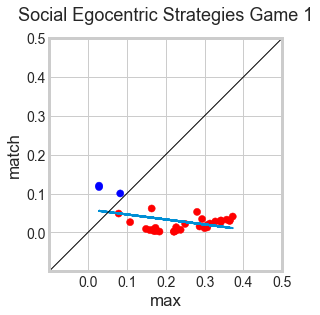

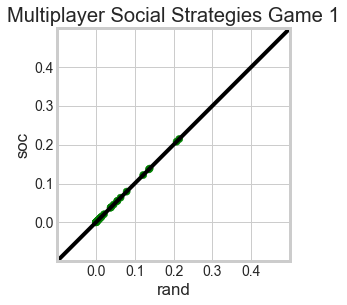

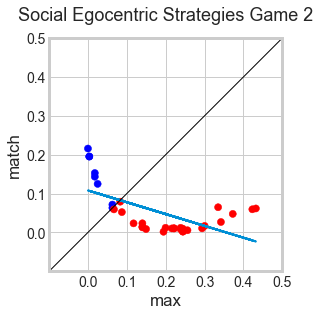

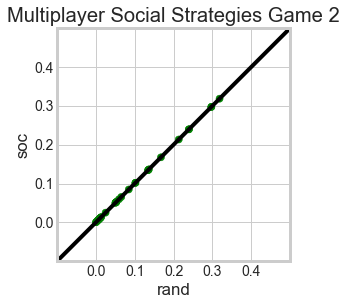

Ttest_relResult(statistic=-1.146788990825688, pvalue=0.262326441367707)

In [364]:
# In[ ]:


import itertools


# In[ ]:


#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
#colors_jsd_j = ['red','lightcoral','red','darkred','green','red',
             # 'blue','darkblue','hotblue','blue','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_social_g1_egocentric = ['red','red','red','red','red','red','red',
                        'red','red','red', 'red','red','red','red',
              'red', 'red','red', 'red','red', 'blue','red','red',
                        'red','red','red','red', 'red', 'red','blue', 
                        'blue','red','red','red','red']


colors_jsd_social_g2_egocentric = ['red','red','red','red','red','blue','red',
                        'red','red','red', 'red','red','blue','red',
             'blue', 'red','red', 'red','red', 'blue','red','blue',
                        'red','red','red','blue', 'red', 'red','blue', 
                        'blue','red','red','red','red']


colors_jsd_social_g1_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green','green', 'green','green', 
                        'green','green','green','green','green']




colors_jsd_social_g2_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green','green', 'green','green', 
                        'green','green','green','green','green']



#markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
         # 'o','v','o','v','o','v','o','v']


# In[ ]:


#Here I print the means of the JSD values in each condition, just to see what they are.'''


# In[ ]:


#run t test to see sig between max and match per game
#put in box plot
social_jsd_g1.mean()


# In[ ]:


social_jsd_g2.mean()


# In[ ]:


import matplotlib.patches as mpatches


# # Graphs

# In[ ]:


#Here I try to plot the JSD Values. Continued below under 'JSD with gender.


# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(social_jsd_g1['max'], social_jsd_g1['match'], 1)

social_ego_jsd_g1_plot = social_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_social_g1_egocentric)
plt.title('Social Egocentric Strategies Game 1', fontsize=18, y=1.05)
social_ego_jsd_g1_plot.plot(social_jsd_g1['max'], m*social_jsd_g1['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
social_ego_jsd_g1_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_1.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()



# In[ ]:


#under line = matching (closer to 0)
#plots of atual jsd values
social_joint_jsd_g1_plot = social_jsd_g1.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_social_g1_joint,title='Multiplayer Social Strategies Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
social_joint_jsd_g1_plot.add_line(line1)



plt.savefig('social_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
social_joint_jsd_g1_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(social_jsd_g2['max'], social_jsd_g2['match'], 1)

social_ego_jsd_g2_plot = social_jsd_g2.plot.scatter(x='max',y='match',s=50,color=colors_jsd_social_g2_egocentric)
plt.title('Social Egocentric Strategies Game 2', fontsize=18, y=1.05)
social_ego_jsd_g2_plot.plot(social_jsd_g2['max'], m*social_jsd_g2['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
social_ego_jsd_g2_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()


# In[ ]:


#under line = matching (closer to 0)
#plots of atual jsd values
social_joint_jsd_g2_plot = social_jsd_g2.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_social_g2_joint,title='Multiplayer Social Strategies Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
social_joint_jsd_g2_plot.add_line(line1)



plt.savefig('social_joint_jsd_2.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
social_joint_jsd_g2_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# # CONTROL (total) scores in G1 and G2

# In[ ]:


#list out all the scores in game 1 by participant
control_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
control_scores_1.set_index('participant', inplace=True, drop=True)

#print
control_scores_1


# In[ ]:


#list out all the scores in game 2 by participant
control_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_2':
        [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score, 
         c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
control_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
control_scores_2


# In[ ]:


#merge both games by participant:
control_scores = pd.merge(control_scores_1, control_scores_2, on = 'participant')


# In[ ]:


#label columns
control_scores.columns=['Game 1','Game 2']


# In[ ]:


control_scores


# In[ ]:


control_scores_1_mean = control_scores_1.mean()


# In[ ]:


control_scores_1_mean


# In[ ]:


control_scores_1_std = control_scores_1.std()


# In[ ]:


control_scores_1_std


# In[ ]:


control_scores_2_mean = control_scores_2.mean()


# In[ ]:


control_scores_2_mean


# In[ ]:


control_scores_2_std = control_scores_2.std()


# In[ ]:


control_scores_2_std


# In[ ]:


control_scores_med = control_scores.median()
control_scores_med


# In[ ]:


control_scores_p = sp.stats.ttest_rel(control_scores['Game 1'],control_scores['Game 2'])


# In[ ]:


control_scores_p


# In[ ]:





# # End of SMAB3 analysis

In [365]:
# In[ ]:


#hypothesis: scores lower for same gender pairs: male-male
'''here i compared scores of pairs of mixed gender and same gender pairs. there are a lot of different types of analyses you can
do on the choice data, and you can group the data by demographics, questionnaire responses, etc.'''


# In[ ]:





# In[ ]:


scores_f = pd.DataFrame([j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j04_p1_g1_score,
            j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,
            j07_p2_g2_score,j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score])


# In[ ]:


scores_mix = pd.DataFrame([j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j02_p1_g1_score,
            j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,
            j05_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j06_p1_g1_score,
            j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score])


# In[ ]:


#m_mean=scores_m.mean()
f_mean=scores_f.mean()
mix_mean=scores_mix.mean()


# In[ ]:


#m_mean


# In[ ]:


f_mean


# In[ ]:


mix_mean


# In[ ]:


#j_combo = j_combo.sort_values(by=['participant'])


# In[ ]:


#j_combo_bar = j_combo.plot(kind='bar',color=colors)


# In[ ]:


j_score_diff = pd.DataFrame({'participant':['j01_p1','j01_p2','j02_p1','j02_p2','j03_p1','j03_p2','j04_p1','j04_p2',
                                          'j05_p1','j05_p2','j06_p1','j06_p2','j07_p1','j07_p2','j06_p1','j06_p2'], 'score_diff':
     [j01_p1_diff,j01_p2_diff,j02_p1_diff,j02_p2_diff,j03_p1_diff,j03_p2_diff,j04_p1_diff,j04_p2_diff,
     j05_p1_diff,j05_p2_diff,j06_p1_diff,j06_p2_diff,j07_p1_diff,j07_p2_diff,j08_p1_diff,j08_p2_diff]})


# In[ ]:


j_score_diff


# In[ ]:


#impairs learning?


# In[ ]:


#pattern within sessions for score_diff?
#5 ppl did worse second time; joint interfered with learning


# In[ ]:


j_score_diff_mean = j_score_diff['score_diff'].mean()


# In[ ]:


j_score_diff_mean

8.375

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

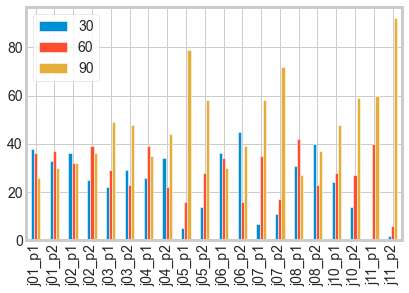

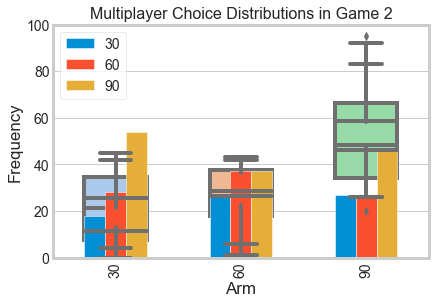

In [366]:
# In[ ]:


j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')


# In[ ]:


#social matching


# In[ ]:


j_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, 
                            j03_p1_g2_count, j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count,
                           j05_p1_g2_count,j05_p2_g2_count, j06_p1_g2_count, j06_p2_g2_count, j07_p1_g2_count, 
                            j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count],
                          index=['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                            'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count',
                           'j05_p1_g2_count','j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                            'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count'])


# In[ ]:


j_g2_counts


# In[ ]:


#j_60_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,1],j_g2_counts.iloc[:,1])


# In[ ]:


#j_60_p


# In[ ]:


#j_30_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,0],j_g2_counts.iloc[:,0])


# In[ ]:


j_30_p


# In[ ]:


j_g2_low = np.mean(j_g2_counts.iloc[:,0])
j_g2_med = np.mean(j_g2_counts.iloc[:,1])
j_g2_high = np.mean(j_g2_counts.iloc[:,2])

j_g2_low_std = np.std(j_g2_counts.iloc[:,0])
j_g2_med_std = np.std(j_g2_counts.iloc[:,1])
j_g2_high_std = np.std(j_g2_counts.iloc[:,2])


# In[ ]:


j_g2_low


# In[ ]:


j_g2_med


# In[ ]:


j_g2_high


# In[ ]:


j_g1_counts_bar = j_g1_counts.plot.bar()


# In[ ]:


j_g2_counts_bar = j_g2_counts.plot.bar()


# In[ ]:


j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"

plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# In[ ]:


j_g2_counts_box = sns.boxplot( 
                 data=j_g2_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="j_g2_counts_box.jpg"

plt.ylim(0, 100)
j_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# In[ ]:

# Maximizing and Matching Strategies

In [367]:
#Here we compare the choice distributions to idealized models of two decision-making strategies: 
#matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
#and maximizing would be always choosing the high reward hole.


# In[ ]:


s_g1_counts


# In[ ]:


s_g1_counts


# In[ ]:


j_g1_counts


# In[ ]:


j_g2_counts


# In[ ]:


#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://urldefense.com/v3/__https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX94Xg7JRI$ . *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://urldefense.com/v3/__https://en.wikipedia.org/wiki/Jensen**BShannon_divergence__;4oCT!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9SSBIvMc$ 
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.


# In[ ]:


#Are ppl using a strategy similar to their partner's? This functions calls jsd for p1 and for p2. *UNFINISHED* 
#DO NOT USE.
#calls jsd for p1 and p2 and for p1 and p2 with the mean
#def compare_strat(p1,p2):
    #strat = jsd(p1,p2)
   # comp_1 = jsd(p1,[j_g1_low,j_g1_med,j_g1_high])
    #comp_2 = jsd(p2,[j_g1_low,j_g1_med,j_g1_high])
    #return strat, comp_1, comp_2


# In[ ]:


#Idealized probability distributions to use for comparison. You can change these or add more models.
maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,50]


# In[ ]:


#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize)
    matchi = jsd(counts,match)
    return maxi,matchi


# In[ ]:


j01_p1_g1_count


# In[ ]:


#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate.

social_max = [0, 100, 0]
social_match = [30/180 * 100,30/180 * 100, 30/180 * 100]


# In[ ]:


#Calls jsd with the social distributions.
def call_jsd_social(counts):
    maxi = jsd(counts,social_max)
    matchi = jsd(counts,social_match)
    return maxi,matchi


# In[ ]:


s01_p1_g1_count


# In[ ]:


from scipy import stats


# In[ ]:


#if same, 0
test = jsd(maximize,match)


# In[ ]:


test


# In[ ]:


s01 = 'match'


# In[ ]:


s05_p1_g2_count


# In[ ]:


s05_p1_g2_count = [11,0,89]


# In[ ]:


# some add to 80, some add to 81??
s_g1_counts


# In[ ]:


s_g2_counts

30    60    90
s01_p1_g2_count  38.0  16.0  46.0
s03_p1_g2_count  27.0  29.0  44.0
s05_p1_g2_count  11.0   0.0  89.0
s06_p1_g2_count   7.0   7.0  86.0
s07_p1_g2_count  18.0  32.0  50.0
s08_p1_g2_count   9.0  15.0  76.0
s09_p1_g2_count  14.0  37.0  49.0
s11_p1_g2_count  28.0  30.0  42.0
s12_p1_g2_count   7.0   5.0  88.0
s15_p1_g2_count   3.0   7.0  90.0
s16_p1_g2_count  29.0  44.0  27.0
s17_p1_g2_count   0.0  22.0  78.0
s19_p1_g2_count  12.0   9.0  79.0
s20_p1_g2_count  10.0  54.0  37.0

In [368]:
# In[ ]:


#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match = call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match = call_jsd(s05_p1_g2_count)
s06_g1_max,s06_g1_match = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match = call_jsd(s06_p1_g1_count)
s07_g1_max,s07_g1_match = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match = call_jsd(s12_p1_g2_count)
s15_g1_max,s15_g1_match = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match = call_jsd([0.0, 3.0, 78.0])
s17_g2_max,s17_g2_match = call_jsd([0, 19, 62])
s19_g1_max,s19_g1_match = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match = call_jsd(s20_p1_g2_count)


# In[ ]:


s17_p1_g1_count


# In[ ]:


s17_p1_g2_count


# In[ ]:


#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
s_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, s19_g1_max, s20_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, s12_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, s20_g1_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])


# In[ ]:


#closer to 0 = closer to that pure strategy
s_jsd_g1


# In[ ]:


#Create a dataframe for single player game 2 jsd scores, with a column for each strategy.'''
s_jsd_g2 = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, s11_g2_max, s12_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, s19_g2_max, s20_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match
                               ,s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, s11_g2_match, s12_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, s20_g2_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])

In [369]:
# In[ ]:


def check_type(df,*social):
    types = pd.DataFrame(index=['type'])
    for index,row in df.iterrows():
        maxi = row["max"]
        matchi = row["match"]
        print(index,maxi,matchi)
        if maxi < matchi:
            print('maxi')
            types = types.append({'type' : 'maxi'},ignore_index=True)
            #types[index,'type'] = 'max'
            num = maxi
        elif matchi < maxi:
            print('matchi')
            types = types.append({'type' : 'matchi'},ignore_index=True)
            num = matchi
        else:
            types = types.append({'type' : 'neither'},ignore_index=True)
            num = 1
        if social == True:
            if num >= jsd(social_max,social_match):
                types = types.append({'type' : 'neither'},ignore_index=True)
        else:
            if num >= jsd(maximize,match):
                types = types.append({'type' : 'neither'},ignore_index=True)
    return types


# In[ ]:


s_types_g1 = check_type(s_jsd_g1)


# In[ ]:


s_types_g2 = check_type(s_jsd_g2)


# In[ ]:


#add label, make sure in correct order
s_types_g1.drop([0])


# In[ ]:


s_types_g2.drop([0])


# In[ ]:


#how different max and match dists are from eachother
#neither max or match(?)
threshold = jsd(maximize,match)


# In[ ]:


threshold


# In[ ]:


s_jsd_g1


# In[ ]:


s_jsd_g2

s01 0.4318754981734429 0.06054148947299787
matchi
s03 0.3136608967716278 0.015697836724085833
matchi
s05 0.19430446226785061 0.0034085885935871106
matchi
s06 0.09138502722922329 0.03951762558866109
matchi
s07 0.23828696089939724 0.0053654131945676635
matchi
s08 0.0285594618498793 0.11676336139531006
maxi
s09 0.24409937049739652 0.0014302350058570182
matchi
s11 0.30016036017557546 0.015397423641056673
matchi
s12 0.1400031203020941 0.01623165498296157
matchi
s15 0.08306135620297604 0.04576596686818012
matchi
s16 0.30016036017557546 0.011028978242923135
matchi
s17 0.01301077227129638 0.16318633737131052
maxi
s19 0.17884892768841604 0.006669897415355728
matchi
s20 0.33696362490947884 0.019880323589985344
matchi
s01 0.23828696089939724 0.03734820425576257
matchi
s03 0.24998841732128801 0.007883430429554528
matchi
s05 0.03972452885343111 0.1461736151764258
maxi
s06 0.09138502722922329 0.03951762558866109
matchi
s07 0.21576155433883565 0.0001962686894984066
matchi
s08 0.09138502722922329 0.03

max     match
s01  0.238287  0.037348
s03  0.249988  0.007883
s05  0.039725  0.146174
s06  0.091385  0.039518
s07  0.215762  0.000196
s08  0.091385  0.037151
s09  0.221288  0.001084
s11  0.262006  0.009448
s12  0.043505  0.095303
s15  0.035974  0.101856
s16  0.364611  0.029562
s17  0.089110  0.076101
s19  0.078954  0.055551
s20  0.295970  0.021312

In [370]:
# In[ ]:


#Call 'call_jsd' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match = call_jsd([0,6,74])
j11_p1_g2_max,j11_p1_g2_match = call_jsd([0,6,74])
j11_p2_g1_max,j11_p2_g1_match = call_jsd([0,6,74])
j11_p2_g2_max,j11_p2_g2_match = call_jsd([0,6,74])


# In[ ]:


#Create a dataframe for joint game 1 jsd scores, with a column for each strategy.'''
j_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max,j10_p1_g1_max,j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])


# In[ ]:


#Create a dataframe for joint game 2 jsd scores, with a column for each strategy.'''
j_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max,j10_p1_g2_max,j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match,j10_p1_g2_match,
                              j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])


# In[ ]:


j_types_g1 = check_type(j_jsd_g1)


# In[ ]:


j_types_g2 = check_type(j_jsd_g2)


# In[ ]:


j_types_g1.drop([0])


# In[ ]:


j_types_g2.drop([0])


# In[ ]:


j_jsd_g1


# In[ ]:


j_jsd_g2


# In[ ]:


#same for joint using "social"

j01 0.37242722211735246 0.040908395510238574
matchi
j01 0.3420144880071857 0.026793253013230066
matchi
j02 0.3276007490949424 0.028191250575098234
matchi
j02 0.30016036017557546 0.011028978242923135
matchi
j03 0.22128824866172742 0.002623936882068798
matchi
j03 0.2268834335864397 0.013299200569501346
matchi
j04 0.3068577088686985 0.012909072374830417
matchi
j04 0.24998841732128801 0.021930764983990762
matchi
j05 0.07895387905098877 0.048562468411548376
matchi
j05 0.17381067052114874 0.003224168082350133
matchi
j06 0.3420144880071857 0.030814349065625385
matchi
j06 0.2806674110234412 0.05276204892546748
matchi
j07 0.17381067052114874 0.011749975387766832
matchi
j07 0.10848682634020129 0.026388230577774827
matchi
j08 0.3646114505633699 0.030882071491651487
matchi
j08 0.2935651532009069 0.03438923030930108
matchi
j10 0.2268834335864397 0.004587099460795689
matchi
j10 0.16882697874109426 0.004105486419217843
matchi
j11 0.026723723680696507 0.13408494168579138
maxi
j11 0.026723723680696507 

max     match
j01  0.194304  0.001674
j01  0.293565  0.010498
j02  0.238287  0.008254
j02  0.140003  0.012990
j03  0.117277  0.023303
j03  0.062871  0.071617
j04  0.372427  0.047613
j04  0.422810  0.059473
j05  0.140003  0.023492
j05  0.199575  0.011901
j06  0.149413  0.008698
j06  0.221288  0.010871
j07  0.017649  0.152735
j07  0.215762  0.010276
j08  0.062871  0.063201
j08  0.140003  0.014880
j10  0.244099  0.001924
j10  0.087205  0.052245
j11  0.026724  0.134085
j11  0.026724  0.134085

In [371]:
# In[ ]:


#Call 'call_jsd_social' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd_social(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd_social(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd_social(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd_social(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd_social(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd_social(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd_social(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd_social(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd_social(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd_social(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd_social(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd_social(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd_social(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd_social(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd_social(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd_social(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd_social(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd_social(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd_social(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd_social(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd_social(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd_social(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd_social(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd_social(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd_social(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd_social(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd_social(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd_social(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd_social(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd_social(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd_social(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd_social(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd_social(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd_social(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd_social(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd_social(j10_p2_g2_count)
#j11 not working
#j11_p1_g1_max,j11_p1_g1_match = call_jsd_social(j11_p1_g1_count)
#j11_p1_g2_max,j11_p1_g2_match = call_jsd_social(j11_p1_g2_count)
#j11_p2_g1_max,j11_p2_g1_match = call_jsd_social(j11_p2_g1_count)
#j11_p2_g2_max,j11_p2_g2_match = call_jsd_social(j11_p2_g2_count)

In [372]:
# In[ ]:


#Create a dataframe for joint game 1 social jsd scores, with a column for each strategy.'''
j_jsd_g1_social = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p1_g1_max, j10_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10'])


# In[ ]:


#Create a dataframe for joint game 2 social jsd scores, with a column for each strategy.'''
j_jsd_g2_social = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08'])


# In[ ]:


j_jsd_g1_social = check_type(j_jsd_g1_social,True)


# In[ ]:


j_jsd_g2_social = check_type(j_jsd_g2_social,True)


# In[ ]:


#j_jsd_g1_social.drop([0])

j_jsd_g1_social


# In[ ]:


j_jsd_g2_social


# In[ ]:

j01 0.3001603601755753 0.0032919808600490354
matchi
j01 0.2935651532009069 0.0009210866283259119
matchi
j02 0.32760074909494247 0.0003925373789966432
matchi
j02 0.2806674110234412 0.004353839692670397
matchi
j03 0.34941116808875117 0.014096617199095787
matchi
j03 0.3968207298318064 0.012167655443583163
matchi
j04 0.2806674110234412 0.0034843272640260412
matchi
j04 0.40529410613611927 0.009550899789536379
matchi
j05 0.46045706049148205 0.12197576718987321
matchi
j05 0.3569415360699646 0.03835499756116475
matchi
j06 0.3136608967716278 0.0007117746385332316
matchi
j06 0.46045706049148205 0.021026200095421166
matchi
j07 0.30685770886869845 0.06368498543923984
matchi
j07 0.45068365594208204 0.07927854680582927
matchi
j08 0.2620056824966033 0.0043748997445118235
matchi
j08 0.39682072983180644 0.00676094207691845
matchi
j10 0.35694153606996454 0.01162462426637402
matchi
j10 0.3646114505633699 0.04007019706990854
matchi
j01 0.3569415360699646 0.025130966500317167
matchi
j01 0.2935651532009069 

type
0       NaN
1    matchi
2    matchi
3    matchi
4    matchi
5    matchi
6    matchi
7    matchi
8    matchi
9    matchi
10   matchi
11   matchi
12   matchi
13   matchi
14  neither
15   matchi
16   matchi
17   matchi

In [373]:
threshold


# In[ ]:


import matplotlib.lines as mlines


# In[ ]:


#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              


# In[ ]:


import itertools


# In[ ]:


#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
colors_jsd_j = ['red','lightcoral','orange','darkorange','green','palegreen',
              'blue','darkblue','hotpink','pink','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_s_g1 = ['red','orange','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
colors_jsd_s_g2 = ['red','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
          'o','v','o','v','o','v','o','v']


# In[ ]:


#Here I print the means of the JSD values in each condition, just to see what they are.'''


# In[ ]:


#run t test to see sig between max and match per game
#put in box plot
s_jsd_g1.mean()


# In[ ]:


s_jsd_g2.mean()


# In[ ]:


j_jsd_g1.mean()


# In[ ]:


j_jsd_g2.mean()


# In[ ]:

max      0.168643
match    0.042691
dtype: float64